In [1]:
experiment_setup_name = "wikicat.long_run.category_focused.10s_batch.nesterov"

In [2]:
import sys
sys.path.append("..")

In [3]:
#import everything in the world
from matplotlib import pyplot as plt
%matplotlib inline
import numpy as np
import theano
theano.config.floatX = 'float32'
theano.config.openmp = True
import theano.tensor as T
import lasagne
%load_ext autoreload
%autoreload 2
import pandas as pd
!mkdir ~/agentnet_snapshots


Couldn't import dot_parser, loading of dot files will not be possible.
mkdir: cannot create directory '/root/agentnet_snapshots': File exists


In [4]:
floatX = theano.config.floatX

from auxilary import _shared,set_shared,_in1d
from persistence import save,load


# Эта тетрадка рассказывает нелёгком пути обучения
* Recurrent Q-network 
* two layers of GRU memory
* Qvalues predicted via dense layer from both memory layers
* epsilon-greedy decision making
* trained with Nesterov Mommentum SGD

# Постановка задачи
* В начале сетке даётся некоторый человек, про которого она пока ничего не знает
* Человек - музыкант или околомузыкальная личность (с меньшей вероятностью - группа или... страна)
* Про человека известен некоторый набор фактов
 * факты типа "Известно, что" - за то, что какой-то аттрибут есть в его вики-карточке
   * например Nickname:is_known - есть прозвище, Died:is_known - есть дата смерти
 * Категориальные факты
   * инструменты, на которых играет человек
   * происхождение
   * декады активности
   * и т.п.


* За один шаг сетка может
 * сказать, что какой-то аттрибут про пользователя есть
   * например, Nickname:is_known - предположение, что у пользователя есть прозвище
   * если догадка верна, сеть получает положительное подкрепление ("конфетку")
   * если нет - отрицательное ("подзатыльник")
 * сказать "больше ничего не угадаю, несите следующего"
   * нулевое подкрепление
   * случайно выбирается следующий пользователь
  

# данные
* Всего в выборке 393 аттрибута
 * примеры аттрибутов в табе ниже
* В данном случае сеть обучается на чуть менее, чем 2500 случайных людей
* всего в выборке почти 100к людей/групп/всякого трэша

In [5]:
#вгрузим данные про кучу музыкантов 
#как оно собирается - ./data/preprocessing.ipynb
import pandas as pd
df = pd.DataFrame.from_csv("../data/musicians_categorized.csv")

0.0346481118134
(22612, 393)


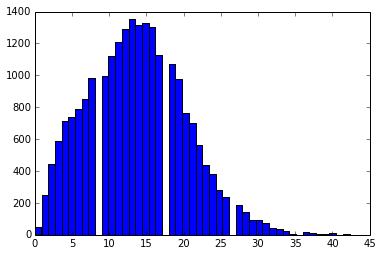

In [6]:
#гистограмма количества аттрибутов известных про музыканта
plt.hist((df.values).sum(axis=1),bins=50)
print (df.values).mean()
print df.shape

In [7]:
#отрежем тех, про кого известно менее 5 аттрибутов
df =  df[df.values.sum(axis=1) > 15]
print "всего самплов", df.shape

всего самплов (8594, 393)


In [8]:
from sklearn.cross_validation import train_test_split

In [9]:
#split categories and attributes
feature_names = df.columns
categorical_columns = np.nonzero(map(lambda s: s.startswith("category:"),feature_names))[0]
attribute_columns = np.nonzero(map(lambda s: not s.startswith("category:"),feature_names))[0]

data_cats = df.iloc[:,categorical_columns]
data_attrs = df.iloc[:,attribute_columns]



In [10]:
#поделим выборку
train_cats,test_cats,train_attrs,test_attrs = train_test_split(data_cats,data_attrs,test_size=0.9,random_state=42)
print "обучающая выборка:" ,len(train_attrs)
print "контрольная выборка:", len(test_attrs)

обучающая выборка: 859
контрольная выборка: 7735


# problem definition

Обучатор состоит из 2 частей
* "среды обучения"
* определятора полезностей
* самой нейронки

Среда обучения - такая штука, которая 
* подсовывает нейронке людей, 
 * каждый раз выбирается случайное подмножество людей 
   * (можно и 100 и 10 - просто не успел сравнить)
   * возвращает ответы на действия нейронки, попутно обновляя своё состояние
Определятор полезностей
* умеет считать полезность каждого действия по паре "состояние СРЕДЫ, действие агента ИЗ этого состояния"
* имеет функции для быстрого определения наград за все действия в сессиях

Нейронка будет далее по списку


__***для простоты, CategoryGuess будет имплементировать И среду И награждатор (см. класс ниже)***__

In [11]:
from objective import BaseObjective
from environment import BaseEnvironment

class CategoryGuess(BaseObjective,BaseEnvironment):
    def __init__(self,n_attrs,n_categories,batch_size=10):
        self._attributes = _shared("X_attrs_data",np.zeros([batch_size,n_attrs]),'uint8')
        self._categories =  _shared("categories_data",np.zeros([batch_size,n_categories]),'uint8')
        self._batch_size = _shared("batch_size_scalar",batch_size,'int32')
        
        _end_action = T.zeros([self._batch_size,1], dtype='uint8')
        
        self._joint_data = T.concatenate([self._attributes,
                                          self._categories,
                                          _end_action,
                                         ],axis=1
).astype('float32') #it is highly important to make sure 
        #that variables touched by theano.grad have float* type
    
        #indices
        self._category_action_ids = T.arange(
            self._attributes.shape[1],
            self._attributes.shape[1]+self._categories.shape[1]
        )
        
        self._end_action_id = self._joint_data.shape[1]-1
    def load_data_batch(self,attrs_batch,categories_batch):
        attrs_batch = np.array(attrs_batch)
        categories_batch = np.array(categories_batch)
        set_shared(self._attributes,attrs_batch)
        set_shared(self._categories,categories_batch)
        set_shared(self._batch_size,attrs_batch.shape[0])

    @property
    def n_actions(self):
        return int(self._joint_data.shape[1].eval())
    @property
    def observation_size(self):
        return int((self._joint_data.shape[1]+1).eval())
    @property
    def state_size(self):
        return int(self._joint_data.shape[1].eval())
    @property
    def batch_size(self):
        return int(self._batch_size.get_value())
        
    
    def get_action_results(self,last_state,action,time_i):
        
        #state is a boolean vector: whether or not i-th action
        #was tried already during this session
        #last output[:,end_code] always remains 1 after first being triggered
        
        
        batch_range = T.arange(action.shape[0])

        can_do_action = T.eq(last_state[:,self._end_action_id],0)
        
        state_after_action = T.set_subtensor(last_state[batch_range,action],1)
        
        new_state = T.switch(
            can_do_action.reshape([-1,1]),
            state_after_action,
            last_state
        )
        
        
        
        observation = T.concatenate([
                self._joint_data[batch_range,action,None],#uint8[batch,1]
                T.extra_ops.to_one_hot(action,self._joint_data.shape[1]),
            ],axis=1)
        
        return new_state, observation

    def get_reward(self,session_states,session_actions,batch_i):
        """
        WARNING! this runs on a single session, not on a batch
        reward given for taking the action in current environment state
        arguments:
            session_states float[time_i, memory_id]: environment state before taking action
            session_actions int[time_i]: agent action at this tick
        returns:
            reward float[time_i]: reward for taking action from the given state
        """
        time_range = T.arange(session_actions.shape[0])
        

        _has_tried_already = session_states[time_range,session_actions]
        _session_is_active = T.eq(session_states[:,self._end_action_id],0)
        _has_finished_now = T.eq(session_actions,self._end_action_id)
        _action_is_categorical = _in1d(session_actions, self._category_action_ids)
        
        _at_least_one_categorical_action = T.any(_action_is_categorical)
        
        _response = self._joint_data[batch_i,session_actions].ravel()
        
        #categorical and attributes
        _reward_for_intermediate_action = T.switch(
            _action_is_categorical,
            _response*3-1,
            _response*2-1
        )
        
        #ending session
        _reward_for_end_action = T.switch(_at_least_one_categorical_action, #if chosen at least 1 category
                                          0,   #do not penalize
                                          -3.)  #else punish
        
        #include end action
        _reward_for_action = T.switch(
            _has_finished_now,
            _reward_for_end_action,
            _reward_for_intermediate_action,
        )
        
        _reward_if_first_time = T.switch(
                _has_tried_already,
                0,
                _reward_for_action,
            )
        
        _final_reward = T.switch(
            _session_is_active,
            _reward_if_first_time,
            0,

            
        )
        
        
        return _final_reward.astype(floatX)

In [12]:
env = CategoryGuess(train_attrs.shape[1],train_cats.shape[1],5)

# agent setup
В свою очередь, нейронка состоит из 3 частей
* память агента
    * на вход получает пару (предыдущее состояние памятиа агента, сенсорная инфа о среде на ЭТОМ шагу)
    * определяет текущее состояние памяти агента (на том же шагу, что и сенсорная инф-ция со входа)
    * тут - GRUlayer, в потенциале - вообще что угодно, хоть 10 шагов LSTM за 1 раз
       * какой именно GRUlayer:
       * Reset gate - dense w/ expit
       * Update gate - dense w/ expit
       * Hidden update gate - dense w/ tanh

* определятор Q-значений
    * на вход получает память агента
    * определяет Q_значения каждого действия
    * тут - DenseLayer, потенциал - что угодно
* приниматор решений по Q-значениям
    * на вход получает Q-значения для действий
    * определяет, как вывод нейронки трансформируется в решение,
    * формат выхода - целые числа - номера выбранных действий
     * тут - с вероятностью epsilon берётся решение, 
       * которому предсказана наибольшая полезность
       * иначе берётся случайное равновероятное
     * альтернативный вариант - решения выбираются с веростностями
       * $Pi(a) = softmax(Qi(a)) = {e^{Qi(x)}} / {\sum\limits_{j=1}^n e^{Qj(X)}}$ 
       * где Q(a) - предсказанная полезность действия a
* всё это делается векторизованно для батча произвольной размерности


### Agent - просто обёртка над этими 3 пунктами
* строго говоря, можно воткнуть любую нейронку, которая мапает 
* `float last_agent_state[batch,units], float observation[batch,sensors] ->`
* `-> float new_agent_state[batch,units], float qvalues[batch,actions], int actions[batch]`


In [13]:
from resolver import EpsilonGreedyResolver
from memory import GRUMemoryLayer
from agent import Agent

In [14]:
import lasagne
__idea__="""
 
We train two memory states:
    first one, based on observations, and second one, based on first one;

Note that here we update the second memory layer based on the CURRENT state
of the first one. Instead, you can try to feed it with a previous state.

The q-values are estimated on a concatenated state, effectively on both memory
states together, but there is no problem with limiting q-evaluator to only one:
just pass the correct gru layer as an incoming layer to the q-evaluator.

Implementation:
We concatenate both memories into 1 state to pass it through the session loop.

To perform memory update, we need to slice the concatenated state back into
two memory states.

We do so by defining an input map function and passing it into agent.

We than concatenate two new states back to form a new memory state.

"""
n_hid_1=128 #first GRU memory
n_hid_2=64 #second GRU memory


_observation_layer = lasagne.layers.InputLayer([None,env.observation_size],name="obs_input")

_prev_gru1_layer = lasagne.layers.InputLayer([None,n_hid_1],name="prev_gru1_state_input")
_prev_gru2_layer = lasagne.layers.InputLayer([None,n_hid_2],name="prev_gru2_state_input")

#memory
gru1 = GRUMemoryLayer(n_hid_1,
                     _observation_layer,
                     _prev_gru1_layer,
                     name="gru1")

gru2 = GRUMemoryLayer(n_hid_2,
                     gru1,        #note that it takes CURRENT gru1 output as input.
                                  #replacing that with _prev_gru1_state would imply taking previous one.
                     _prev_gru2_layer,
                     name="gru2")

concatenated_memory = lasagne.layers.concat([gru1,gru2])

#q_eval
q_eval = lasagne.layers.DenseLayer(concatenated_memory, #taking both memories. 
                                                        #Replacing with gru1 or gru2 would mean taking one
                                   num_units = env.n_actions,
                                   nonlinearity=lasagne.nonlinearities.linear,name="QEvaluator")
#resolver
epsilon = _shared("e-greedy.epsilon",0.9,dtype=floatX)

resolver = EpsilonGreedyResolver(q_eval,epsilon=epsilon,name="resolver")



#we need to define the new input map because concatenated_memory is a ConcatLayer and does not have default one

def custom_input_map(last_hidden,observation):
    """just a function that maps memory states to respective inputs"""
    return {
        _prev_gru1_layer:last_hidden[:,0:n_hid_1],
        _prev_gru2_layer:last_hidden[:,n_hid_1:n_hid_1+n_hid_2],
        _observation_layer:observation
    }

#all together
agent = Agent(concatenated_memory,q_eval,resolver,input_map=custom_input_map
             )


In [15]:
history = agent.get_sessions(env,session_length=20,
                       batch_size=env._joint_data.shape[0],)
state_seq,observation_seq,hidden_seq,qvalues_seq,action_seq = history

rewards_seq = env.get_reward_sequences(state_seq,action_seq)


In [16]:
get_history = theano.function([],history+(rewards_seq,),mode=theano.compile.mode.FAST_RUN)



# weights
* вот так нахаляву можно вытащить ВСЕ веса нейронок агента
* что НЕ вытаскивается 
 * архитектура сети
 * гиперпараметры (жадность, gamma)
 * состояния среды/наблюдения
* короче, вытаскиваются только "нейронячие" параметры
* хочешь, чтобы в твоём слое вытащилась какая-то shared переменная - добавь её в параметры слоя [с каким-ть тэгом, если хочешь]
* всё как в ванильной лазанье

In [17]:
#all trainable weights
weights = lasagne.layers.get_all_params(resolver,trainable=True)
weights

[gru1.W_in_to_updategate,
 gru1.W_hid_to_updategate,
 gru1.b_updategate,
 gru1.W_in_to_resetgate,
 gru1.W_hid_to_resetgate,
 gru1.b_resetgate,
 gru1.W_in_to_hidden_update,
 gru1.W_hid_to_hidden_update,
 gru1.b_hidden_update,
 gru2.W_in_to_updategate,
 gru2.W_hid_to_updategate,
 gru2.b_updategate,
 gru2.W_in_to_resetgate,
 gru2.W_hid_to_resetgate,
 gru2.b_resetgate,
 gru2.W_in_to_hidden_update,
 gru2.W_hid_to_hidden_update,
 gru2.b_hidden_update,
 QEvaluator.W,
 QEvaluator.b]

In [18]:
#all weights but for Qvalues prediciton ones (not to penalize q-predictors by l2)
weights_inner = filter(lambda w: "QEvaluator" not in w.name,weights)
weights_inner

[gru1.W_in_to_updategate,
 gru1.W_hid_to_updategate,
 gru1.b_updategate,
 gru1.W_in_to_resetgate,
 gru1.W_hid_to_resetgate,
 gru1.b_resetgate,
 gru1.W_in_to_hidden_update,
 gru1.W_hid_to_hidden_update,
 gru1.b_hidden_update,
 gru2.W_in_to_updategate,
 gru2.W_hid_to_updategate,
 gru2.b_updategate,
 gru2.W_in_to_resetgate,
 gru2.W_hid_to_resetgate,
 gru2.b_resetgate,
 gru2.W_in_to_hidden_update,
 gru2.W_hid_to_hidden_update,
 gru2.b_hidden_update]

# целевая функция для обучения сети

* Интуитивно, цель - предсказывать Q-значения (полезности) действий
* $Q(s,a) = R(s,a) + gamma* Max_{a'}{ Q(s',a')}  $
 * R(s,a) - непосредственная награда за действие (+5 если угадал, -1 если нет и т.п.)
 * s' - состояние, в которое агент попал, сделав действие a из состояния s
 * a' - действие, которое можно совершить в состоянии s'
 * gamma - во сколько раз награда/пинок через 1 шаг менее значимы, чем сейчас
 * интуиция - "в состоянии s полезность действия a - это непосредственная печенька за это действие ПЛЮС все печеньки, которые можно собрать, если после этого действия вести себя оптимально"
 
* В реальном мире оптимизируются попарно 2 приближения этой функции
* $ RMSE_{reccurent}: (NN_s(a) - (R + gamma* Max_a'{ NN_s'(a')})^2$
 * NN_s(a) предсказаннная из состояния s полезност Q(s,a)
 * считается для тех NN_s(a), которые агент совершил
 * NN_s'(a') - полезности всех действий сразу после совершения a из состяния s

* $ RMSE_{naive}: (NN_s(a^*) - (R + gamma*  NN_s'(a'^*))^2$
 * аналогично предыдущему, но a* - реально совершённое агентом действие
 * оценка смещена, но куда проще оптимизируется, чем предыдущая
   * по крайней мере, с softmax принятием решений

In [19]:
is_alive_seq = T.eq(state_seq[:,:,-1],0)

#gamma - delayed reward coefficient - what fraction of reward is retained if it is obtained one tick later
gamma = _shared('q_learning_gamma',np.float32(0.95),floatX)


ref_tuples = env.get_reference_tuples(qvalues_seq,action_seq,rewards_seq,is_alive_seq,gamma_or_gammas=gamma,)

action_ids_ravel,immediate_rewards_ravel, predicted_Qvalues_ravel,reference_Qvalues_ravel,is_end_ravel= ref_tuples

from auxilary import consider_constant
reference_Qvalues_ravel = consider_constant(reference_Qvalues_ravel)

predicted_Qvalues_for_actions_ravel = predicted_Qvalues_ravel[T.arange(action_ids_ravel.shape[0]),action_ids_ravel]


In [20]:
loss_recurrent = lasagne.objectives.squared_error(reference_Qvalues_ravel,predicted_Qvalues_for_actions_ravel).mean()

In [21]:
weight_ravel = T.concatenate([w.ravel() for w in weights_inner])
reg_l2 = reg_l2 = T.mean(weight_ravel**2)*0.1


In [22]:
loss = loss_recurrent + reg_l2

# алгоритм обучения
* обучаются все параметры обычным Stochastic Gradient Descent с Nestrov Mommentum
* регуляризации нет, ибо пока не понадобилась

In [23]:
_updates = lasagne.updates.nesterov_momentum(loss,weights,learning_rate=0.01,momentum=0.9)
#updates = lasagne.updates.sgd(loss_recurrent,weights,0.1)

In [24]:
mean_session_reward = immediate_rewards_ravel.sum()/ rewards_seq.shape[0]
train_fun = theano.function([],[loss,loss_recurrent,reg_l2,mean_session_reward],updates=_updates)
loss_fun = theano.function([],[loss,loss_recurrent,reg_l2,mean_session_reward])

# evaluation
* удобная [мне одному] функция, которая показывает примеры сессий и внутреннее состояние нейронки
* текстовая часть - 
    * #(номер_действия) (имя_действия) (предсказанное_Qvalue) -> (награда) | следующая итерация
* картинка (если display = True)
    * X - моменты времени, Y - попугаи
    * жЫрные линии - Q-значения категорий
    * тонкие линии - Q-значения узнавания аттрибутов
    * точки на линиях - выбранные действия
    * пунктирные линии - активация нейронов в памяти агента
    * синяя черта (тонкая, вертикальная) - конец сессии (действие или лимит времени)


In [25]:
evaluation_fun = theano.function([],[action_ids_ravel,predicted_Qvalues_for_actions_ravel,immediate_rewards_ravel,
                                     reference_Qvalues_ravel,is_end_ravel,
                                     hidden_seq,qvalues_seq,action_seq])


In [26]:
#new names order
feature_names = list(data_attrs.columns) + list(data_cats.columns) + ["<end_session_action>"]
is_categorical = lambda i: feature_names[i].startswith("category:")

def print_session(n_sessions = 3,display=False,legend=True):
    
    a_lot_of_data = evaluation_fun()    
    actions,qvalues,rewards,ref_qvalues,end_sel = a_lot_of_data[:5]
    hidden_log,qvalues_log,action_log = a_lot_of_data[5:]
    
    
    
    b_i = 0 #batch iter ~ session iter
    t_i = 0 #time iter
    

    for a,q,r,q_ref,is_end in zip(actions,qvalues,rewards,ref_qvalues,end_sel):
        print "#%i: %s (%.3f) -> %s |"%(a,feature_names[a],q, r,),
        
        
        t_i +=1
        if is_end ==1:
            
            print '<end>'
            print 'true:',
            for cat in env._categories.get_value()[b_i].nonzero()[0]:
                print feature_names[cat+env._attributes.shape[1].eval()],
            print
                
            #plot qvalues
            if display:
                plt.figure(figsize=[16,8])

                q_values = qvalues_log[b_i].T
                for i in range(q_values.shape[0]):
                    plt.plot(q_values[i],label=feature_names[i],linewidth = 1 + 4*is_categorical(i))

                hidden_activity =  hidden_log[b_i].T
                for i, hh in enumerate(hidden_activity):
                    plt.plot(hh,'--',label='n'+str(i))
                    
                session_actions = action_log[b_i,:t_i]
                action_range = np.arange(len(session_actions))
                plt.scatter(action_range, qvalues_log[b_i][action_range, session_actions])


                #session end
                plt.plot(np.repeat(t_i-1,2),np.linspace(-0.5,0.5,2))
                plt.xlim(0,max(t_i*1.1,2))
                plt.xticks(np.arange(t_i))
                plt.grid()
                if legend:
                    plt.legend()
                plt.show()
                
            print
            #/
            b_i +=1
            t_i = 0

            if b_i >= n_sessions:
                break


# training

In [27]:
def load_random_batch(env,attrs,cats,batch_size=10):
    
    attrs,cats = np.array(attrs),np.array(cats)
    
    assert len(attrs) == len(cats)
    batch_ids = np.random.randint(0,len(attrs),batch_size)
    env.load_data_batch(attrs[batch_ids],cats[batch_ids])

In [28]:
from collections import defaultdict

epoch_counter = 1
score_log = defaultdict(dict) #{metric_name: {epoch:value} }

def plot_scores(title="metrics"):
    plt.figure(figsize=[10,10])
    plt.title("metrics history")
    for metric_name, metric_dict in score_log.items():            
        plt.plot(*zip(*sorted(metric_dict.items())),label = metric_name)

    plt.title(title)
    plt.grid()
    plt.legend(loc='lower right')
    plt.show()


In [29]:
alpha = 0.1
ma_reward = 0.
ma_reward_greedy = 0.
ma_reward_test = 0.

# само обучение
* шаг алгоритма - 
 * выбрать B случайных людей
 * пересчитать "жадность" алгоритма (чем дальше, тем более жадный)
 * сделать шаг обучения
 * раз в M итераций - добавить точку на график обучения по 3 метрикам
   * ожидание награды за сессию при текущей жадности на тренировочных данных
   * то же самое при максимальной жадности
 * раз в N итераций - 
   * показать несколько примеров сессий на обучающих данных при разной жадности
   * показать графики обучения
* раз в K итераций - записать веса нейронки в файл (snapshot)

epoch 100,loss 0.33149, greed 0.20090, rewards: ( train -15.18355, det_train 0.00000) 
rec 0.330 reg 0.001
epoch 200,loss 0.31733, greed 0.20180, rewards: ( train -12.92053, det_train 0.06000) 
rec 0.316 reg 0.001
epoch 300,loss 0.71730, greed 0.20270, rewards: ( train -12.68935, det_train 0.21400) 
rec 0.716 reg 0.001
epoch 400,loss 1.61610, greed 0.20359, rewards: ( train -12.27614, det_train 0.23260) 
rec 1.615 reg 0.001
epoch 500,loss 1.08587, greed 0.20449, rewards: ( train -12.15925, det_train 0.29934) 
rec 1.085 reg 0.001
epoch 600,loss 1.18900, greed 0.20538, rewards: ( train -13.71606, det_train 0.52941) 
rec 1.188 reg 0.001
epoch 700,loss 0.83163, greed 0.20628, rewards: ( train -12.70220, det_train 0.15647) 
rec 0.831 reg 0.001
epoch 800,loss 0.70923, greed 0.20717, rewards: ( train -12.46543, det_train 0.32082) 
rec 0.708 reg 0.001
epoch 900,loss 0.96883, greed 0.20806, rewards: ( train -12.08520, det_train 0.47874) 
rec 0.968 reg 0.001
Evaluation:

deterministic
#26: decad

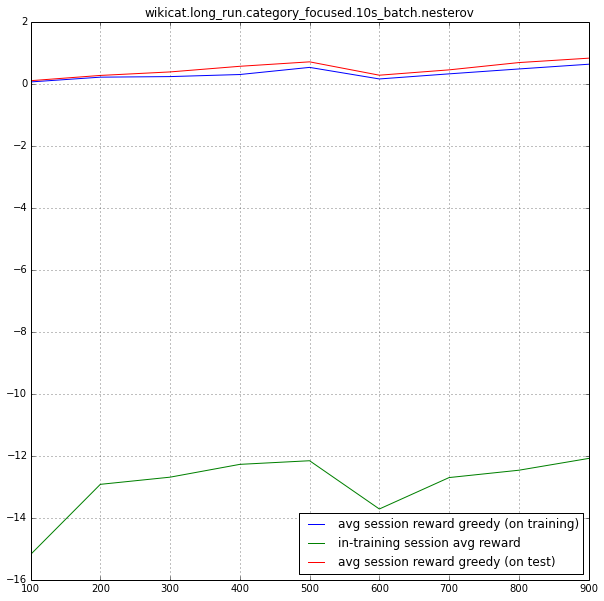

epoch 1000,loss 0.94923, greed 0.20896, rewards: ( train -12.49137, det_train 0.63086) 
rec 0.948 reg 0.001
epoch 1100,loss 1.23897, greed 0.20985, rewards: ( train -12.01415, det_train 0.81778) 
rec 1.238 reg 0.001
epoch 1200,loss 0.74794, greed 0.21074, rewards: ( train -12.62865, det_train 1.11600) 
rec 0.747 reg 0.001
epoch 1300,loss 0.49322, greed 0.21162, rewards: ( train -12.36658, det_train 1.28440) 
rec 0.492 reg 0.001
epoch 1400,loss 0.60166, greed 0.21251, rewards: ( train -12.63342, det_train 1.43596) 
rec 0.601 reg 0.001
epoch 1500,loss 0.89885, greed 0.21340, rewards: ( train -12.82362, det_train 1.22236) 
rec 0.898 reg 0.001
epoch 1600,loss 0.66568, greed 0.21429, rewards: ( train -12.26893, det_train 1.21013) 
rec 0.665 reg 0.001
epoch 1700,loss 0.48113, greed 0.21517, rewards: ( train -11.91936, det_train 1.34911) 
rec 0.480 reg 0.001
epoch 1800,loss 1.34171, greed 0.21606, rewards: ( train -12.82849, det_train 1.27420) 
rec 1.341 reg 0.001
epoch 1900,loss 0.94238, gre

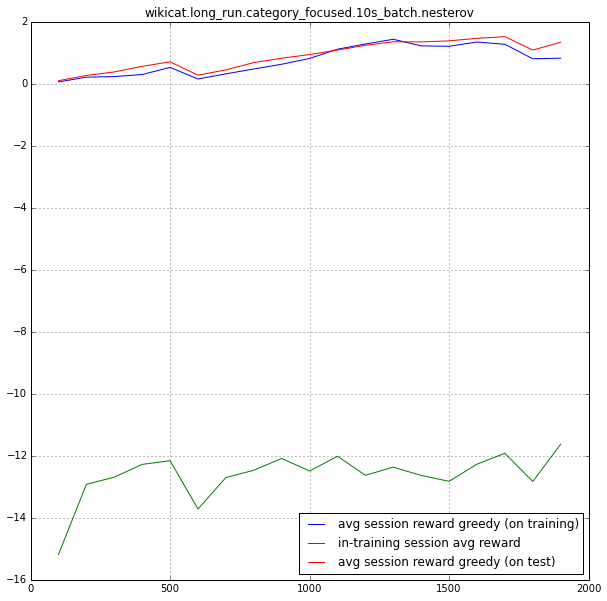

epoch 2000,loss 0.35325, greed 0.21782, rewards: ( train -12.09094, det_train 0.82610) 
rec 0.352 reg 0.001
epoch 2100,loss 0.76712, greed 0.21870, rewards: ( train -13.14621, det_train 1.06349) 
rec 0.766 reg 0.001
epoch 2200,loss 0.74052, greed 0.21958, rewards: ( train -12.08669, det_train 0.74714) 
rec 0.739 reg 0.001
epoch 2300,loss 0.88333, greed 0.22046, rewards: ( train -12.27896, det_train 0.88243) 
rec 0.882 reg 0.001
epoch 2400,loss 0.78004, greed 0.22134, rewards: ( train -12.02176, det_train 0.71419) 
rec 0.779 reg 0.001
epoch 2500,loss 1.17925, greed 0.22222, rewards: ( train -11.33730, det_train 0.96277) 
rec 1.178 reg 0.001
epoch 2600,loss 1.20161, greed 0.22310, rewards: ( train -11.83356, det_train 1.13649) 
rec 1.201 reg 0.001
epoch 2700,loss 0.44417, greed 0.22397, rewards: ( train -11.67120, det_train 0.94284) 
rec 0.443 reg 0.001
epoch 2800,loss 1.50138, greed 0.22485, rewards: ( train -12.60722, det_train 1.25856) 
rec 1.500 reg 0.001
epoch 2900,loss 0.80157, gre

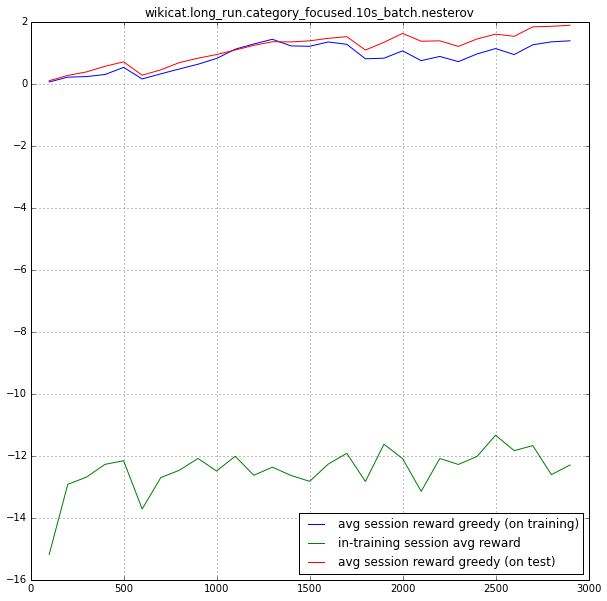

epoch 3000,loss 0.47454, greed 0.22660, rewards: ( train -11.67396, det_train 1.38743) 
rec 0.473 reg 0.001
epoch 3100,loss 0.39969, greed 0.22747, rewards: ( train -11.88196, det_train 1.40869) 
rec 0.399 reg 0.001
epoch 3200,loss 0.45833, greed 0.22834, rewards: ( train -11.74435, det_train 1.49782) 
rec 0.457 reg 0.001
epoch 3300,loss 0.49907, greed 0.22922, rewards: ( train -11.63756, det_train 1.45804) 
rec 0.498 reg 0.001
epoch 3400,loss 0.61292, greed 0.23009, rewards: ( train -12.21060, det_train 1.53223) 
rec 0.612 reg 0.001
epoch 3500,loss 0.39890, greed 0.23096, rewards: ( train -12.08140, det_train 1.49901) 
rec 0.398 reg 0.001
epoch 3600,loss 0.63028, greed 0.23182, rewards: ( train -12.01295, det_train 1.58911) 
rec 0.629 reg 0.001
epoch 3700,loss 0.68436, greed 0.23269, rewards: ( train -11.71968, det_train 1.43020) 
rec 0.683 reg 0.001
epoch 3800,loss 1.17780, greed 0.23356, rewards: ( train -12.73269, det_train 1.19718) 
rec 1.177 reg 0.001
epoch 3900,loss 0.58044, gre

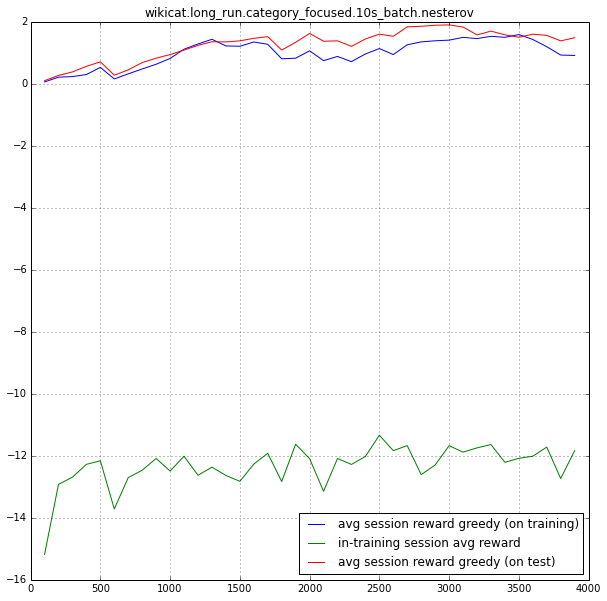

epoch 4000,loss 0.76620, greed 0.23529, rewards: ( train -11.92274, det_train 0.91471) 
rec 0.765 reg 0.001
epoch 4100,loss 0.52983, greed 0.23615, rewards: ( train -11.39550, det_train 0.70324) 
rec 0.529 reg 0.001
epoch 4200,loss 0.40300, greed 0.23702, rewards: ( train -11.60579, det_train 0.91292) 
rec 0.402 reg 0.001
epoch 4300,loss 1.36745, greed 0.23788, rewards: ( train -11.24715, det_train 1.24163) 
rec 1.366 reg 0.001
epoch 4400,loss 0.56724, greed 0.23874, rewards: ( train -12.01905, det_train 1.34746) 
rec 0.566 reg 0.001
epoch 4500,loss 0.59835, greed 0.23960, rewards: ( train -11.54681, det_train 1.01272) 
rec 0.597 reg 0.001
epoch 4600,loss 0.49266, greed 0.24046, rewards: ( train -11.72588, det_train 1.25145) 
rec 0.492 reg 0.001
epoch 4700,loss 0.90611, greed 0.24132, rewards: ( train -11.13906, det_train 1.34630) 
rec 0.905 reg 0.001
epoch 4800,loss 0.32792, greed 0.24218, rewards: ( train -10.90928, det_train 1.61167) 
rec 0.327 reg 0.001
epoch 4900,loss 0.41410, gre

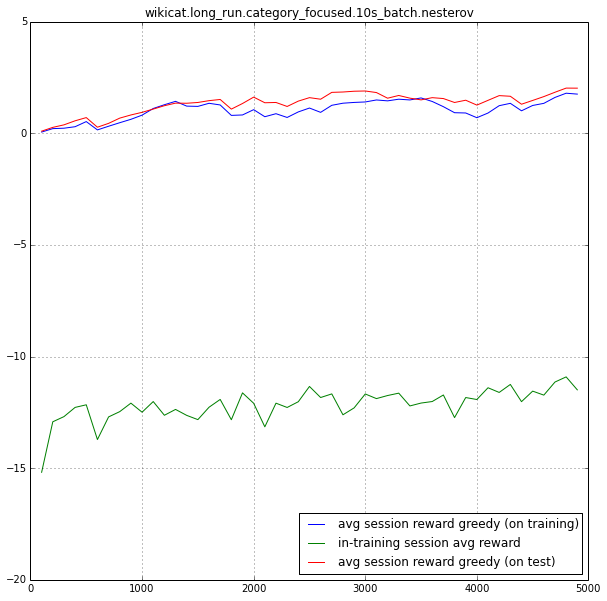

epoch 5000,loss 0.26543, greed 0.24389, rewards: ( train -11.60398, det_train 1.76045) 
rec 0.264 reg 0.001
epoch 5100,loss 0.37111, greed 0.24475, rewards: ( train -11.46137, det_train 1.74441) 
rec 0.370 reg 0.001
epoch 5200,loss 0.73125, greed 0.24560, rewards: ( train -11.63284, det_train 1.74997) 
rec 0.730 reg 0.001
epoch 5300,loss 0.45732, greed 0.24646, rewards: ( train -11.90926, det_train 1.71497) 
rec 0.456 reg 0.001
epoch 5400,loss 0.33337, greed 0.24731, rewards: ( train -11.15583, det_train 1.36347) 
rec 0.332 reg 0.001
epoch 5500,loss 0.45058, greed 0.24816, rewards: ( train -10.64546, det_train 1.66713) 
rec 0.449 reg 0.001
epoch 5600,loss 0.80339, greed 0.24901, rewards: ( train -11.13147, det_train 2.02041) 
rec 0.802 reg 0.001
epoch 5700,loss 0.50375, greed 0.24987, rewards: ( train -11.21689, det_train 2.42837) 
rec 0.503 reg 0.001
epoch 5800,loss 0.36206, greed 0.25072, rewards: ( train -10.78701, det_train 1.90554) 
rec 0.361 reg 0.001
epoch 5900,loss 0.47223, gre

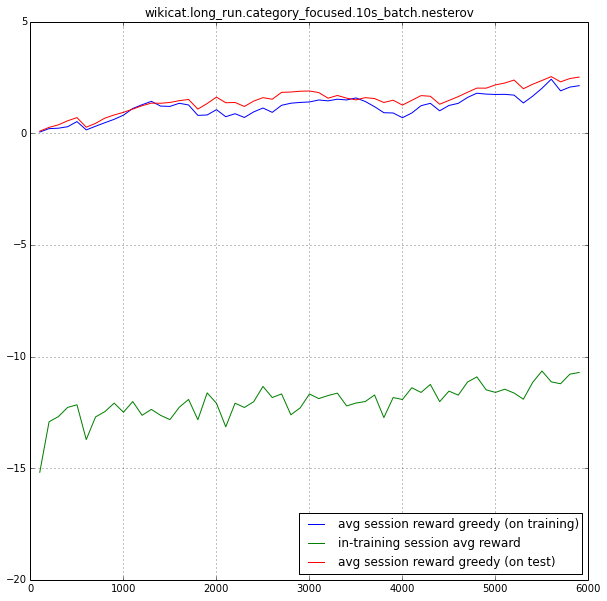

epoch 6000,loss 0.29047, greed 0.25241, rewards: ( train -11.14007, det_train 2.13748) 
rec 0.289 reg 0.001
epoch 6100,loss 0.29511, greed 0.25326, rewards: ( train -10.87488, det_train 2.07374) 
rec 0.294 reg 0.001
epoch 6200,loss 0.29522, greed 0.25411, rewards: ( train -10.97892, det_train 2.32636) 
rec 0.294 reg 0.001
epoch 6300,loss 0.39295, greed 0.25495, rewards: ( train -11.06447, det_train 2.45373) 
rec 0.392 reg 0.001
epoch 6400,loss 0.38220, greed 0.25580, rewards: ( train -10.85323, det_train 2.60835) 
rec 0.381 reg 0.001
epoch 6500,loss 0.42925, greed 0.25664, rewards: ( train -11.23457, det_train 2.67752) 
rec 0.428 reg 0.001
epoch 6600,loss 0.33110, greed 0.25748, rewards: ( train -10.96962, det_train 2.23977) 
rec 0.330 reg 0.001
epoch 6700,loss 0.46447, greed 0.25832, rewards: ( train -10.64140, det_train 2.36579) 
rec 0.463 reg 0.001
epoch 6800,loss 0.26287, greed 0.25917, rewards: ( train -10.69175, det_train 2.44921) 
rec 0.262 reg 0.001
epoch 6900,loss 0.40896, gre

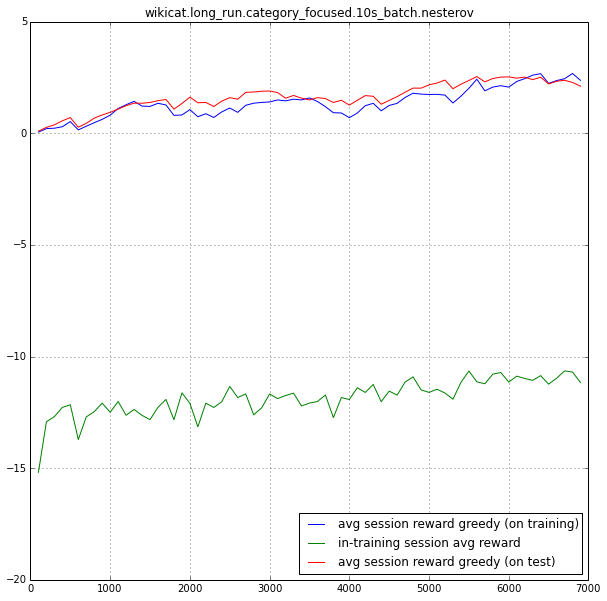

epoch 7000,loss 0.25748, greed 0.26085, rewards: ( train -10.77774, det_train 2.37586) 
rec 0.256 reg 0.001
epoch 7100,loss 0.51159, greed 0.26168, rewards: ( train -11.21145, det_train 2.37827) 
rec 0.510 reg 0.001
epoch 7200,loss 0.48795, greed 0.26252, rewards: ( train -10.38021, det_train 2.57045) 
rec 0.487 reg 0.001
epoch 7300,loss 0.45160, greed 0.26336, rewards: ( train -10.90496, det_train 2.41340) 
rec 0.450 reg 0.001
epoch 7400,loss 0.31428, greed 0.26420, rewards: ( train -10.68820, det_train 2.39206) 
rec 0.313 reg 0.001
epoch 7500,loss 0.27883, greed 0.26503, rewards: ( train -10.86301, det_train 2.59286) 
rec 0.278 reg 0.001
epoch 7600,loss 0.34993, greed 0.26587, rewards: ( train -10.58549, det_train 2.69357) 
rec 0.349 reg 0.001
epoch 7700,loss 0.29249, greed 0.26670, rewards: ( train -10.51368, det_train 3.02421) 
rec 0.291 reg 0.001
epoch 7800,loss 0.28710, greed 0.26753, rewards: ( train -10.96473, det_train 3.14179) 
rec 0.286 reg 0.001
epoch 7900,loss 0.36104, gre

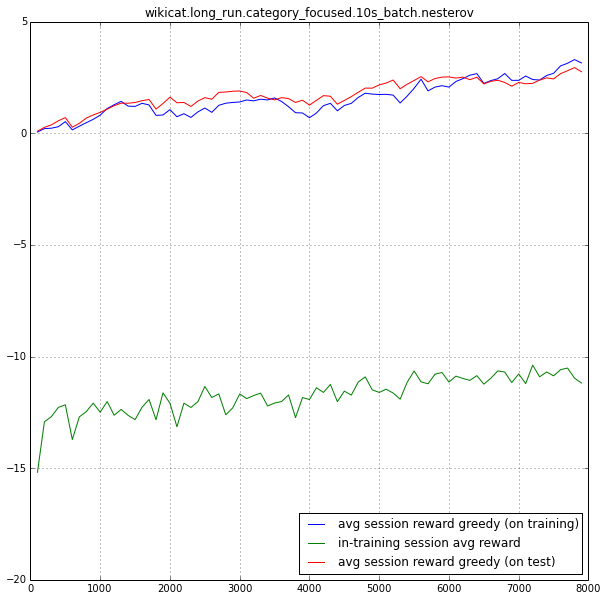

epoch 8000,loss 0.42847, greed 0.26920, rewards: ( train -10.75562, det_train 3.15685) 
rec 0.427 reg 0.001
epoch 8100,loss 0.45318, greed 0.27003, rewards: ( train -10.51376, det_train 3.19117) 
rec 0.452 reg 0.001
epoch 8200,loss 0.47780, greed 0.27086, rewards: ( train -10.31393, det_train 3.13205) 
rec 0.477 reg 0.001
epoch 8300,loss 0.34370, greed 0.27168, rewards: ( train -10.86089, det_train 3.01884) 
rec 0.343 reg 0.001
epoch 8400,loss 0.38704, greed 0.27251, rewards: ( train -10.77248, det_train 3.14696) 
rec 0.386 reg 0.001
epoch 8500,loss 0.42466, greed 0.27334, rewards: ( train -10.70091, det_train 3.09226) 
rec 0.424 reg 0.001
epoch 8600,loss 0.23547, greed 0.27417, rewards: ( train -10.27105, det_train 3.04304) 
rec 0.234 reg 0.001
epoch 8700,loss 0.32903, greed 0.27499, rewards: ( train -10.91729, det_train 3.32873) 
rec 0.328 reg 0.001
epoch 8800,loss 0.55535, greed 0.27582, rewards: ( train -10.89681, det_train 3.35586) 
rec 0.554 reg 0.001
epoch 8900,loss 0.43857, gre

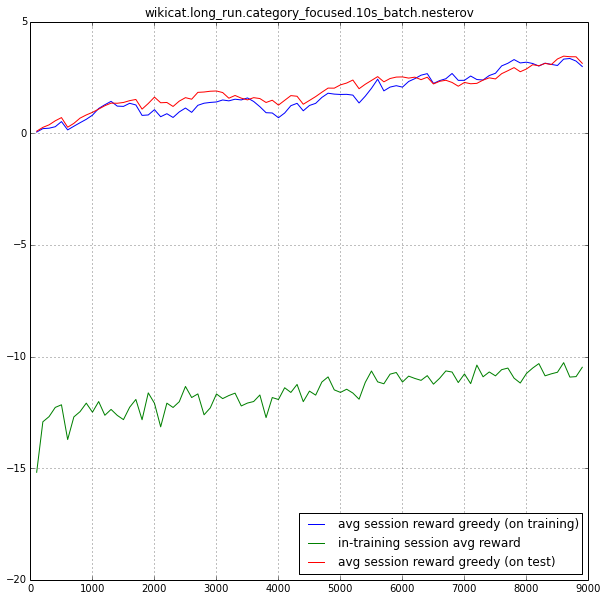

epoch 9000,loss 0.29534, greed 0.27746, rewards: ( train -10.61699, det_train 2.99625) 
rec 0.294 reg 0.001
epoch 9100,loss 0.40468, greed 0.27828, rewards: ( train -10.57764, det_train 3.08662) 
rec 0.404 reg 0.001
epoch 9200,loss 0.41905, greed 0.27911, rewards: ( train -10.96115, det_train 3.03796) 
rec 0.418 reg 0.001
epoch 9300,loss 0.39885, greed 0.27993, rewards: ( train -10.17154, det_train 2.85416) 
rec 0.398 reg 0.001
epoch 9400,loss 0.43029, greed 0.28075, rewards: ( train -9.93991, det_train 2.77875) 
rec 0.429 reg 0.001
epoch 9500,loss 0.37454, greed 0.28156, rewards: ( train -10.45146, det_train 2.70087) 
rec 0.373 reg 0.001
epoch 9600,loss 0.35124, greed 0.28238, rewards: ( train -10.52334, det_train 2.65079) 
rec 0.350 reg 0.001
epoch 9700,loss 0.41850, greed 0.28320, rewards: ( train -10.49860, det_train 2.71571) 
rec 0.417 reg 0.001
epoch 9800,loss 0.37679, greed 0.28402, rewards: ( train -10.60162, det_train 2.68414) 
rec 0.376 reg 0.001
epoch 9900,loss 0.42629, gree

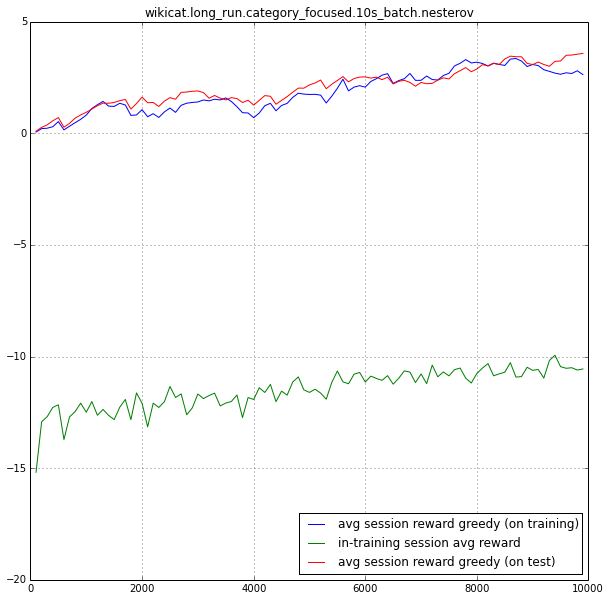

epoch 10000,loss 0.41644, greed 0.28565, rewards: ( train -11.22165, det_train 2.63515) 
rec 0.415 reg 0.001
epoch 10100,loss 0.31603, greed 0.28646, rewards: ( train -10.15596, det_train 2.64164) 
rec 0.315 reg 0.001
epoch 10200,loss 0.17760, greed 0.28727, rewards: ( train -10.09456, det_train 2.79747) 
rec 0.176 reg 0.001
epoch 10300,loss 0.34842, greed 0.28809, rewards: ( train -10.00694, det_train 2.99772) 
rec 0.347 reg 0.001
epoch 10400,loss 0.33917, greed 0.28890, rewards: ( train -9.85980, det_train 2.82795) 
rec 0.338 reg 0.001
epoch 10500,loss 0.32225, greed 0.28971, rewards: ( train -10.30266, det_train 3.04516) 
rec 0.321 reg 0.001
epoch 10600,loss 0.49398, greed 0.29052, rewards: ( train -9.97960, det_train 3.12064) 
rec 0.493 reg 0.001
epoch 10700,loss 0.39720, greed 0.29133, rewards: ( train -10.29565, det_train 3.04858) 
rec 0.396 reg 0.001
epoch 10800,loss 0.64667, greed 0.29214, rewards: ( train -9.70053, det_train 3.17372) 
rec 0.646 reg 0.001
epoch 10900,loss 0.305

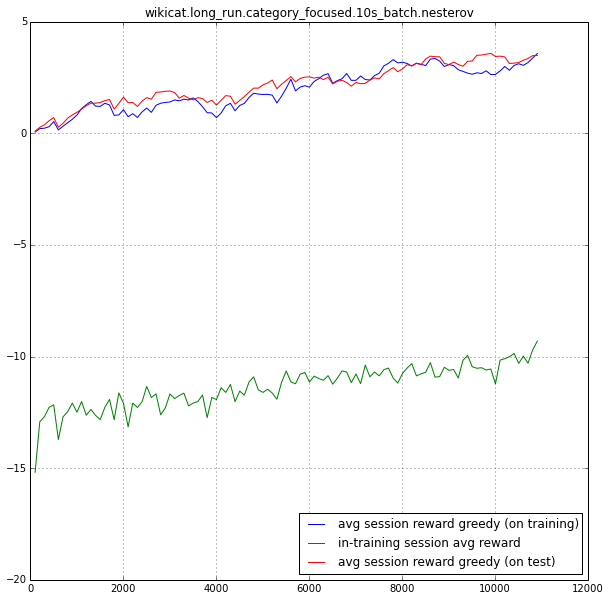

epoch 11000,loss 0.32441, greed 0.29375, rewards: ( train -10.23227, det_train 3.57871) 
rec 0.323 reg 0.001
epoch 11100,loss 0.57494, greed 0.29456, rewards: ( train -9.52971, det_train 3.56084) 
rec 0.574 reg 0.001
epoch 11200,loss 0.32205, greed 0.29536, rewards: ( train -10.21213, det_train 3.64476) 
rec 0.321 reg 0.001
epoch 11300,loss 0.39436, greed 0.29616, rewards: ( train -9.85257, det_train 3.66028) 
rec 0.393 reg 0.001
epoch 11400,loss 0.37773, greed 0.29697, rewards: ( train -10.07959, det_train 3.48425) 
rec 0.377 reg 0.001
epoch 11500,loss 0.38822, greed 0.29777, rewards: ( train -9.66250, det_train 3.36583) 
rec 0.387 reg 0.001
epoch 11600,loss 0.30907, greed 0.29857, rewards: ( train -9.76308, det_train 3.37925) 
rec 0.308 reg 0.001
epoch 11700,loss 0.32035, greed 0.29937, rewards: ( train -10.28219, det_train 3.48132) 
rec 0.319 reg 0.001
epoch 11800,loss 0.34618, greed 0.30017, rewards: ( train -10.32486, det_train 3.23319) 
rec 0.345 reg 0.001
epoch 11900,loss 0.3971

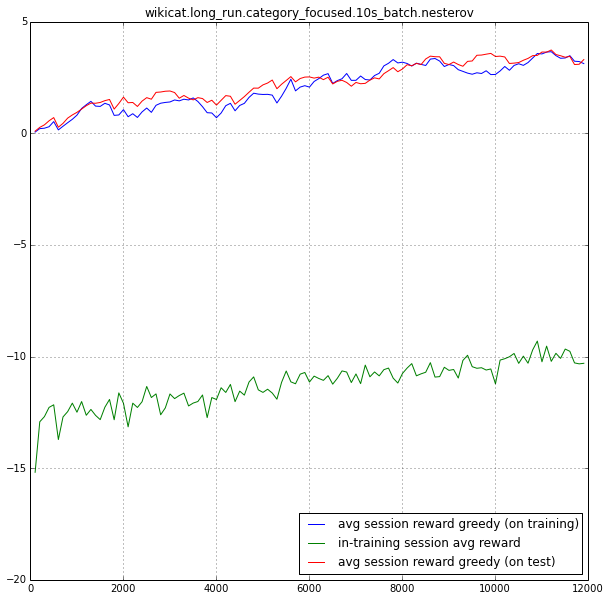

epoch 12000,loss 0.31498, greed 0.30177, rewards: ( train -10.17911, det_train 3.12788) 
rec 0.314 reg 0.001
epoch 12100,loss 0.32321, greed 0.30257, rewards: ( train -9.48288, det_train 3.29509) 
rec 0.322 reg 0.001
epoch 12200,loss 0.27909, greed 0.30337, rewards: ( train -9.96497, det_train 2.98559) 
rec 0.278 reg 0.001
epoch 12300,loss 0.38281, greed 0.30416, rewards: ( train -9.66214, det_train 3.07703) 
rec 0.382 reg 0.001
epoch 12400,loss 0.34743, greed 0.30496, rewards: ( train -9.25869, det_train 3.09932) 
rec 0.346 reg 0.001
epoch 12500,loss 0.30097, greed 0.30575, rewards: ( train -9.56349, det_train 3.12939) 
rec 0.300 reg 0.001
epoch 12600,loss 0.41223, greed 0.30655, rewards: ( train -9.22797, det_train 3.37645) 
rec 0.411 reg 0.001
epoch 12700,loss 0.41469, greed 0.30734, rewards: ( train -9.98445, det_train 3.40881) 
rec 0.414 reg 0.001
epoch 12800,loss 0.38465, greed 0.30813, rewards: ( train -9.72794, det_train 3.38793) 
rec 0.383 reg 0.001
epoch 12900,loss 0.51706, g

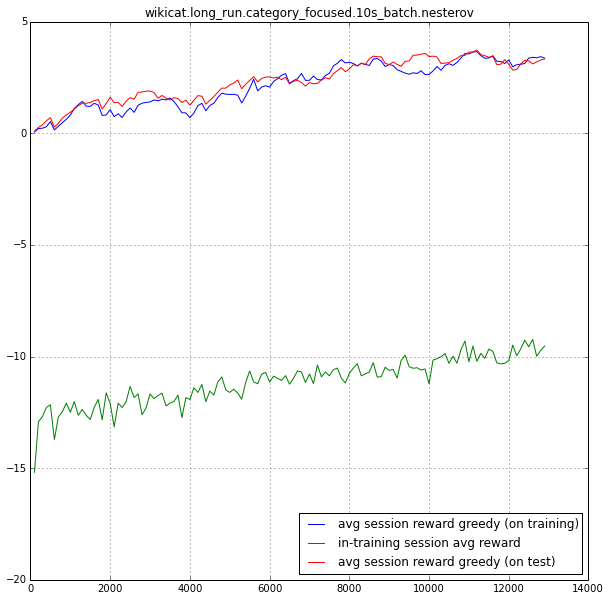

epoch 13000,loss 0.28710, greed 0.30971, rewards: ( train -9.55904, det_train 3.37522) 
rec 0.286 reg 0.001
epoch 13100,loss 0.35491, greed 0.31050, rewards: ( train -9.44968, det_train 3.50770) 
rec 0.354 reg 0.001
epoch 13200,loss 0.37192, greed 0.31129, rewards: ( train -9.79251, det_train 3.45693) 
rec 0.371 reg 0.001
epoch 13300,loss 0.38911, greed 0.31208, rewards: ( train -9.46538, det_train 3.49124) 
rec 0.388 reg 0.001
epoch 13400,loss 0.55260, greed 0.31287, rewards: ( train -9.47686, det_train 3.60211) 
rec 0.551 reg 0.001
epoch 13500,loss 0.49031, greed 0.31366, rewards: ( train -9.27770, det_train 3.48190) 
rec 0.489 reg 0.001
epoch 13600,loss 0.33164, greed 0.31444, rewards: ( train -9.36074, det_train 3.33371) 
rec 0.330 reg 0.001
epoch 13700,loss 0.35188, greed 0.31523, rewards: ( train -9.64102, det_train 3.36034) 
rec 0.351 reg 0.001
epoch 13800,loss 0.35156, greed 0.31601, rewards: ( train -9.43213, det_train 3.30431) 
rec 0.350 reg 0.001
epoch 13900,loss 0.30972, gr

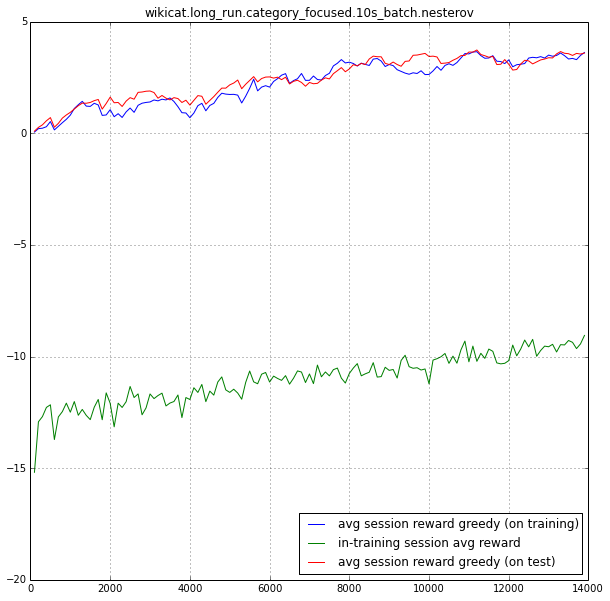

epoch 14000,loss 0.61894, greed 0.31758, rewards: ( train -9.52448, det_train 3.62449) 
rec 0.618 reg 0.001
epoch 14100,loss 0.32425, greed 0.31836, rewards: ( train -9.40254, det_train 3.11204) 
rec 0.323 reg 0.001
epoch 14200,loss 0.69224, greed 0.31914, rewards: ( train -9.36743, det_train 3.21083) 
rec 0.691 reg 0.001
epoch 14300,loss 0.28144, greed 0.31992, rewards: ( train -8.92982, det_train 3.24975) 
rec 0.280 reg 0.001
epoch 14400,loss 0.33174, greed 0.32070, rewards: ( train -9.60144, det_train 3.26478) 
rec 0.331 reg 0.001
epoch 14500,loss 0.57430, greed 0.32148, rewards: ( train -9.42414, det_train 3.05830) 
rec 0.573 reg 0.001
epoch 14600,loss 0.37375, greed 0.32226, rewards: ( train -9.23367, det_train 3.10247) 
rec 0.373 reg 0.001
epoch 14700,loss 0.43346, greed 0.32304, rewards: ( train -9.11869, det_train 3.13222) 
rec 0.432 reg 0.001
epoch 14800,loss 0.23153, greed 0.32381, rewards: ( train -9.60535, det_train 2.90900) 
rec 0.230 reg 0.001
epoch 14900,loss 0.34385, gr

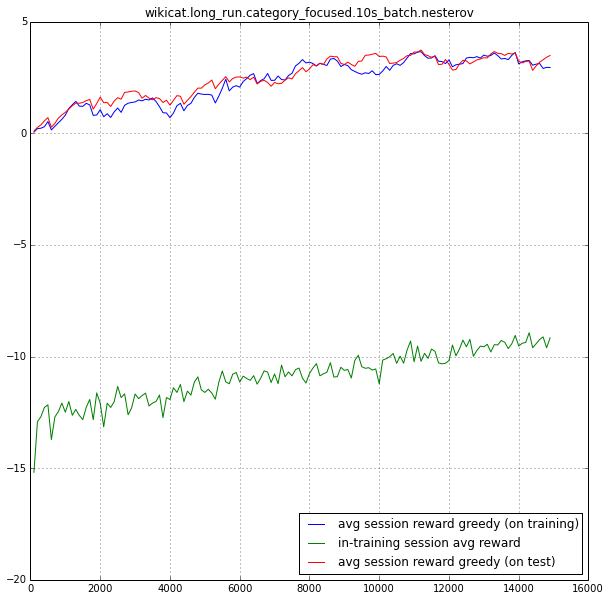

epoch 15000,loss 0.25054, greed 0.32536, rewards: ( train -9.20945, det_train 2.95229) 
rec 0.249 reg 0.001
epoch 15100,loss 0.31557, greed 0.32614, rewards: ( train -8.81508, det_train 2.87706) 
rec 0.314 reg 0.001
epoch 15200,loss 0.28631, greed 0.32691, rewards: ( train -8.83319, det_train 3.04935) 
rec 0.285 reg 0.001
epoch 15300,loss 0.32296, greed 0.32768, rewards: ( train -9.19255, det_train 3.22442) 
rec 0.322 reg 0.001
epoch 15400,loss 0.54376, greed 0.32846, rewards: ( train -9.64027, det_train 3.35198) 
rec 0.543 reg 0.001
epoch 15500,loss 0.56693, greed 0.32923, rewards: ( train -9.61933, det_train 3.16678) 
rec 0.566 reg 0.001
epoch 15600,loss 0.32789, greed 0.33000, rewards: ( train -8.75607, det_train 3.23010) 
rec 0.327 reg 0.001
epoch 15700,loss 0.32593, greed 0.33077, rewards: ( train -9.19813, det_train 3.24709) 
rec 0.325 reg 0.001
epoch 15800,loss 0.40953, greed 0.33154, rewards: ( train -9.62938, det_train 3.54238) 
rec 0.408 reg 0.001
epoch 15900,loss 0.41089, gr

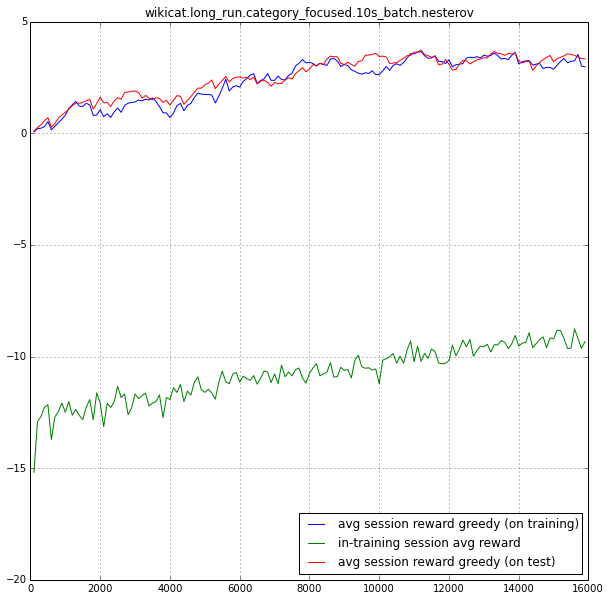

epoch 16000,loss 0.37455, greed 0.33307, rewards: ( train -9.10245, det_train 2.98633) 
rec 0.373 reg 0.001
epoch 16100,loss 0.50603, greed 0.33384, rewards: ( train -9.38165, det_train 3.00770) 
rec 0.505 reg 0.001
epoch 16200,loss 0.43799, greed 0.33460, rewards: ( train -8.78833, det_train 2.98693) 
rec 0.437 reg 0.001
epoch 16300,loss 0.52818, greed 0.33537, rewards: ( train -9.07156, det_train 3.00823) 
rec 0.527 reg 0.001
epoch 16400,loss 0.34094, greed 0.33613, rewards: ( train -8.72767, det_train 3.04741) 
rec 0.340 reg 0.001
epoch 16500,loss 0.88735, greed 0.33690, rewards: ( train -8.22622, det_train 3.23267) 
rec 0.886 reg 0.001
epoch 16600,loss 0.76141, greed 0.33766, rewards: ( train -9.77329, det_train 2.66940) 
rec 0.760 reg 0.001
epoch 16700,loss 0.51844, greed 0.33842, rewards: ( train -8.98630, det_train 2.40246) 
rec 0.517 reg 0.001
epoch 16800,loss 1.01828, greed 0.33918, rewards: ( train -8.80959, det_train 2.82222) 
rec 1.017 reg 0.001
epoch 16900,loss 0.30767, gr

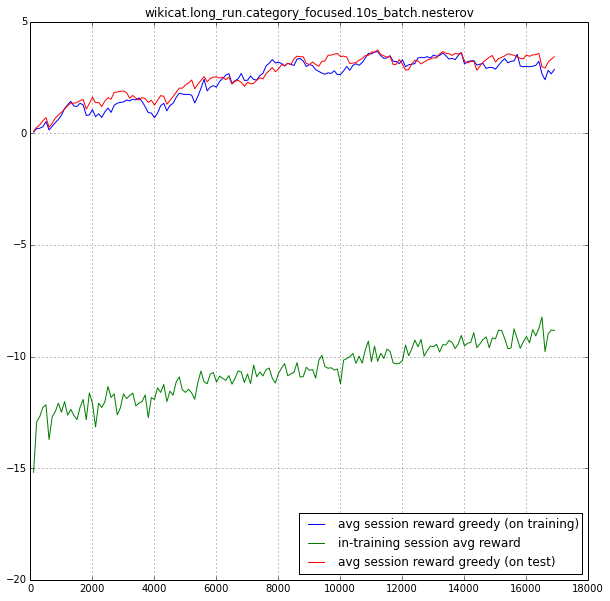

epoch 17000,loss 0.57837, greed 0.34070, rewards: ( train -9.05385, det_train 2.86300) 
rec 0.577 reg 0.001
epoch 17100,loss 0.47461, greed 0.34146, rewards: ( train -8.90330, det_train 2.87670) 
rec 0.473 reg 0.001
epoch 17200,loss 0.48422, greed 0.34222, rewards: ( train -9.07034, det_train 2.94903) 
rec 0.483 reg 0.001
epoch 17300,loss 0.60814, greed 0.34298, rewards: ( train -9.20998, det_train 2.94412) 
rec 0.607 reg 0.001
epoch 17400,loss 0.46307, greed 0.34373, rewards: ( train -8.47834, det_train 2.73971) 
rec 0.462 reg 0.001
epoch 17500,loss 0.55034, greed 0.34449, rewards: ( train -8.72619, det_train 2.49574) 
rec 0.549 reg 0.001
epoch 17600,loss 0.43808, greed 0.34524, rewards: ( train -9.03101, det_train 2.54617) 
rec 0.437 reg 0.001
epoch 17700,loss 0.43020, greed 0.34600, rewards: ( train -8.60325, det_train 2.57155) 
rec 0.429 reg 0.001
epoch 17800,loss 0.55102, greed 0.34675, rewards: ( train -8.44963, det_train 2.66439) 
rec 0.550 reg 0.001
epoch 17900,loss 0.23068, gr

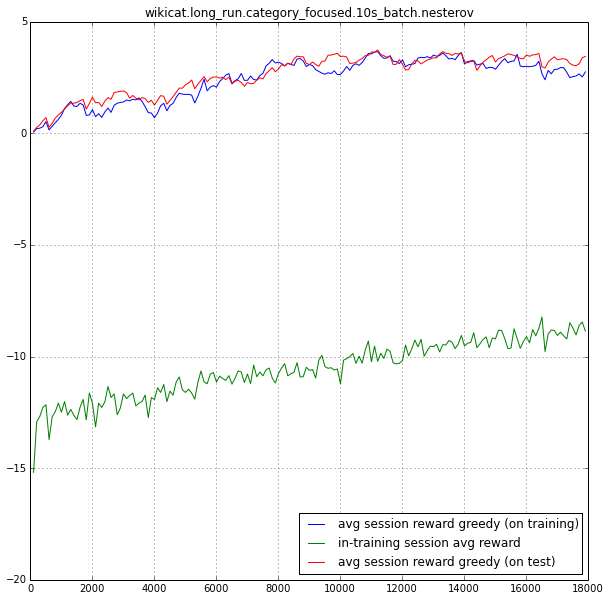

epoch 18000,loss 0.38894, greed 0.34826, rewards: ( train -8.07577, det_train 2.75516) 
rec 0.388 reg 0.001
epoch 18100,loss 0.40524, greed 0.34901, rewards: ( train -8.10860, det_train 2.90964) 
rec 0.404 reg 0.001
epoch 18200,loss 0.50880, greed 0.34976, rewards: ( train -9.17081, det_train 3.15868) 
rec 0.508 reg 0.001
epoch 18300,loss 0.38759, greed 0.35051, rewards: ( train -8.70649, det_train 3.01281) 
rec 0.386 reg 0.001
epoch 18400,loss 0.44083, greed 0.35126, rewards: ( train -8.83713, det_train 3.09153) 
rec 0.440 reg 0.001
epoch 18500,loss 0.71995, greed 0.35201, rewards: ( train -8.97748, det_train 3.11238) 
rec 0.719 reg 0.001
epoch 18600,loss 0.22389, greed 0.35275, rewards: ( train -8.40655, det_train 2.93114) 
rec 0.223 reg 0.001
epoch 18700,loss 0.46327, greed 0.35350, rewards: ( train -8.89422, det_train 3.15803) 
rec 0.462 reg 0.001
epoch 18800,loss 0.64685, greed 0.35425, rewards: ( train -7.07915, det_train 3.13222) 
rec 0.646 reg 0.001
epoch 18900,loss 0.64598, gr

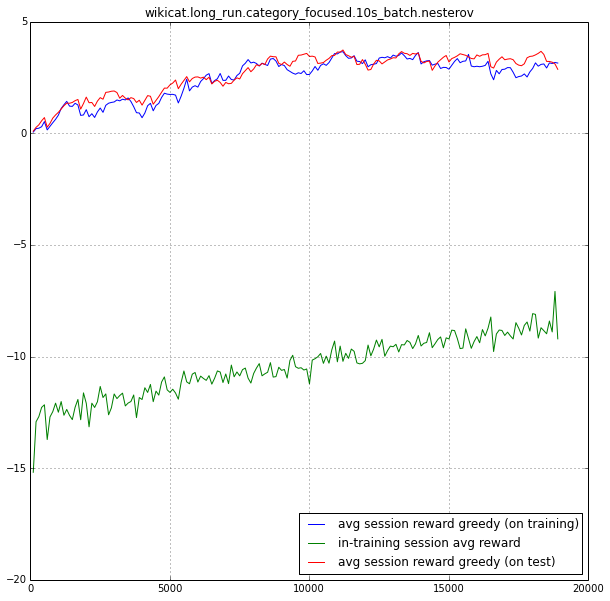

epoch 19000,loss 0.42031, greed 0.35574, rewards: ( train -8.71394, det_train 3.15110) 
rec 0.419 reg 0.001
epoch 19100,loss 0.57401, greed 0.35648, rewards: ( train -8.37353, det_train 3.27599) 
rec 0.573 reg 0.001
epoch 19200,loss 0.36059, greed 0.35722, rewards: ( train -8.59185, det_train 3.19839) 
rec 0.359 reg 0.001
epoch 19300,loss 0.63107, greed 0.35797, rewards: ( train -9.01025, det_train 3.15855) 
rec 0.630 reg 0.001
epoch 19400,loss 0.45657, greed 0.35871, rewards: ( train -8.10397, det_train 3.03270) 
rec 0.455 reg 0.001
epoch 19500,loss 0.32623, greed 0.35945, rewards: ( train -8.25891, det_train 3.08943) 
rec 0.325 reg 0.001
epoch 19600,loss 0.45514, greed 0.36019, rewards: ( train -8.23040, det_train 3.22048) 
rec 0.454 reg 0.001
epoch 19700,loss 0.50890, greed 0.36093, rewards: ( train -7.82007, det_train 3.23844) 
rec 0.508 reg 0.001
epoch 19800,loss 0.45046, greed 0.36167, rewards: ( train -8.11486, det_train 3.23459) 
rec 0.449 reg 0.001
epoch 19900,loss 0.41210, gr

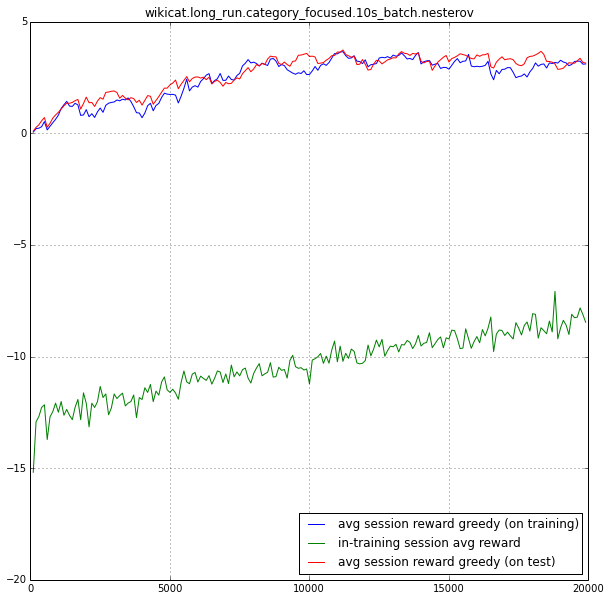

epoch 20000,loss 0.55209, greed 0.36314, rewards: ( train -8.80880, det_train 3.11102) 
rec 0.551 reg 0.001
epoch 20100,loss 0.53703, greed 0.36388, rewards: ( train -8.15056, det_train 2.87992) 
rec 0.536 reg 0.001
epoch 20200,loss 0.49419, greed 0.36461, rewards: ( train -8.38083, det_train 2.99193) 
rec 0.493 reg 0.001
epoch 20300,loss 0.56420, greed 0.36535, rewards: ( train -8.36145, det_train 3.24273) 
rec 0.563 reg 0.001
epoch 20400,loss 0.81029, greed 0.36608, rewards: ( train -8.63768, det_train 3.50846) 
rec 0.809 reg 0.001
epoch 20500,loss 0.42886, greed 0.36682, rewards: ( train -7.90603, det_train 3.45761) 
rec 0.428 reg 0.001
epoch 20600,loss 0.50681, greed 0.36755, rewards: ( train -8.45242, det_train 3.48185) 
rec 0.506 reg 0.001
epoch 20700,loss 0.47481, greed 0.36828, rewards: ( train -8.49237, det_train 3.23367) 
rec 0.474 reg 0.001
epoch 20800,loss 0.65811, greed 0.36901, rewards: ( train -8.52119, det_train 3.29030) 
rec 0.657 reg 0.001
epoch 20900,loss 0.59424, gr

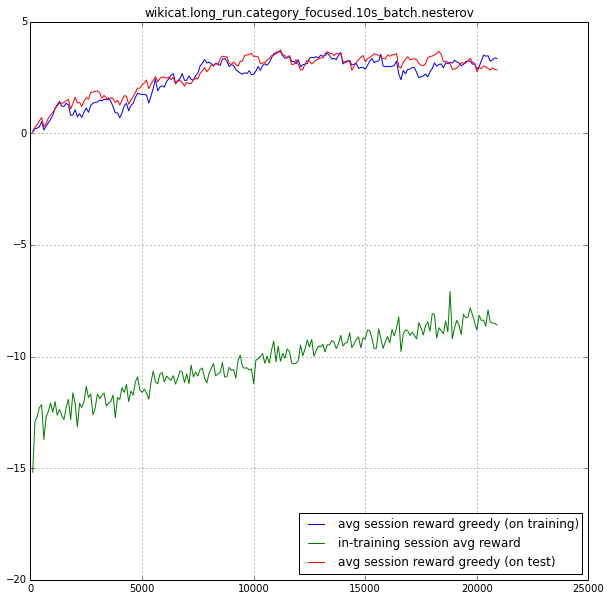

epoch 21000,loss 0.52190, greed 0.37047, rewards: ( train -8.19802, det_train 3.35314) 
rec 0.521 reg 0.001
epoch 21100,loss 0.41462, greed 0.37120, rewards: ( train -7.79285, det_train 3.50783) 
rec 0.413 reg 0.001
epoch 21200,loss 0.44610, greed 0.37193, rewards: ( train -8.20654, det_train 3.51705) 
rec 0.445 reg 0.001
epoch 21300,loss 0.38666, greed 0.37266, rewards: ( train -7.67906, det_train 3.47534) 
rec 0.385 reg 0.001
epoch 21400,loss 0.43911, greed 0.37339, rewards: ( train -8.77848, det_train 3.60781) 
rec 0.438 reg 0.001
epoch 21500,loss 0.46095, greed 0.37411, rewards: ( train -7.89649, det_train 3.54703) 
rec 0.460 reg 0.001
epoch 21600,loss 0.33823, greed 0.37484, rewards: ( train -8.06716, det_train 3.49232) 
rec 0.337 reg 0.001
epoch 21700,loss 0.36610, greed 0.37556, rewards: ( train -7.92047, det_train 3.57309) 
rec 0.365 reg 0.001
epoch 21800,loss 0.53289, greed 0.37629, rewards: ( train -8.09791, det_train 3.30578) 
rec 0.532 reg 0.001
epoch 21900,loss 0.43513, gr

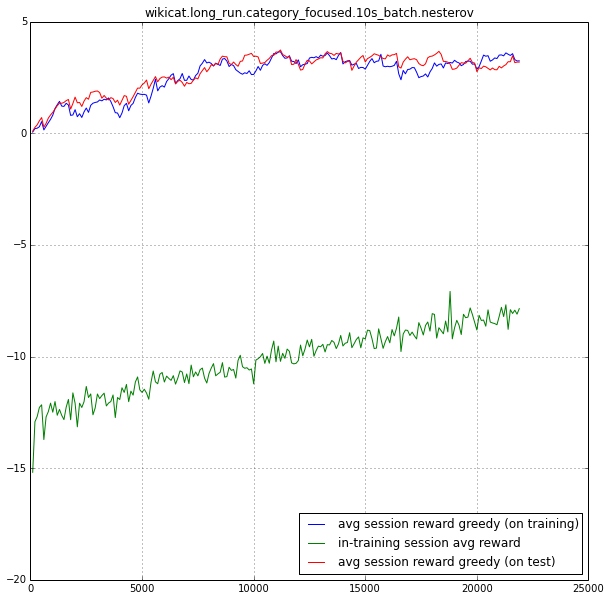

epoch 22000,loss 0.41767, greed 0.37773, rewards: ( train -8.19034, det_train 3.25068) 
rec 0.416 reg 0.001
epoch 22100,loss 0.46079, greed 0.37845, rewards: ( train -8.31579, det_train 3.10562) 
rec 0.460 reg 0.001
epoch 22200,loss 0.35213, greed 0.37918, rewards: ( train -8.04045, det_train 3.02505) 
rec 0.351 reg 0.001
epoch 22300,loss 0.29387, greed 0.37990, rewards: ( train -8.23203, det_train 3.05255) 
rec 0.293 reg 0.001
epoch 22400,loss 0.42611, greed 0.38062, rewards: ( train -7.98973, det_train 3.27729) 
rec 0.425 reg 0.001
epoch 22500,loss 0.34049, greed 0.38134, rewards: ( train -7.61171, det_train 3.41956) 
rec 0.339 reg 0.001
epoch 22600,loss 0.37478, greed 0.38205, rewards: ( train -6.68640, det_train 3.28761) 
rec 0.374 reg 0.001
epoch 22700,loss 0.50423, greed 0.38277, rewards: ( train -7.60743, det_train 3.04885) 
rec 0.503 reg 0.001
epoch 22800,loss 0.46343, greed 0.38349, rewards: ( train -8.04776, det_train 3.12396) 
rec 0.462 reg 0.001
epoch 22900,loss 0.58446, gr

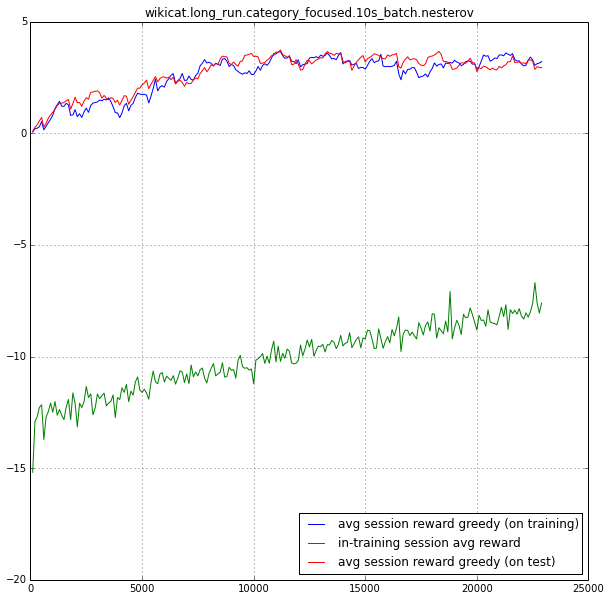

epoch 23000,loss 0.38474, greed 0.38492, rewards: ( train -7.33365, det_train 3.21641) 
rec 0.384 reg 0.001
epoch 23100,loss 0.41302, greed 0.38563, rewards: ( train -7.89126, det_train 3.33477) 
rec 0.412 reg 0.001
epoch 23200,loss 0.41486, greed 0.38635, rewards: ( train -7.87834, det_train 3.30129) 
rec 0.414 reg 0.001
epoch 23300,loss 0.51494, greed 0.38706, rewards: ( train -7.84314, det_train 3.27116) 
rec 0.514 reg 0.001
epoch 23400,loss 0.42593, greed 0.38777, rewards: ( train -7.78813, det_train 3.05405) 
rec 0.425 reg 0.001
epoch 23500,loss 0.46638, greed 0.38849, rewards: ( train -7.66849, det_train 3.22864) 
rec 0.465 reg 0.001
epoch 23600,loss 0.34018, greed 0.38920, rewards: ( train -7.57872, det_train 3.53578) 
rec 0.339 reg 0.001
epoch 23700,loss 0.63198, greed 0.38991, rewards: ( train -8.90386, det_train 3.86220) 
rec 0.631 reg 0.001
epoch 23800,loss 0.61650, greed 0.39062, rewards: ( train -8.02286, det_train 3.63598) 
rec 0.615 reg 0.001
epoch 23900,loss 0.47111, gr

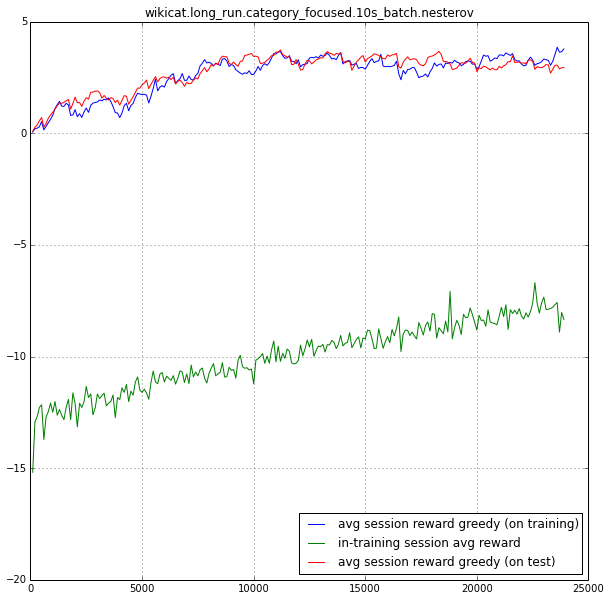

epoch 24000,loss 0.40701, greed 0.39203, rewards: ( train -7.50273, det_train 3.78614) 
rec 0.406 reg 0.001
epoch 24100,loss 0.49866, greed 0.39274, rewards: ( train -7.62006, det_train 3.78753) 
rec 0.497 reg 0.001
epoch 24200,loss 0.30581, greed 0.39345, rewards: ( train -7.76655, det_train 3.75878) 
rec 0.305 reg 0.001
epoch 24300,loss 0.28109, greed 0.39416, rewards: ( train -7.76218, det_train 3.79290) 
rec 0.280 reg 0.001
epoch 24400,loss 0.33795, greed 0.39486, rewards: ( train -6.81610, det_train 3.87361) 
rec 0.337 reg 0.001
epoch 24500,loss 0.37975, greed 0.39557, rewards: ( train -7.85934, det_train 3.69625) 
rec 0.379 reg 0.001
epoch 24600,loss 0.43008, greed 0.39627, rewards: ( train -7.91354, det_train 3.72662) 
rec 0.429 reg 0.001
epoch 24700,loss 0.50911, greed 0.39697, rewards: ( train -7.53868, det_train 3.68396) 
rec 0.508 reg 0.001
epoch 24800,loss 0.48262, greed 0.39768, rewards: ( train -7.57633, det_train 3.74556) 
rec 0.481 reg 0.001
epoch 24900,loss 0.37680, gr

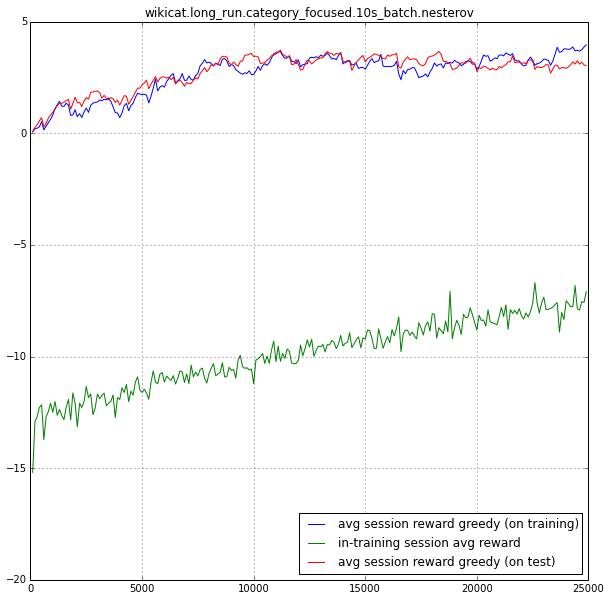

snapshot saved
epoch 25000,loss 0.42521, greed 0.39908, rewards: ( train -8.08245, det_train 3.96391) 
rec 0.424 reg 0.001
epoch 25100,loss 0.50004, greed 0.39978, rewards: ( train -7.99662, det_train 3.95752) 
rec 0.499 reg 0.001
epoch 25200,loss 0.44596, greed 0.40048, rewards: ( train -7.08798, det_train 3.76177) 
rec 0.445 reg 0.001
epoch 25300,loss 0.57402, greed 0.40118, rewards: ( train -7.29913, det_train 3.79559) 
rec 0.573 reg 0.001
epoch 25400,loss 0.48598, greed 0.40188, rewards: ( train -7.59665, det_train 3.64603) 
rec 0.485 reg 0.001
epoch 25500,loss 0.41890, greed 0.40258, rewards: ( train -7.20330, det_train 3.69143) 
rec 0.418 reg 0.001
epoch 25600,loss 0.47306, greed 0.40327, rewards: ( train -6.90281, det_train 3.60228) 
rec 0.472 reg 0.001
epoch 25700,loss 0.39815, greed 0.40397, rewards: ( train -7.20278, det_train 3.66206) 
rec 0.397 reg 0.001
epoch 25800,loss 0.39408, greed 0.40466, rewards: ( train -7.30725, det_train 3.56585) 
rec 0.393 reg 0.001
epoch 25900,l

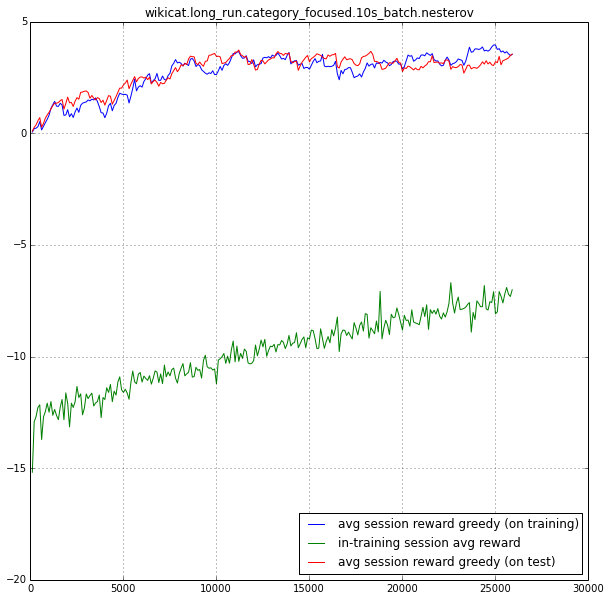

epoch 26000,loss 0.53098, greed 0.40605, rewards: ( train -5.51916, det_train 3.54034) 
rec 0.530 reg 0.001
epoch 26100,loss 0.63248, greed 0.40675, rewards: ( train -8.99555, det_train 3.24630) 
rec 0.631 reg 0.001
epoch 26200,loss 0.57022, greed 0.40744, rewards: ( train -7.15257, det_train 3.12167) 
rec 0.569 reg 0.001
epoch 26300,loss 0.50786, greed 0.40813, rewards: ( train -7.12749, det_train 3.09951) 
rec 0.507 reg 0.001
epoch 26400,loss 0.63194, greed 0.40882, rewards: ( train -7.45783, det_train 3.11956) 
rec 0.631 reg 0.001
epoch 26500,loss 0.77851, greed 0.40951, rewards: ( train -7.34616, det_train 2.88760) 
rec 0.777 reg 0.001
epoch 26600,loss 0.30323, greed 0.41020, rewards: ( train -6.65856, det_train 2.76884) 
rec 0.302 reg 0.001
epoch 26700,loss 0.36706, greed 0.41089, rewards: ( train -5.59126, det_train 2.94196) 
rec 0.366 reg 0.001
epoch 26800,loss 0.45289, greed 0.41158, rewards: ( train -3.45698, det_train 2.72776) 
rec 0.452 reg 0.001
epoch 26900,loss 0.45628, gr

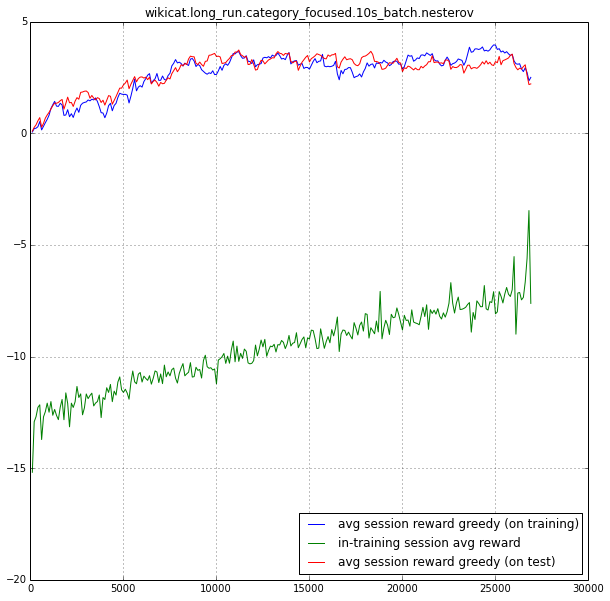

epoch 27000,loss 0.67630, greed 0.41296, rewards: ( train -7.46340, det_train 2.50949) 
rec 0.675 reg 0.001
epoch 27100,loss 0.59921, greed 0.41365, rewards: ( train -7.22686, det_train 2.57854) 
rec 0.598 reg 0.001
epoch 27200,loss 0.64897, greed 0.41433, rewards: ( train -7.45856, det_train 2.59068) 
rec 0.648 reg 0.001
epoch 27300,loss 0.57581, greed 0.41502, rewards: ( train -7.51365, det_train 2.58162) 
rec 0.575 reg 0.001
epoch 27400,loss 0.56946, greed 0.41570, rewards: ( train -6.91250, det_train 2.58345) 
rec 0.568 reg 0.001
epoch 27500,loss 0.56860, greed 0.41639, rewards: ( train -7.91269, det_train 2.66511) 
rec 0.567 reg 0.001
epoch 27600,loss 0.36782, greed 0.41707, rewards: ( train -6.74851, det_train 2.69860) 
rec 0.367 reg 0.001
epoch 27700,loss 0.58703, greed 0.41775, rewards: ( train -6.91432, det_train 2.81874) 
rec 0.586 reg 0.001
epoch 27800,loss 0.61019, greed 0.41843, rewards: ( train -7.27050, det_train 2.50686) 
rec 0.609 reg 0.001
epoch 27900,loss 0.51501, gr

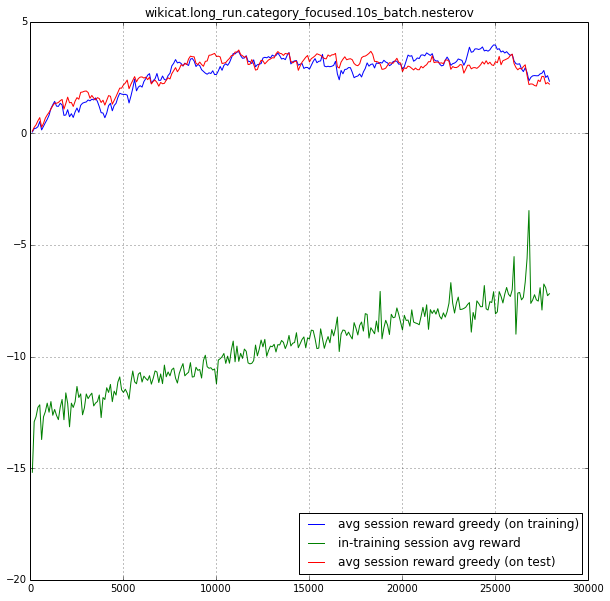

epoch 28000,loss 0.63993, greed 0.41979, rewards: ( train -6.76756, det_train 2.33756) 
rec 0.639 reg 0.001
epoch 28100,loss 0.56331, greed 0.42047, rewards: ( train -7.59306, det_train 2.41380) 
rec 0.562 reg 0.001
epoch 28200,loss 0.45632, greed 0.42115, rewards: ( train -6.22566, det_train 2.58242) 
rec 0.455 reg 0.001
epoch 28300,loss 0.78898, greed 0.42183, rewards: ( train -6.79533, det_train 2.95418) 
rec 0.788 reg 0.001
epoch 28400,loss 0.62463, greed 0.42251, rewards: ( train -6.75774, det_train 2.89876) 
rec 0.623 reg 0.001
epoch 28500,loss 0.56074, greed 0.42319, rewards: ( train -6.62950, det_train 2.90889) 
rec 0.560 reg 0.001
epoch 28600,loss 0.43523, greed 0.42386, rewards: ( train -6.90281, det_train 2.80800) 
rec 0.434 reg 0.001
epoch 28700,loss 0.41250, greed 0.42454, rewards: ( train -6.86127, det_train 2.96720) 
rec 0.411 reg 0.001
epoch 28800,loss 0.57489, greed 0.42521, rewards: ( train -5.67144, det_train 3.25048) 
rec 0.574 reg 0.001
epoch 28900,loss 0.62818, gr

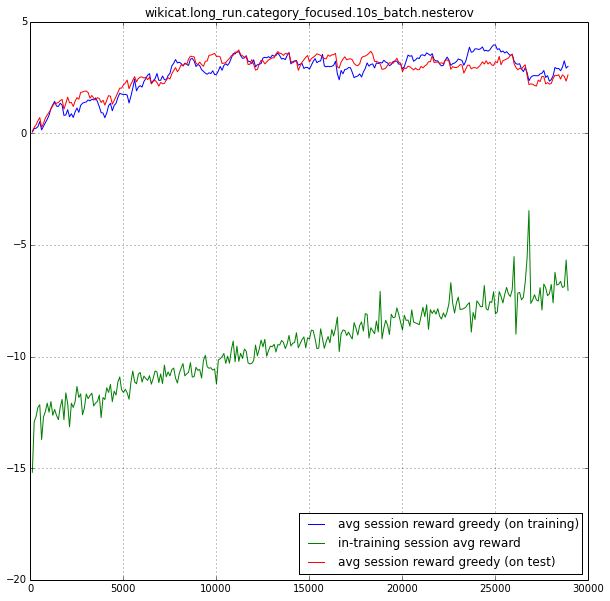

epoch 29000,loss 0.57412, greed 0.42656, rewards: ( train -6.75121, det_train 3.00289) 
rec 0.573 reg 0.001
epoch 29100,loss 0.54862, greed 0.42724, rewards: ( train -7.22778, det_train 2.77260) 
rec 0.547 reg 0.001
epoch 29200,loss 0.34095, greed 0.42791, rewards: ( train -6.51148, det_train 2.97534) 
rec 0.340 reg 0.001
epoch 29300,loss 0.43360, greed 0.42858, rewards: ( train -6.25714, det_train 3.20781) 
rec 0.432 reg 0.001
epoch 29400,loss 0.40238, greed 0.42925, rewards: ( train -6.60276, det_train 3.32702) 
rec 0.401 reg 0.001
epoch 29500,loss 0.45726, greed 0.42992, rewards: ( train -7.18172, det_train 3.17432) 
rec 0.456 reg 0.001
epoch 29600,loss 0.70350, greed 0.43059, rewards: ( train -6.78693, det_train 2.97689) 
rec 0.702 reg 0.001
epoch 29700,loss 0.51351, greed 0.43126, rewards: ( train -6.38544, det_train 2.66920) 
rec 0.512 reg 0.001
epoch 29800,loss 0.31337, greed 0.43193, rewards: ( train -5.91495, det_train 2.75228) 
rec 0.312 reg 0.001
epoch 29900,loss 0.35271, gr

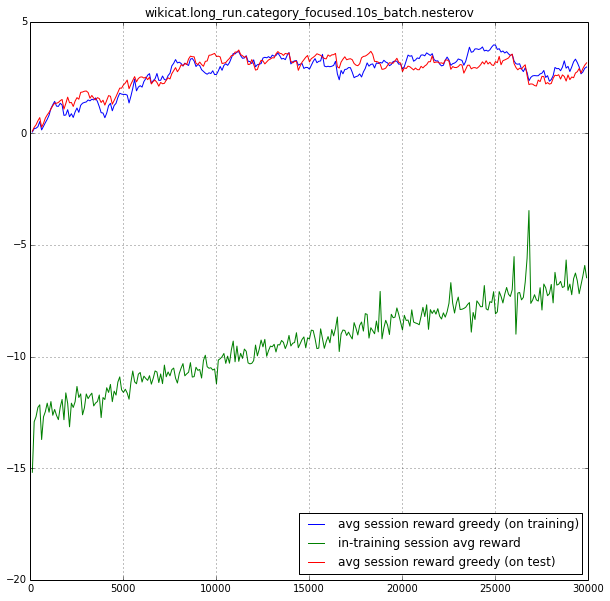

epoch 30000,loss 0.37409, greed 0.43326, rewards: ( train -6.21216, det_train 2.97535) 
rec 0.373 reg 0.001
epoch 30100,loss 0.40665, greed 0.43393, rewards: ( train -6.20328, det_train 3.19781) 
rec 0.405 reg 0.001
epoch 30200,loss 0.36516, greed 0.43460, rewards: ( train -7.18113, det_train 3.38803) 
rec 0.364 reg 0.001
epoch 30300,loss 0.49756, greed 0.43526, rewards: ( train -6.37656, det_train 3.66923) 
rec 0.496 reg 0.001
epoch 30400,loss 0.48127, greed 0.43593, rewards: ( train -6.85219, det_train 3.45231) 
rec 0.480 reg 0.001
epoch 30500,loss 0.38529, greed 0.43659, rewards: ( train -5.79707, det_train 3.42707) 
rec 0.384 reg 0.001
epoch 30600,loss 0.52383, greed 0.43725, rewards: ( train -6.27579, det_train 3.31437) 
rec 0.523 reg 0.001
epoch 30700,loss 0.39677, greed 0.43791, rewards: ( train -6.64679, det_train 3.08293) 
rec 0.396 reg 0.001
epoch 30800,loss 0.58529, greed 0.43858, rewards: ( train -5.83527, det_train 3.37464) 
rec 0.584 reg 0.001
epoch 30900,loss 0.34379, gr

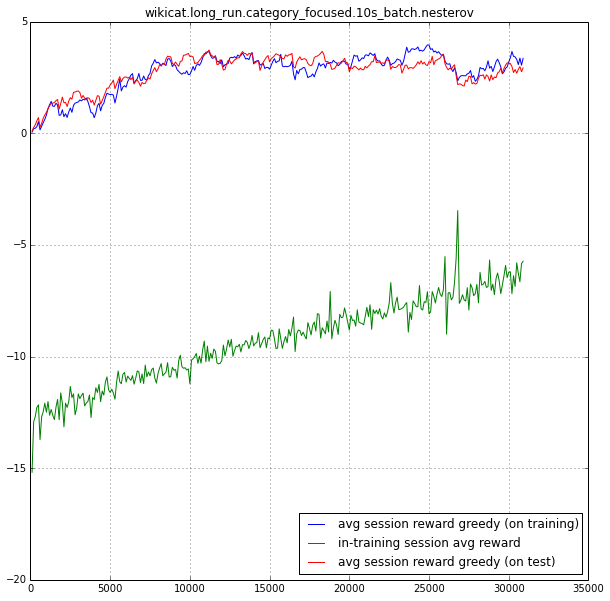

epoch 31000,loss 0.44301, greed 0.43990, rewards: ( train -5.87894, det_train 3.36146) 
rec 0.442 reg 0.001
epoch 31100,loss 0.55370, greed 0.44056, rewards: ( train -5.61506, det_train 3.35531) 
rec 0.552 reg 0.001
epoch 31200,loss 0.54365, greed 0.44122, rewards: ( train -4.08117, det_train 3.45978) 
rec 0.542 reg 0.001
epoch 31300,loss 0.63109, greed 0.44188, rewards: ( train -5.94886, det_train 3.20380) 
rec 0.630 reg 0.001
epoch 31400,loss 0.38707, greed 0.44253, rewards: ( train -6.54473, det_train 3.08342) 
rec 0.386 reg 0.001
epoch 31500,loss 0.44451, greed 0.44319, rewards: ( train -6.10035, det_train 3.27508) 
rec 0.443 reg 0.001
epoch 31600,loss 0.35731, greed 0.44385, rewards: ( train -5.82003, det_train 3.40757) 
rec 0.356 reg 0.001
epoch 31700,loss 0.54496, greed 0.44450, rewards: ( train -6.19511, det_train 3.63681) 
rec 0.544 reg 0.001
epoch 31800,loss 0.49624, greed 0.44516, rewards: ( train -5.85439, det_train 3.49313) 
rec 0.495 reg 0.001
epoch 31900,loss 0.33396, gr

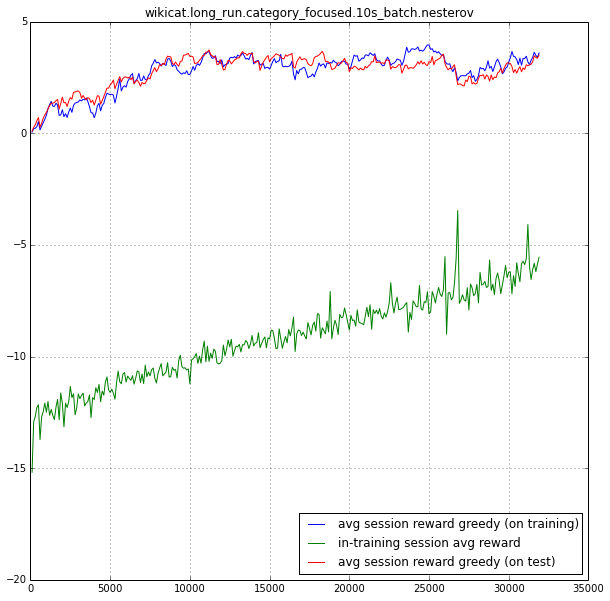

epoch 32000,loss 0.42563, greed 0.44647, rewards: ( train -6.21537, det_train 3.60244) 
rec 0.424 reg 0.001
epoch 32100,loss 0.35909, greed 0.44712, rewards: ( train -5.55877, det_train 3.69219) 
rec 0.358 reg 0.001
epoch 32200,loss 0.51394, greed 0.44777, rewards: ( train -5.99111, det_train 3.72297) 
rec 0.513 reg 0.001
epoch 32300,loss 0.51339, greed 0.44842, rewards: ( train -6.06709, det_train 3.68068) 
rec 0.512 reg 0.001
epoch 32400,loss 0.50458, greed 0.44907, rewards: ( train -5.67531, det_train 3.35261) 
rec 0.503 reg 0.001
epoch 32500,loss 0.51148, greed 0.44973, rewards: ( train -6.11979, det_train 3.43735) 
rec 0.510 reg 0.001
epoch 32600,loss 0.53086, greed 0.45038, rewards: ( train -5.53568, det_train 3.45361) 
rec 0.530 reg 0.001
epoch 32700,loss 0.63844, greed 0.45102, rewards: ( train -5.17049, det_train 3.32825) 
rec 0.637 reg 0.001
epoch 32800,loss 0.48529, greed 0.45167, rewards: ( train -6.31856, det_train 3.38543) 
rec 0.484 reg 0.001
epoch 32900,loss 0.49214, gr

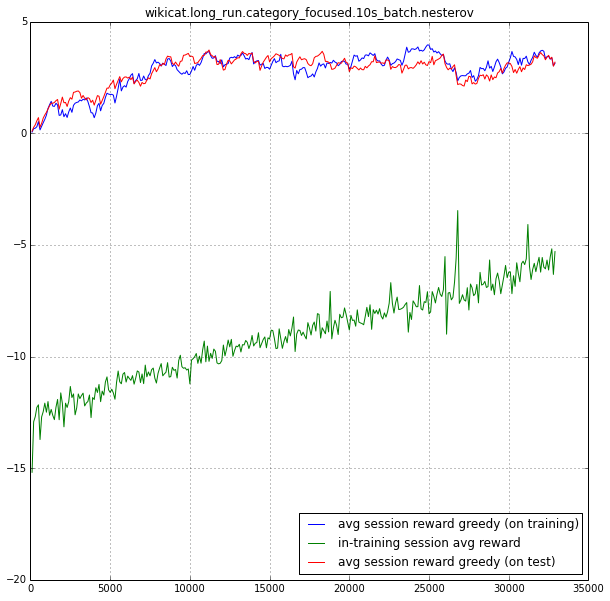

epoch 33000,loss 0.55789, greed 0.45297, rewards: ( train -5.85024, det_train 3.14420) 
rec 0.557 reg 0.001
epoch 33100,loss 0.31504, greed 0.45362, rewards: ( train -5.88846, det_train 3.21978) 
rec 0.314 reg 0.001
epoch 33200,loss 0.52500, greed 0.45426, rewards: ( train -5.80639, det_train 3.48780) 
rec 0.524 reg 0.001
epoch 33300,loss 0.26539, greed 0.45491, rewards: ( train -5.60265, det_train 3.43902) 
rec 0.264 reg 0.001
epoch 33400,loss 0.44848, greed 0.45555, rewards: ( train -5.25442, det_train 3.71512) 
rec 0.447 reg 0.001
epoch 33500,loss 0.55731, greed 0.45620, rewards: ( train -7.31653, det_train 3.75361) 
rec 0.556 reg 0.001
epoch 33600,loss 0.35027, greed 0.45684, rewards: ( train -5.83273, det_train 3.64824) 
rec 0.349 reg 0.001
epoch 33700,loss 0.55764, greed 0.45748, rewards: ( train -6.06543, det_train 3.83342) 
rec 0.556 reg 0.001
epoch 33800,loss 0.38980, greed 0.45812, rewards: ( train -6.03038, det_train 3.87008) 
rec 0.389 reg 0.001
epoch 33900,loss 0.39143, gr

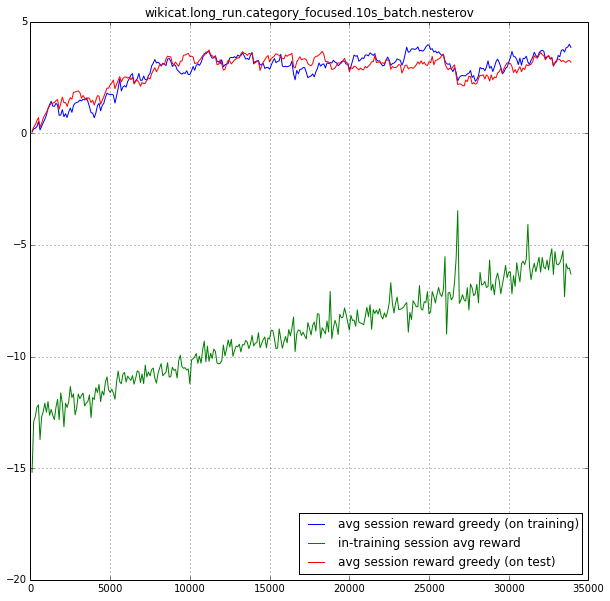

epoch 34000,loss 0.52818, greed 0.45941, rewards: ( train -6.23903, det_train 3.85376) 
rec 0.527 reg 0.001
epoch 34100,loss 0.52159, greed 0.46005, rewards: ( train -4.10508, det_train 3.82839) 
rec 0.520 reg 0.001
epoch 34200,loss 0.60822, greed 0.46069, rewards: ( train -5.71977, det_train 3.42555) 
rec 0.607 reg 0.001
epoch 34300,loss 0.43968, greed 0.46133, rewards: ( train -5.65458, det_train 3.30299) 
rec 0.438 reg 0.001
epoch 34400,loss 0.64542, greed 0.46196, rewards: ( train -5.61671, det_train 3.42269) 
rec 0.644 reg 0.001
epoch 34500,loss 0.45111, greed 0.46260, rewards: ( train -5.42128, det_train 3.40042) 
rec 0.450 reg 0.001
epoch 34600,loss 0.61914, greed 0.46324, rewards: ( train -5.42892, det_train 3.44038) 
rec 0.618 reg 0.001
epoch 34700,loss 0.26883, greed 0.46388, rewards: ( train -6.18817, det_train 3.41634) 
rec 0.268 reg 0.001
epoch 34800,loss 0.37154, greed 0.46451, rewards: ( train -5.67194, det_train 3.37471) 
rec 0.370 reg 0.001
epoch 34900,loss 0.47633, gr

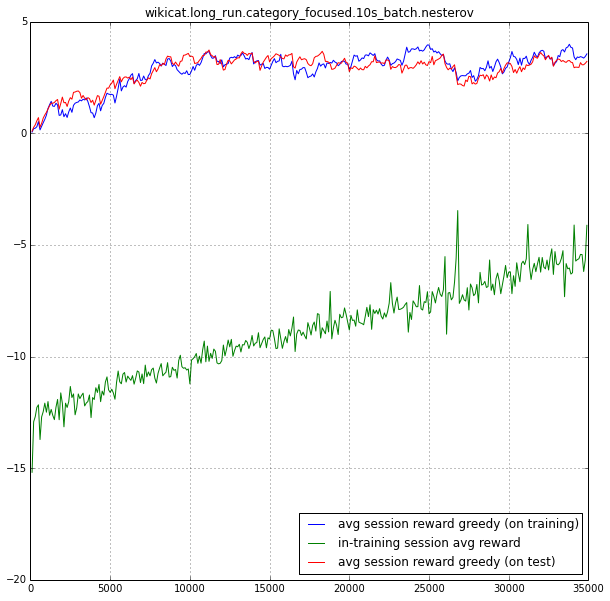

epoch 35000,loss 0.34916, greed 0.46578, rewards: ( train -5.53966, det_train 3.56251) 
rec 0.348 reg 0.001
epoch 35100,loss 0.38471, greed 0.46641, rewards: ( train -6.11705, det_train 3.66626) 
rec 0.383 reg 0.001
epoch 35200,loss 0.47410, greed 0.46705, rewards: ( train -4.54463, det_train 3.62964) 
rec 0.473 reg 0.001
epoch 35300,loss 0.39783, greed 0.46768, rewards: ( train -5.51346, det_train 3.37667) 
rec 0.397 reg 0.001
epoch 35400,loss 0.36516, greed 0.46831, rewards: ( train -5.91202, det_train 3.56901) 
rec 0.364 reg 0.001
epoch 35500,loss 0.41882, greed 0.46894, rewards: ( train -5.65258, det_train 3.64211) 
rec 0.418 reg 0.001
epoch 35600,loss 0.35398, greed 0.46957, rewards: ( train -4.51460, det_train 3.72789) 
rec 0.353 reg 0.001
epoch 35700,loss 0.74453, greed 0.47020, rewards: ( train -5.92969, det_train 3.48511) 
rec 0.743 reg 0.001
epoch 35800,loss 0.66086, greed 0.47083, rewards: ( train -5.62178, det_train 3.43659) 
rec 0.660 reg 0.001
epoch 35900,loss 0.41834, gr

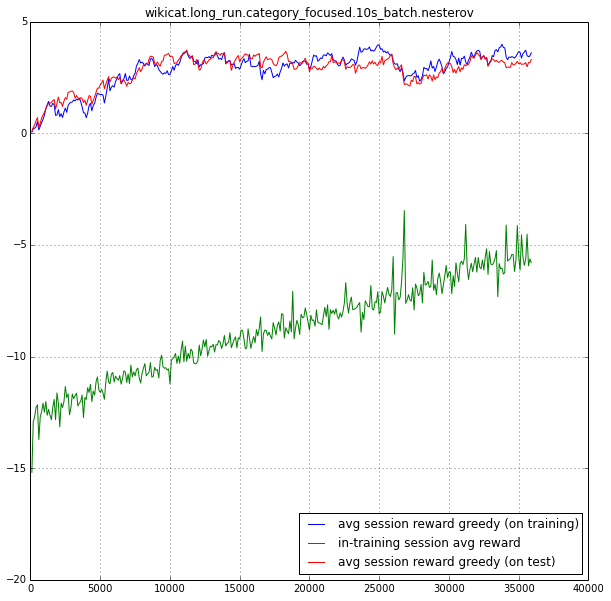

epoch 36000,loss 0.37900, greed 0.47209, rewards: ( train -5.76710, det_train 3.61664) 
rec 0.378 reg 0.001
epoch 36100,loss 0.62954, greed 0.47272, rewards: ( train -5.45559, det_train 3.72498) 
rec 0.628 reg 0.001
epoch 36200,loss 0.56516, greed 0.47335, rewards: ( train -4.65066, det_train 3.57248) 
rec 0.564 reg 0.001
epoch 36300,loss 0.47122, greed 0.47397, rewards: ( train -5.64829, det_train 3.32523) 
rec 0.470 reg 0.001
epoch 36400,loss 0.49722, greed 0.47460, rewards: ( train -5.16887, det_train 3.55271) 
rec 0.496 reg 0.001
epoch 36500,loss 0.42400, greed 0.47522, rewards: ( train -4.76907, det_train 3.70744) 
rec 0.423 reg 0.001
epoch 36600,loss 0.31586, greed 0.47585, rewards: ( train -5.10041, det_train 3.83669) 
rec 0.315 reg 0.001
epoch 36700,loss 0.46444, greed 0.47647, rewards: ( train -5.20373, det_train 4.03302) 
rec 0.463 reg 0.001
epoch 36800,loss 0.56613, greed 0.47709, rewards: ( train -4.84768, det_train 4.09972) 
rec 0.565 reg 0.001
epoch 36900,loss 0.46114, gr

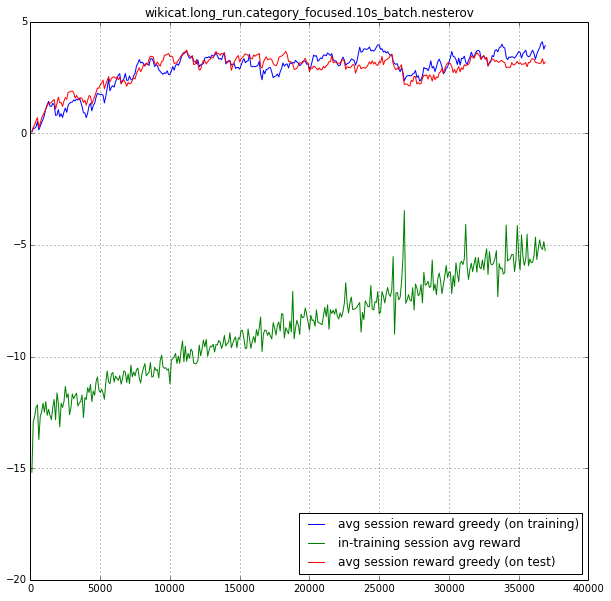

epoch 37000,loss 0.62388, greed 0.47834, rewards: ( train -7.59981, det_train 3.93277) 
rec 0.623 reg 0.001
epoch 37100,loss 0.47692, greed 0.47896, rewards: ( train -6.47844, det_train 3.69950) 
rec 0.476 reg 0.001
epoch 37200,loss 0.44342, greed 0.47958, rewards: ( train -4.40336, det_train 3.66955) 
rec 0.442 reg 0.001
epoch 37300,loss 0.86682, greed 0.48020, rewards: ( train -5.50880, det_train 3.46259) 
rec 0.866 reg 0.001
epoch 37400,loss 0.94255, greed 0.48082, rewards: ( train -5.44072, det_train 3.33633) 
rec 0.941 reg 0.001
epoch 37500,loss 0.55883, greed 0.48144, rewards: ( train -5.94434, det_train 3.42270) 
rec 0.558 reg 0.001
epoch 37600,loss 0.66392, greed 0.48206, rewards: ( train -5.31313, det_train 3.33043) 
rec 0.663 reg 0.001
epoch 37700,loss 0.39311, greed 0.48268, rewards: ( train -5.04711, det_train 3.39739) 
rec 0.392 reg 0.001
epoch 37800,loss 0.65128, greed 0.48329, rewards: ( train -5.14762, det_train 3.48765) 
rec 0.650 reg 0.001
epoch 37900,loss 0.35008, gr

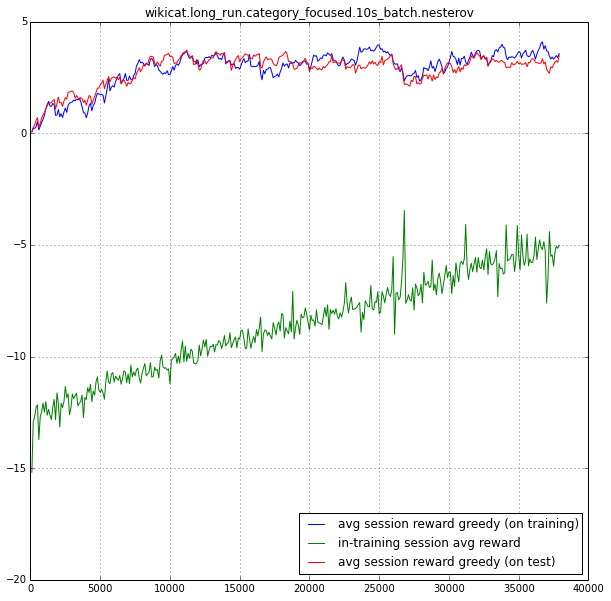

epoch 38000,loss 0.47257, greed 0.48452, rewards: ( train -4.70339, det_train 3.57900) 
rec 0.471 reg 0.001
epoch 38100,loss 0.40814, greed 0.48514, rewards: ( train -5.15943, det_train 3.59110) 
rec 0.407 reg 0.001
epoch 38200,loss 0.49935, greed 0.48575, rewards: ( train -5.53962, det_train 3.73199) 
rec 0.498 reg 0.001
epoch 38300,loss 0.54754, greed 0.48637, rewards: ( train -4.86885, det_train 3.80879) 
rec 0.546 reg 0.001
epoch 38400,loss 0.48131, greed 0.48698, rewards: ( train -4.80216, det_train 3.80791) 
rec 0.480 reg 0.001
epoch 38500,loss 0.33820, greed 0.48759, rewards: ( train -6.25957, det_train 3.81712) 
rec 0.337 reg 0.001
epoch 38600,loss 0.58451, greed 0.48821, rewards: ( train -4.87778, det_train 3.79541) 
rec 0.583 reg 0.001
epoch 38700,loss 0.38685, greed 0.48882, rewards: ( train -4.20722, det_train 3.73587) 
rec 0.386 reg 0.001
epoch 38800,loss 0.41984, greed 0.48943, rewards: ( train -4.20747, det_train 3.85228) 
rec 0.419 reg 0.001
epoch 38900,loss 0.35585, gr

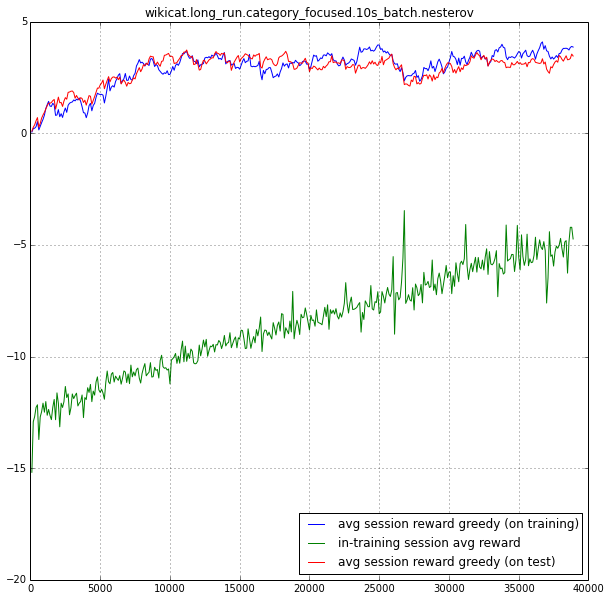

epoch 39000,loss 0.48534, greed 0.49065, rewards: ( train -5.52751, det_train 3.86735) 
rec 0.484 reg 0.001
epoch 39100,loss 0.54762, greed 0.49126, rewards: ( train -4.25549, det_train 3.82061) 
rec 0.546 reg 0.001
epoch 39200,loss 0.38017, greed 0.49187, rewards: ( train -4.57570, det_train 3.98855) 
rec 0.379 reg 0.001
epoch 39300,loss 0.27468, greed 0.49247, rewards: ( train -4.90128, det_train 3.96970) 
rec 0.273 reg 0.001
epoch 39400,loss 0.34986, greed 0.49308, rewards: ( train -4.60167, det_train 4.18273) 
rec 0.349 reg 0.001
epoch 39500,loss 0.42413, greed 0.49369, rewards: ( train -4.82838, det_train 4.22445) 
rec 0.423 reg 0.001
epoch 39600,loss 0.58387, greed 0.49429, rewards: ( train -4.01587, det_train 4.19201) 
rec 0.583 reg 0.001
epoch 39700,loss 0.38743, greed 0.49490, rewards: ( train -4.14067, det_train 4.17281) 
rec 0.386 reg 0.001
epoch 39800,loss 0.38029, greed 0.49550, rewards: ( train -4.33882, det_train 4.04553) 
rec 0.379 reg 0.001
epoch 39900,loss 0.38056, gr

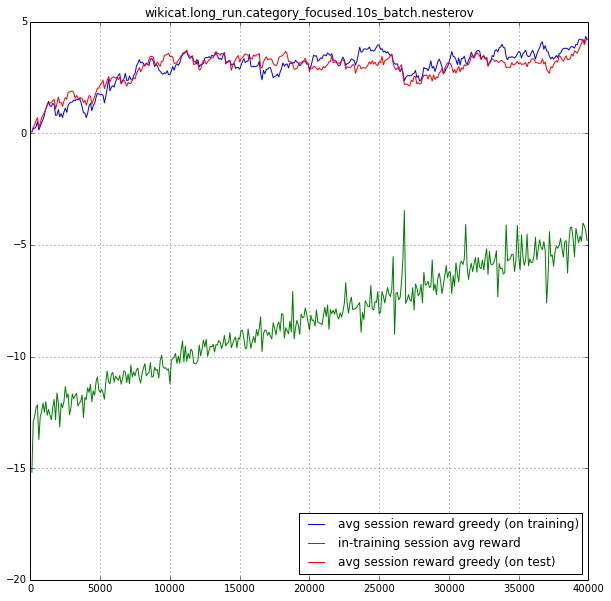

epoch 40000,loss 0.50018, greed 0.49671, rewards: ( train -4.60530, det_train 4.19588) 
rec 0.499 reg 0.001
epoch 40100,loss 0.66578, greed 0.49731, rewards: ( train -6.71630, det_train 4.51629) 
rec 0.665 reg 0.001
epoch 40200,loss 0.63272, greed 0.49792, rewards: ( train -5.50379, det_train 4.42466) 
rec 0.631 reg 0.001
epoch 40300,loss 0.38990, greed 0.49852, rewards: ( train -5.17547, det_train 4.26219) 
rec 0.389 reg 0.001
epoch 40400,loss 0.33301, greed 0.49912, rewards: ( train -5.22536, det_train 4.12597) 
rec 0.332 reg 0.001
epoch 40500,loss 0.48849, greed 0.49972, rewards: ( train -4.77104, det_train 4.22338) 
rec 0.487 reg 0.001
epoch 40600,loss 0.60383, greed 0.50032, rewards: ( train -4.93695, det_train 4.21104) 
rec 0.603 reg 0.001
epoch 40700,loss 0.43758, greed 0.50092, rewards: ( train -4.61562, det_train 4.17994) 
rec 0.436 reg 0.001
epoch 40800,loss 0.58153, greed 0.50152, rewards: ( train -4.51663, det_train 4.22194) 
rec 0.580 reg 0.001
epoch 40900,loss 0.41590, gr

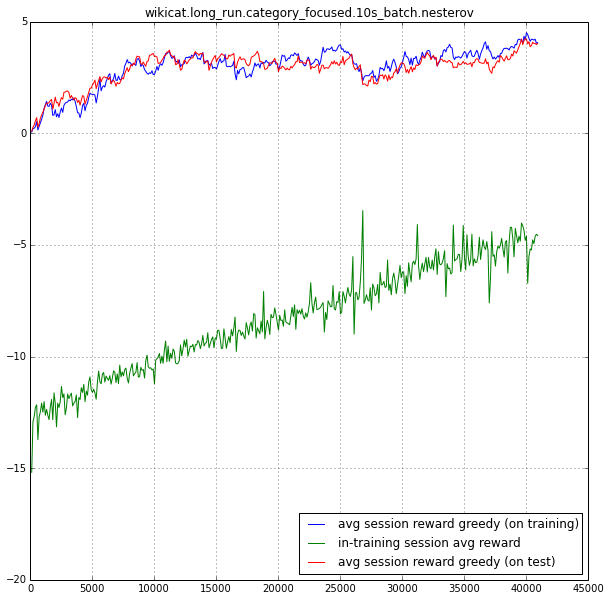

epoch 41000,loss 0.49370, greed 0.50271, rewards: ( train -4.83568, det_train 4.06577) 
rec 0.492 reg 0.001
epoch 41100,loss 0.55374, greed 0.50331, rewards: ( train -5.33919, det_train 4.07920) 
rec 0.552 reg 0.001
epoch 41200,loss 0.39537, greed 0.50391, rewards: ( train -4.80326, det_train 3.96128) 
rec 0.394 reg 0.001
epoch 41300,loss 0.42573, greed 0.50450, rewards: ( train -4.75302, det_train 3.94515) 
rec 0.424 reg 0.001
epoch 41400,loss 0.36518, greed 0.50510, rewards: ( train -4.52531, det_train 4.13063) 
rec 0.364 reg 0.001
epoch 41500,loss 0.41792, greed 0.50569, rewards: ( train -4.35595, det_train 4.18757) 
rec 0.417 reg 0.001
epoch 41600,loss 0.55819, greed 0.50629, rewards: ( train -5.52534, det_train 4.26881) 
rec 0.557 reg 0.001
epoch 41700,loss 0.29390, greed 0.50688, rewards: ( train -5.19837, det_train 4.11193) 
rec 0.293 reg 0.001
epoch 41800,loss 0.53550, greed 0.50747, rewards: ( train -4.69112, det_train 4.25074) 
rec 0.534 reg 0.001
epoch 41900,loss 0.54791, gr

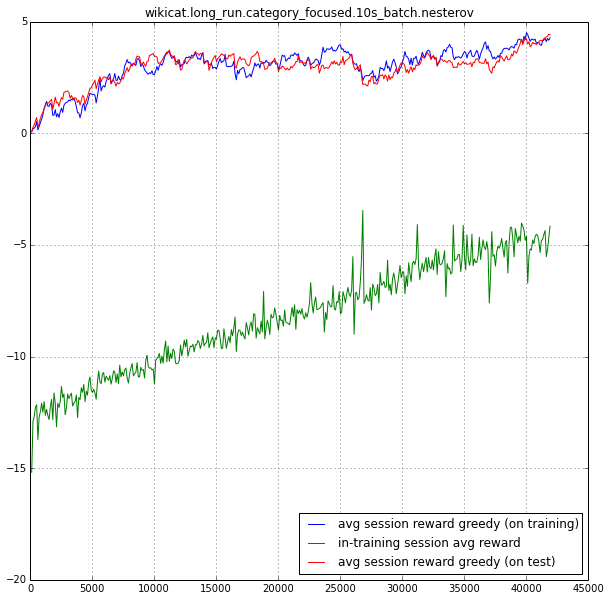

epoch 42000,loss 0.35920, greed 0.50866, rewards: ( train -3.99368, det_train 4.27810) 
rec 0.358 reg 0.001
epoch 42100,loss 0.54461, greed 0.50925, rewards: ( train -4.58153, det_train 4.28029) 
rec 0.543 reg 0.001
epoch 42200,loss 0.69568, greed 0.50984, rewards: ( train -4.27124, det_train 4.08226) 
rec 0.694 reg 0.001
epoch 42300,loss 0.65226, greed 0.51043, rewards: ( train -3.93931, det_train 4.18403) 
rec 0.651 reg 0.001
epoch 42400,loss 0.32778, greed 0.51102, rewards: ( train -6.66190, det_train 4.20563) 
rec 0.327 reg 0.001
epoch 42500,loss 0.61603, greed 0.51161, rewards: ( train -4.49803, det_train 4.14507) 
rec 0.615 reg 0.001
epoch 42600,loss 0.53253, greed 0.51220, rewards: ( train -3.80756, det_train 4.12056) 
rec 0.531 reg 0.001
epoch 42700,loss 0.35032, greed 0.51278, rewards: ( train -5.00541, det_train 3.66850) 
rec 0.349 reg 0.001
epoch 42800,loss 0.45734, greed 0.51337, rewards: ( train -3.53988, det_train 3.84165) 
rec 0.456 reg 0.001
epoch 42900,loss 0.46279, gr

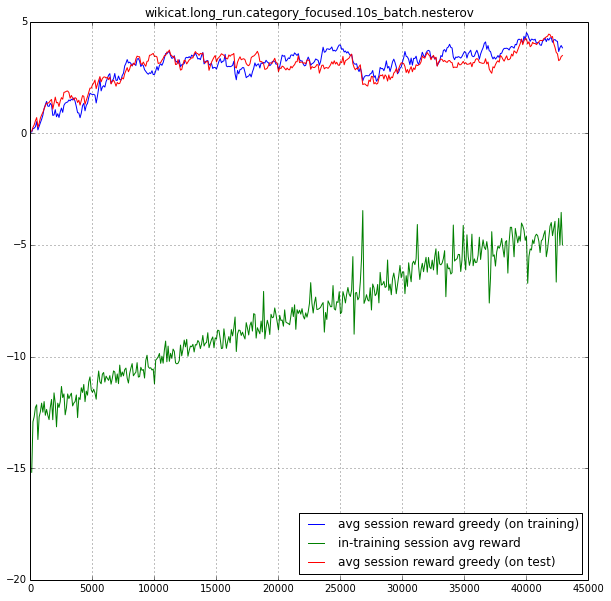

epoch 43000,loss 0.38530, greed 0.51454, rewards: ( train -4.53406, det_train 3.83374) 
rec 0.384 reg 0.001
epoch 43100,loss 0.42193, greed 0.51513, rewards: ( train -3.60370, det_train 3.87037) 
rec 0.421 reg 0.001
epoch 43200,loss 0.40054, greed 0.51571, rewards: ( train -4.44408, det_train 3.89333) 
rec 0.399 reg 0.001
epoch 43300,loss 0.30502, greed 0.51630, rewards: ( train -4.69888, det_train 3.93400) 
rec 0.304 reg 0.001
epoch 43400,loss 0.49894, greed 0.51688, rewards: ( train -4.85897, det_train 3.99060) 
rec 0.498 reg 0.001
epoch 43500,loss 0.43138, greed 0.51746, rewards: ( train -4.74099, det_train 4.08154) 
rec 0.430 reg 0.001
epoch 43600,loss 0.41298, greed 0.51804, rewards: ( train -4.28279, det_train 4.03338) 
rec 0.412 reg 0.001
epoch 43700,loss 0.47720, greed 0.51863, rewards: ( train -4.34469, det_train 4.03004) 
rec 0.476 reg 0.001
epoch 43800,loss 0.44590, greed 0.51921, rewards: ( train -4.68477, det_train 4.02704) 
rec 0.445 reg 0.001
epoch 43900,loss 0.56571, gr

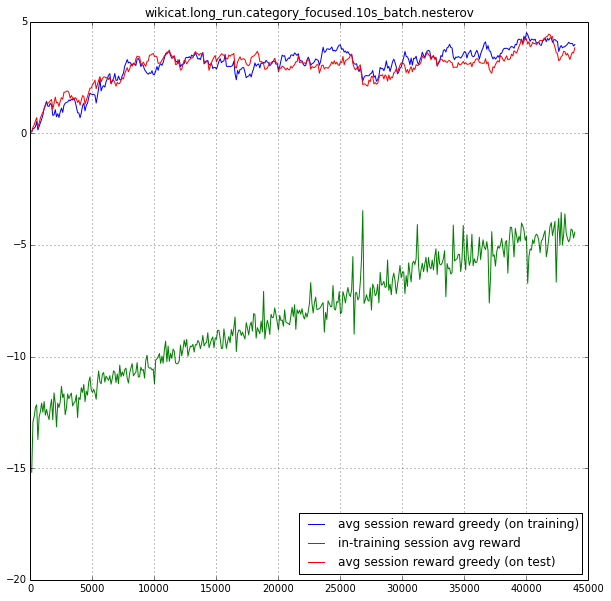

epoch 44000,loss 0.61635, greed 0.52037, rewards: ( train -4.76778, det_train 3.98290) 
rec 0.615 reg 0.001
epoch 44100,loss 0.49585, greed 0.52095, rewards: ( train -4.64971, det_train 3.63461) 
rec 0.495 reg 0.001
epoch 44200,loss 0.65819, greed 0.52153, rewards: ( train -4.70642, det_train 3.20115) 
rec 0.657 reg 0.001
epoch 44300,loss 0.53259, greed 0.52210, rewards: ( train -3.86117, det_train 3.09104) 
rec 0.531 reg 0.001
epoch 44400,loss 0.48709, greed 0.52268, rewards: ( train -4.38353, det_train 3.25193) 
rec 0.486 reg 0.001
epoch 44500,loss 0.35554, greed 0.52326, rewards: ( train -4.24183, det_train 3.40674) 
rec 0.354 reg 0.001
epoch 44600,loss 0.47198, greed 0.52383, rewards: ( train -4.21025, det_train 3.48607) 
rec 0.471 reg 0.001
epoch 44700,loss 0.50442, greed 0.52441, rewards: ( train -5.12004, det_train 3.44746) 
rec 0.503 reg 0.001
epoch 44800,loss 0.59830, greed 0.52499, rewards: ( train -4.03627, det_train 3.42271) 
rec 0.597 reg 0.001
epoch 44900,loss 0.28130, gr

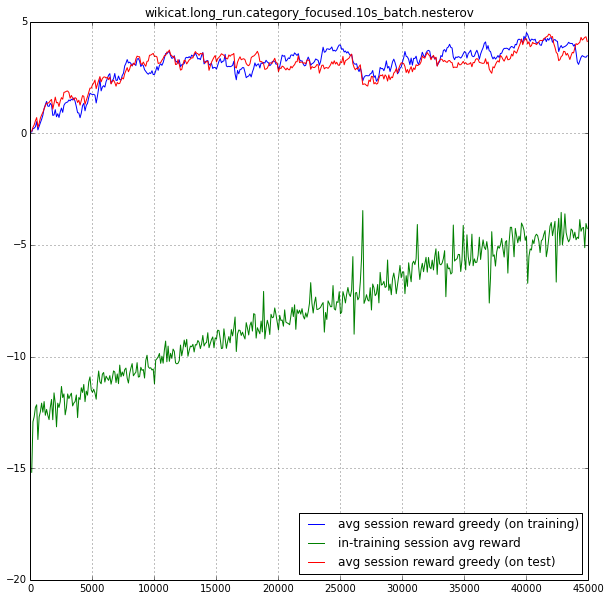

epoch 45000,loss 0.40418, greed 0.52613, rewards: ( train -4.77405, det_train 3.47940) 
rec 0.403 reg 0.001
epoch 45100,loss 0.42048, greed 0.52671, rewards: ( train -4.25013, det_train 3.71146) 
rec 0.419 reg 0.001
epoch 45200,loss 0.45227, greed 0.52728, rewards: ( train -4.15635, det_train 3.89031) 
rec 0.451 reg 0.001
epoch 45300,loss 0.59809, greed 0.52785, rewards: ( train -4.03624, det_train 3.74128) 
rec 0.597 reg 0.001
epoch 45400,loss 0.24493, greed 0.52843, rewards: ( train -4.11177, det_train 3.65715) 
rec 0.244 reg 0.001
epoch 45500,loss 0.31648, greed 0.52900, rewards: ( train -4.34545, det_train 3.99144) 
rec 0.315 reg 0.001
epoch 45600,loss 0.76061, greed 0.52957, rewards: ( train -4.57158, det_train 4.08229) 
rec 0.759 reg 0.001
epoch 45700,loss 0.47904, greed 0.53014, rewards: ( train -4.19367, det_train 3.82406) 
rec 0.478 reg 0.001
epoch 45800,loss 0.61682, greed 0.53071, rewards: ( train -4.21143, det_train 3.96166) 
rec 0.616 reg 0.001
epoch 45900,loss 0.57779, gr

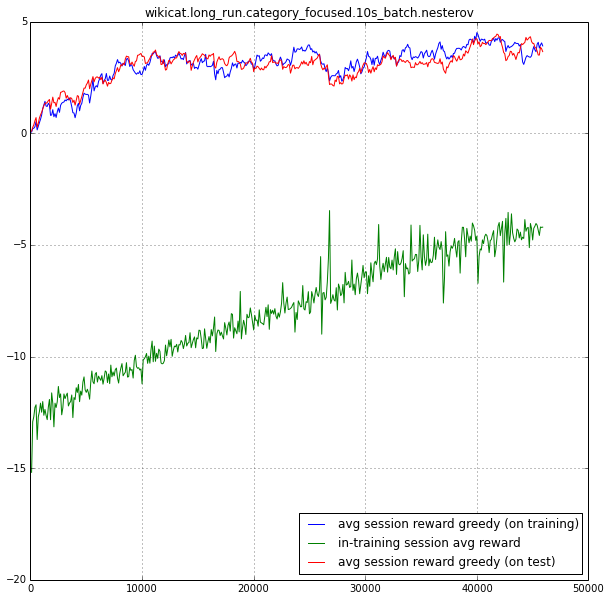

epoch 46000,loss 0.50556, greed 0.53184, rewards: ( train -3.88423, det_train 3.91994) 
rec 0.504 reg 0.001
epoch 46100,loss 0.54885, greed 0.53241, rewards: ( train -4.02000, det_train 3.85795) 
rec 0.548 reg 0.001
epoch 46200,loss 0.61680, greed 0.53298, rewards: ( train -4.18432, det_train 3.70215) 
rec 0.616 reg 0.001
epoch 46300,loss 0.46382, greed 0.53355, rewards: ( train -4.56088, det_train 3.73194) 
rec 0.463 reg 0.001
epoch 46400,loss 0.57932, greed 0.53411, rewards: ( train -3.88831, det_train 3.75874) 
rec 0.578 reg 0.001
epoch 46500,loss 0.38228, greed 0.53468, rewards: ( train -3.96772, det_train 3.91287) 
rec 0.381 reg 0.001
epoch 46600,loss 0.65042, greed 0.53524, rewards: ( train -3.33766, det_train 4.18158) 
rec 0.649 reg 0.001
epoch 46700,loss 0.50293, greed 0.53581, rewards: ( train -3.65233, det_train 4.20342) 
rec 0.502 reg 0.001
epoch 46800,loss 0.47713, greed 0.53637, rewards: ( train -4.32316, det_train 4.19308) 
rec 0.476 reg 0.001
epoch 46900,loss 0.38590, gr

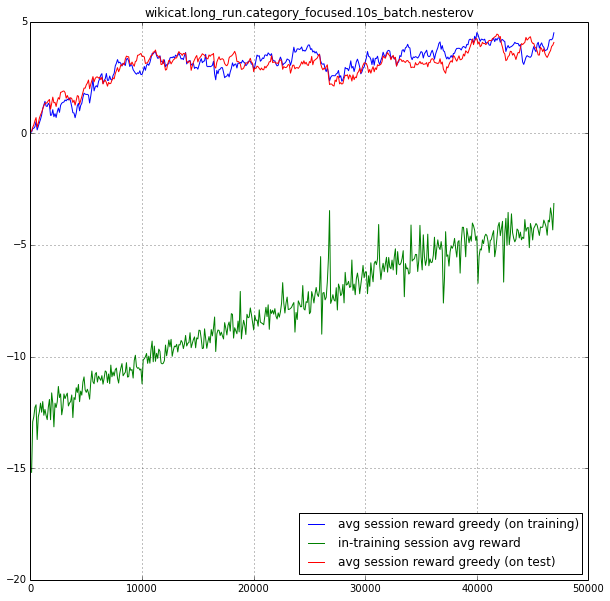

epoch 47000,loss 0.50773, greed 0.53750, rewards: ( train -3.71464, det_train 4.50740) 
rec 0.506 reg 0.001
epoch 47100,loss 0.47163, greed 0.53806, rewards: ( train -3.81664, det_train 4.53666) 
rec 0.470 reg 0.001
epoch 47200,loss 0.67004, greed 0.53862, rewards: ( train -3.54463, det_train 4.63299) 
rec 0.669 reg 0.001
epoch 47300,loss 0.42999, greed 0.53918, rewards: ( train -4.35127, det_train 4.64969) 
rec 0.429 reg 0.001
epoch 47400,loss 0.51880, greed 0.53974, rewards: ( train -3.47512, det_train 4.57472) 
rec 0.518 reg 0.001
epoch 47500,loss 0.52117, greed 0.54030, rewards: ( train -3.44907, det_train 4.55725) 
rec 0.520 reg 0.001
epoch 47600,loss 0.61809, greed 0.54086, rewards: ( train -3.95236, det_train 4.55153) 
rec 0.617 reg 0.001
epoch 47700,loss 0.50472, greed 0.54142, rewards: ( train -3.77130, det_train 4.44637) 
rec 0.503 reg 0.001
epoch 47800,loss 0.40348, greed 0.54198, rewards: ( train -3.90835, det_train 4.12174) 
rec 0.402 reg 0.001
epoch 47900,loss 0.58110, gr

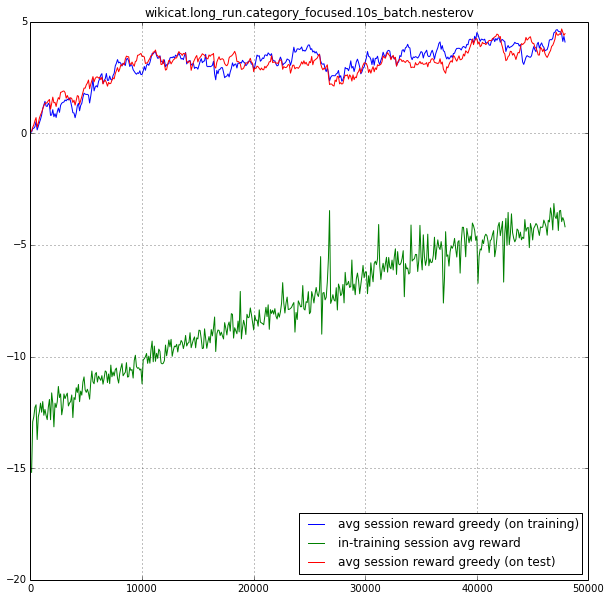

epoch 48000,loss 0.53017, greed 0.54309, rewards: ( train -3.85518, det_train 4.09461) 
rec 0.529 reg 0.001
epoch 48100,loss 0.57124, greed 0.54365, rewards: ( train -4.14337, det_train 4.00515) 
rec 0.570 reg 0.001
epoch 48200,loss 0.50626, greed 0.54421, rewards: ( train -4.04191, det_train 3.84463) 
rec 0.505 reg 0.001
epoch 48300,loss 0.46854, greed 0.54476, rewards: ( train -3.76825, det_train 3.91017) 
rec 0.467 reg 0.001
epoch 48400,loss 0.46924, greed 0.54532, rewards: ( train -3.30790, det_train 4.14915) 
rec 0.468 reg 0.001
epoch 48500,loss 0.45732, greed 0.54587, rewards: ( train -3.98507, det_train 4.33424) 
rec 0.456 reg 0.001
epoch 48600,loss 0.53266, greed 0.54643, rewards: ( train -3.49568, det_train 4.25081) 
rec 0.531 reg 0.001
epoch 48700,loss 0.43350, greed 0.54698, rewards: ( train -3.41157, det_train 4.31573) 
rec 0.432 reg 0.001
epoch 48800,loss 0.42624, greed 0.54753, rewards: ( train -3.83131, det_train 4.33416) 
rec 0.425 reg 0.001
epoch 48900,loss 0.58475, gr

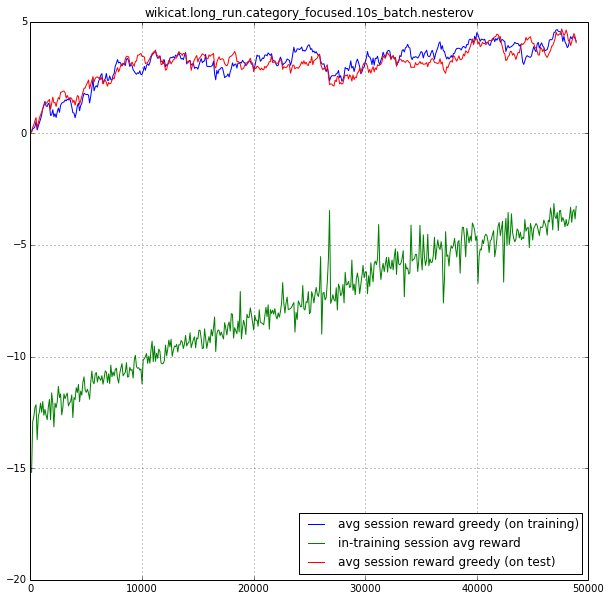

epoch 49000,loss 0.45510, greed 0.54864, rewards: ( train -3.66835, det_train 4.13567) 
rec 0.454 reg 0.001
epoch 49100,loss 0.54965, greed 0.54919, rewards: ( train -3.72157, det_train 4.19210) 
rec 0.548 reg 0.001
epoch 49200,loss 0.37151, greed 0.54974, rewards: ( train -3.81952, det_train 4.16289) 
rec 0.370 reg 0.001
epoch 49300,loss 0.69611, greed 0.55029, rewards: ( train -3.36104, det_train 4.38660) 
rec 0.695 reg 0.001
epoch 49400,loss 0.50222, greed 0.55084, rewards: ( train -3.87244, det_train 4.09794) 
rec 0.501 reg 0.001
epoch 49500,loss 0.42502, greed 0.55139, rewards: ( train -3.55613, det_train 4.08815) 
rec 0.424 reg 0.001
epoch 49600,loss 0.41724, greed 0.55193, rewards: ( train -3.28441, det_train 4.31933) 
rec 0.416 reg 0.001
epoch 49700,loss 0.34815, greed 0.55248, rewards: ( train -3.44600, det_train 4.30740) 
rec 0.347 reg 0.001
epoch 49800,loss 0.37901, greed 0.55303, rewards: ( train -3.48800, det_train 4.51666) 
rec 0.378 reg 0.001
epoch 49900,loss 0.47488, gr

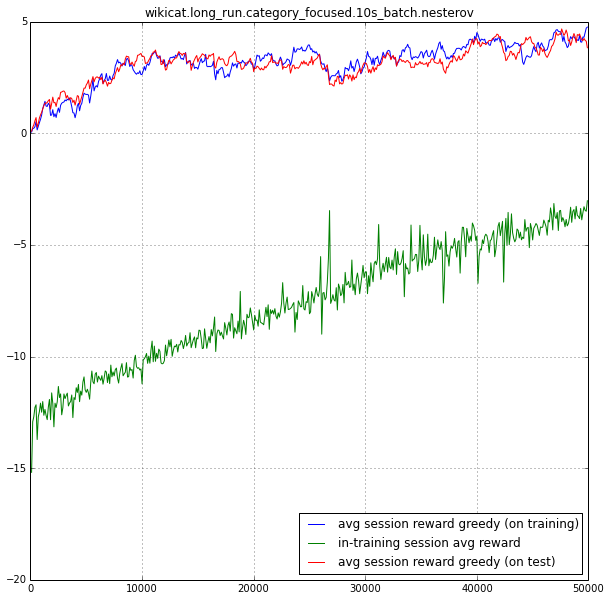

snapshot saved
epoch 50000,loss 0.45506, greed 0.55412, rewards: ( train -3.51176, det_train 4.76349) 
rec 0.454 reg 0.001
epoch 50100,loss 0.41935, greed 0.55467, rewards: ( train -3.07236, det_train 4.87714) 
rec 0.418 reg 0.001
epoch 50200,loss 0.59596, greed 0.55521, rewards: ( train -3.76118, det_train 4.96943) 
rec 0.595 reg 0.001
epoch 50300,loss 0.58532, greed 0.55576, rewards: ( train -3.16570, det_train 4.78249) 
rec 0.584 reg 0.001
epoch 50400,loss 0.56678, greed 0.55630, rewards: ( train -3.52603, det_train 4.69424) 
rec 0.566 reg 0.001
epoch 50500,loss 0.59316, greed 0.55684, rewards: ( train -2.83299, det_train 4.79481) 
rec 0.592 reg 0.001
epoch 50600,loss 0.37653, greed 0.55739, rewards: ( train -3.28098, det_train 4.76533) 
rec 0.375 reg 0.001
epoch 50700,loss 0.58299, greed 0.55793, rewards: ( train -3.14428, det_train 4.86880) 
rec 0.582 reg 0.001
epoch 50800,loss 0.57128, greed 0.55847, rewards: ( train -2.78065, det_train 4.73192) 
rec 0.570 reg 0.001
epoch 50900,l

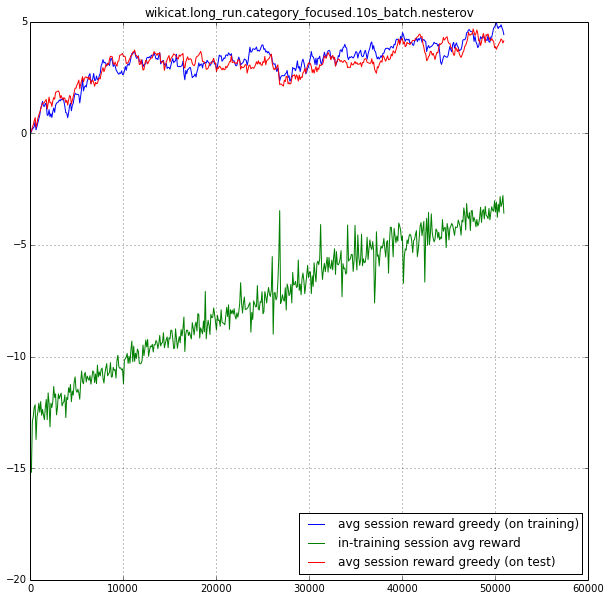

epoch 51000,loss 0.53532, greed 0.55955, rewards: ( train -3.20477, det_train 4.42686) 
rec 0.534 reg 0.001
epoch 51100,loss 0.44464, greed 0.56009, rewards: ( train -3.01527, det_train 4.44417) 
rec 0.443 reg 0.001
epoch 51200,loss 0.47440, greed 0.56063, rewards: ( train -2.83547, det_train 4.42975) 
rec 0.473 reg 0.001
epoch 51300,loss 0.48999, greed 0.56117, rewards: ( train -3.10801, det_train 4.45678) 
rec 0.489 reg 0.001
epoch 51400,loss 0.39520, greed 0.56171, rewards: ( train -3.82322, det_train 4.43110) 
rec 0.394 reg 0.001
epoch 51500,loss 0.60221, greed 0.56225, rewards: ( train -2.92371, det_train 4.57799) 
rec 0.601 reg 0.001
epoch 51600,loss 0.48754, greed 0.56279, rewards: ( train -2.98331, det_train 4.45019) 
rec 0.486 reg 0.001
epoch 51700,loss 0.53923, greed 0.56332, rewards: ( train -3.29070, det_train 4.54517) 
rec 0.538 reg 0.001
epoch 51800,loss 0.46437, greed 0.56386, rewards: ( train -3.08262, det_train 4.61065) 
rec 0.463 reg 0.001
epoch 51900,loss 0.29543, gr

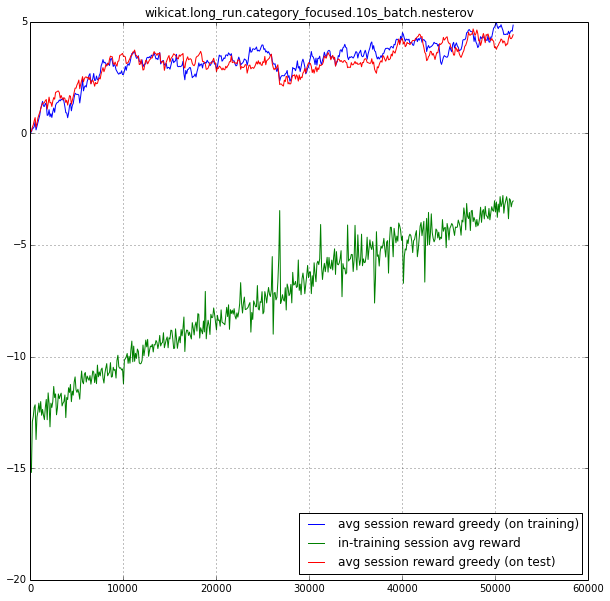

epoch 52000,loss 0.48756, greed 0.56493, rewards: ( train -2.91742, det_train 4.85163) 
rec 0.486 reg 0.001
epoch 52100,loss 0.32246, greed 0.56547, rewards: ( train -3.80577, det_train 4.93647) 
rec 0.321 reg 0.001
epoch 52200,loss 0.49859, greed 0.56600, rewards: ( train -3.47038, det_train 5.03282) 
rec 0.497 reg 0.001
epoch 52300,loss 0.73797, greed 0.56653, rewards: ( train -3.43627, det_train 5.11954) 
rec 0.737 reg 0.001
epoch 52400,loss 0.54125, greed 0.56707, rewards: ( train -2.84401, det_train 4.64758) 
rec 0.540 reg 0.001
epoch 52500,loss 0.41905, greed 0.56760, rewards: ( train -3.44305, det_train 4.79283) 
rec 0.418 reg 0.001
epoch 52600,loss 0.40093, greed 0.56813, rewards: ( train -2.94212, det_train 4.72354) 
rec 0.400 reg 0.001
epoch 52700,loss 0.47578, greed 0.56866, rewards: ( train -2.98884, det_train 4.95119) 
rec 0.474 reg 0.001
epoch 52800,loss 0.54893, greed 0.56919, rewards: ( train -2.68060, det_train 4.92607) 
rec 0.548 reg 0.001
epoch 52900,loss 0.44901, gr

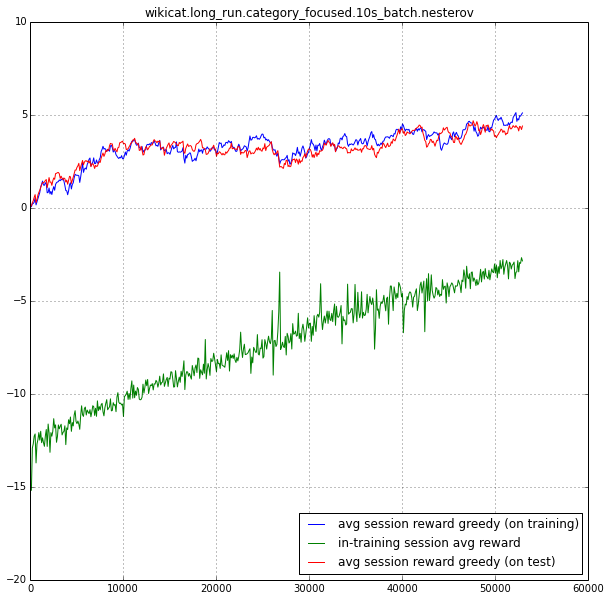

epoch 53000,loss 0.61419, greed 0.57026, rewards: ( train -3.17715, det_train 5.10112) 
rec 0.613 reg 0.001
epoch 53100,loss 0.43756, greed 0.57079, rewards: ( train -2.81127, det_train 4.89101) 
rec 0.436 reg 0.001
epoch 53200,loss 0.40376, greed 0.57131, rewards: ( train -3.07357, det_train 4.95190) 
rec 0.402 reg 0.001
epoch 53300,loss 0.40998, greed 0.57184, rewards: ( train -3.33481, det_train 4.93671) 
rec 0.409 reg 0.001
epoch 53400,loss 0.50000, greed 0.57237, rewards: ( train -3.56651, det_train 4.83304) 
rec 0.499 reg 0.001
epoch 53500,loss 0.44501, greed 0.57290, rewards: ( train -3.18809, det_train 4.82974) 
rec 0.444 reg 0.001
epoch 53600,loss 0.59781, greed 0.57342, rewards: ( train -3.54736, det_train 4.71676) 
rec 0.597 reg 0.001
epoch 53700,loss 0.29171, greed 0.57395, rewards: ( train -2.51062, det_train 4.67509) 
rec 0.290 reg 0.001
epoch 53800,loss 0.45576, greed 0.57448, rewards: ( train -3.04732, det_train 4.86758) 
rec 0.454 reg 0.001
epoch 53900,loss 0.42544, gr

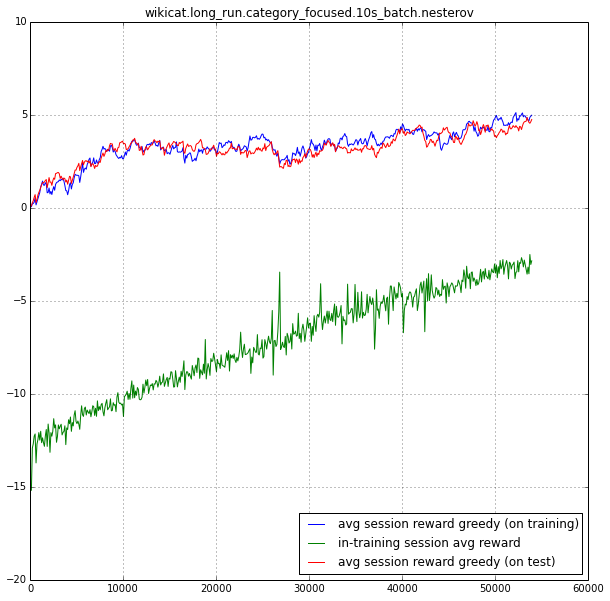

epoch 54000,loss 0.55975, greed 0.57553, rewards: ( train -3.22214, det_train 4.97874) 
rec 0.558 reg 0.001
epoch 54100,loss 0.47049, greed 0.57605, rewards: ( train -2.22588, det_train 4.88087) 
rec 0.469 reg 0.001
epoch 54200,loss 0.47751, greed 0.57657, rewards: ( train -2.98451, det_train 5.00278) 
rec 0.476 reg 0.001
epoch 54300,loss 0.41611, greed 0.57710, rewards: ( train -2.71581, det_train 5.04250) 
rec 0.415 reg 0.001
epoch 54400,loss 0.56328, greed 0.57762, rewards: ( train -3.08683, det_train 5.08825) 
rec 0.562 reg 0.001
epoch 54500,loss 0.56286, greed 0.57814, rewards: ( train -2.81070, det_train 5.07943) 
rec 0.562 reg 0.001
epoch 54600,loss 0.32709, greed 0.57866, rewards: ( train -2.83444, det_train 5.03148) 
rec 0.326 reg 0.001
epoch 54700,loss 0.35889, greed 0.57919, rewards: ( train -2.95019, det_train 5.08833) 
rec 0.358 reg 0.001
epoch 54800,loss 0.42801, greed 0.57971, rewards: ( train -2.43822, det_train 5.17950) 
rec 0.427 reg 0.001
epoch 54900,loss 0.40830, gr

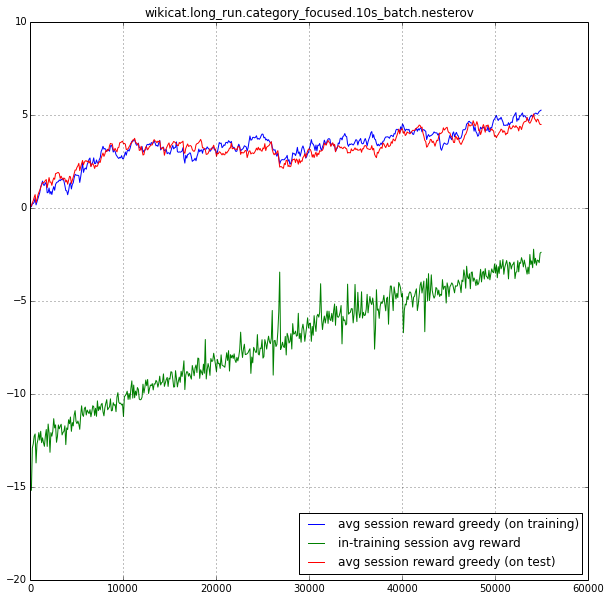

epoch 55000,loss 0.36091, greed 0.58075, rewards: ( train -2.71690, det_train 5.25040) 
rec 0.360 reg 0.001
epoch 55100,loss 0.62644, greed 0.58126, rewards: ( train -2.75685, det_train 5.45536) 
rec 0.625 reg 0.001
epoch 55200,loss 0.40473, greed 0.58178, rewards: ( train -2.90261, det_train 5.19982) 
rec 0.403 reg 0.001
epoch 55300,loss 0.37678, greed 0.58230, rewards: ( train -2.73516, det_train 5.14984) 
rec 0.375 reg 0.001
epoch 55400,loss 0.41635, greed 0.58282, rewards: ( train -2.75638, det_train 5.14485) 
rec 0.415 reg 0.001
epoch 55500,loss 0.65663, greed 0.58333, rewards: ( train -2.88923, det_train 5.18037) 
rec 0.655 reg 0.001
epoch 55600,loss 0.54295, greed 0.58385, rewards: ( train -2.42160, det_train 5.00233) 
rec 0.542 reg 0.001
epoch 55700,loss 0.53397, greed 0.58437, rewards: ( train -2.75600, det_train 4.84210) 
rec 0.533 reg 0.001
epoch 55800,loss 0.36188, greed 0.58488, rewards: ( train -2.26656, det_train 5.02789) 
rec 0.361 reg 0.001
epoch 55900,loss 0.52054, gr

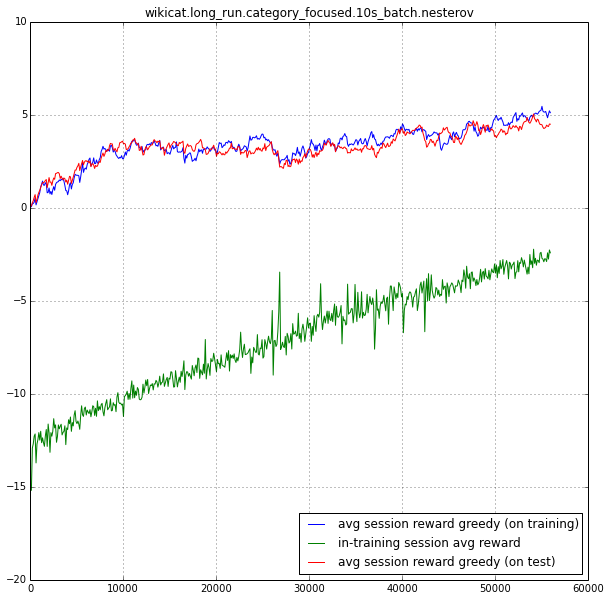

epoch 56000,loss 0.44297, greed 0.58591, rewards: ( train -2.44270, det_train 5.11359) 
rec 0.442 reg 0.001
epoch 56100,loss 0.38736, greed 0.58643, rewards: ( train -2.31727, det_train 5.07223) 
rec 0.386 reg 0.001
epoch 56200,loss 0.59864, greed 0.58694, rewards: ( train -2.85405, det_train 5.09501) 
rec 0.597 reg 0.001
epoch 56300,loss 0.39322, greed 0.58745, rewards: ( train -2.75144, det_train 4.80551) 
rec 0.392 reg 0.001
epoch 56400,loss 0.72582, greed 0.58796, rewards: ( train -2.41563, det_train 4.81496) 
rec 0.725 reg 0.001
epoch 56500,loss 0.45065, greed 0.58848, rewards: ( train -3.05571, det_train 4.57346) 
rec 0.449 reg 0.001
epoch 56600,loss 0.59677, greed 0.58899, rewards: ( train -3.00067, det_train 4.63611) 
rec 0.595 reg 0.001
epoch 56700,loss 0.47656, greed 0.58950, rewards: ( train -2.82181, det_train 4.49250) 
rec 0.475 reg 0.001
epoch 56800,loss 0.69870, greed 0.59001, rewards: ( train -2.60207, det_train 4.52325) 
rec 0.697 reg 0.001
epoch 56900,loss 0.60091, gr

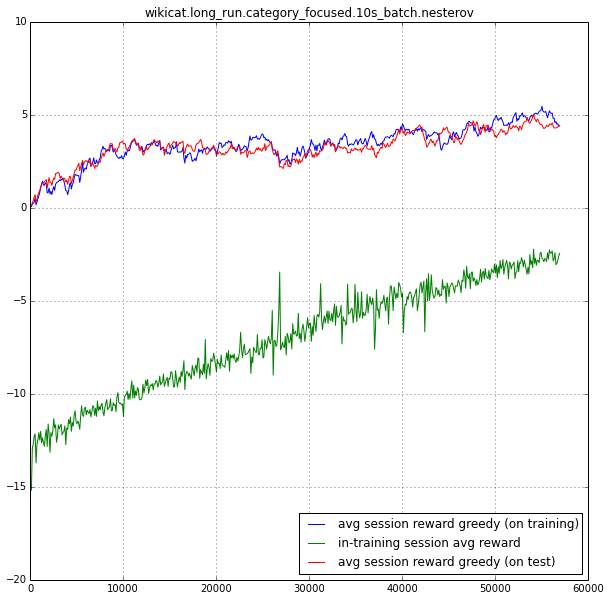

epoch 57000,loss 0.59694, greed 0.59103, rewards: ( train -2.38496, det_train 4.43283) 
rec 0.596 reg 0.001
epoch 57100,loss 0.62170, greed 0.59154, rewards: ( train -3.03259, det_train 4.33955) 
rec 0.620 reg 0.001
epoch 57200,loss 0.59982, greed 0.59204, rewards: ( train -3.06119, det_train 4.12560) 
rec 0.599 reg 0.001
epoch 57300,loss 0.85019, greed 0.59255, rewards: ( train -2.24096, det_train 4.14304) 
rec 0.849 reg 0.001
epoch 57400,loss 0.47233, greed 0.59306, rewards: ( train -2.22284, det_train 4.12873) 
rec 0.471 reg 0.001
epoch 57500,loss 0.48893, greed 0.59357, rewards: ( train -2.30714, det_train 4.12586) 
rec 0.488 reg 0.001
epoch 57600,loss 0.58489, greed 0.59407, rewards: ( train -2.64518, det_train 4.29327) 
rec 0.584 reg 0.001
epoch 57700,loss 0.45023, greed 0.59458, rewards: ( train -2.85198, det_train 4.22395) 
rec 0.449 reg 0.001
epoch 57800,loss 0.31245, greed 0.59508, rewards: ( train -2.47323, det_train 4.19155) 
rec 0.311 reg 0.001
epoch 57900,loss 0.33432, gr

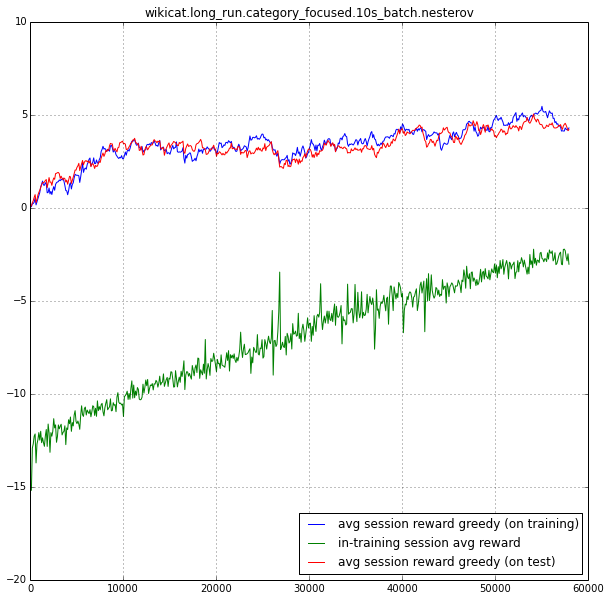

epoch 58000,loss 0.37708, greed 0.59609, rewards: ( train -2.26344, det_train 4.29316) 
rec 0.376 reg 0.001
epoch 58100,loss 0.57986, greed 0.59660, rewards: ( train -2.67956, det_train 4.55384) 
rec 0.579 reg 0.001
epoch 58200,loss 0.43577, greed 0.59710, rewards: ( train -2.19750, det_train 4.59846) 
rec 0.434 reg 0.001
epoch 58300,loss 0.48009, greed 0.59760, rewards: ( train -2.60492, det_train 4.77861) 
rec 0.479 reg 0.001
epoch 58400,loss 0.47357, greed 0.59810, rewards: ( train -2.03791, det_train 4.86075) 
rec 0.472 reg 0.001
epoch 58500,loss 0.37202, greed 0.59860, rewards: ( train -2.25281, det_train 4.95468) 
rec 0.371 reg 0.001
epoch 58600,loss 0.57195, greed 0.59911, rewards: ( train -2.35384, det_train 4.85921) 
rec 0.571 reg 0.001
epoch 58700,loss 0.71069, greed 0.59961, rewards: ( train -2.22218, det_train 4.80329) 
rec 0.709 reg 0.001
epoch 58800,loss 0.40794, greed 0.60011, rewards: ( train -2.27594, det_train 4.78296) 
rec 0.407 reg 0.001
epoch 58900,loss 0.47931, gr

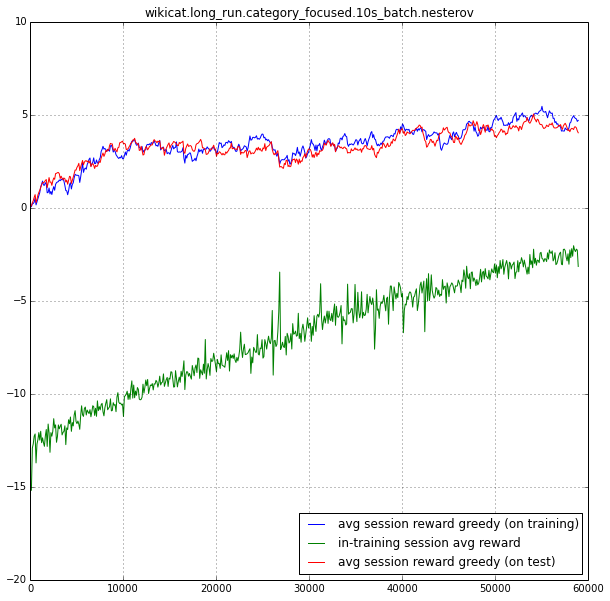

epoch 59000,loss 0.52153, greed 0.60111, rewards: ( train -2.71156, det_train 4.70020) 
rec 0.520 reg 0.001
epoch 59100,loss 0.54225, greed 0.60160, rewards: ( train -1.95299, det_train 4.73018) 
rec 0.541 reg 0.001
epoch 59200,loss 0.42963, greed 0.60210, rewards: ( train -2.51505, det_train 4.69716) 
rec 0.428 reg 0.001
epoch 59300,loss 0.44285, greed 0.60260, rewards: ( train -1.45288, det_train 4.64744) 
rec 0.442 reg 0.001
epoch 59400,loss 0.47402, greed 0.60310, rewards: ( train -2.01259, det_train 4.73270) 
rec 0.473 reg 0.001
epoch 59500,loss 0.56132, greed 0.60359, rewards: ( train -2.23808, det_train 4.86943) 
rec 0.560 reg 0.001
epoch 59600,loss 0.73920, greed 0.60409, rewards: ( train -2.47384, det_train 4.77249) 
rec 0.738 reg 0.001
epoch 59700,loss 0.51932, greed 0.60459, rewards: ( train -2.77626, det_train 4.56524) 
rec 0.518 reg 0.001
epoch 59800,loss 0.46617, greed 0.60508, rewards: ( train -2.43067, det_train 4.50871) 
rec 0.465 reg 0.001
epoch 59900,loss 0.50942, gr

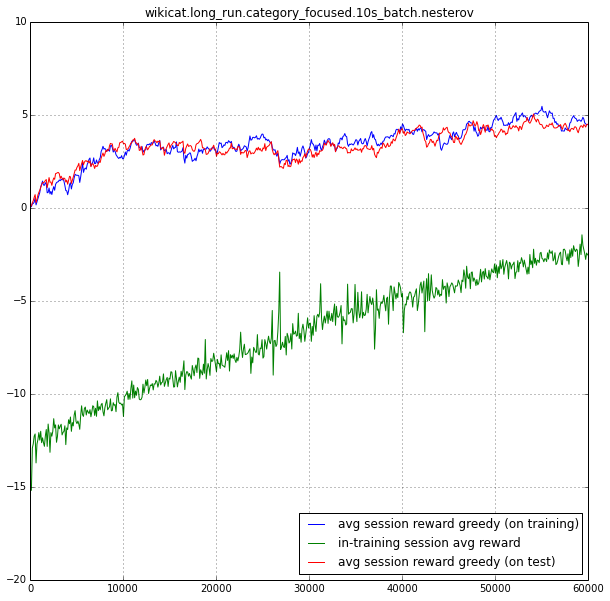

epoch 60000,loss 0.57929, greed 0.60607, rewards: ( train -1.99917, det_train 4.47006) 
rec 0.578 reg 0.001
epoch 60100,loss 0.53647, greed 0.60656, rewards: ( train -2.09940, det_train 4.56305) 
rec 0.535 reg 0.001
epoch 60200,loss 0.50811, greed 0.60706, rewards: ( train -1.81563, det_train 4.70675) 
rec 0.507 reg 0.001
epoch 60300,loss 0.41510, greed 0.60755, rewards: ( train -1.68739, det_train 4.69607) 
rec 0.414 reg 0.001
epoch 60400,loss 0.46158, greed 0.60804, rewards: ( train -1.65825, det_train 4.72647) 
rec 0.460 reg 0.001
epoch 60500,loss 0.63316, greed 0.60853, rewards: ( train -1.72969, det_train 4.96382) 
rec 0.632 reg 0.001
epoch 60600,loss 0.44940, greed 0.60902, rewards: ( train -2.04392, det_train 4.98744) 
rec 0.448 reg 0.001
epoch 60700,loss 0.37525, greed 0.60951, rewards: ( train -2.26824, det_train 4.78869) 
rec 0.374 reg 0.001
epoch 60800,loss 0.61171, greed 0.61001, rewards: ( train -2.34259, det_train 4.79982) 
rec 0.610 reg 0.001
epoch 60900,loss 0.50486, gr

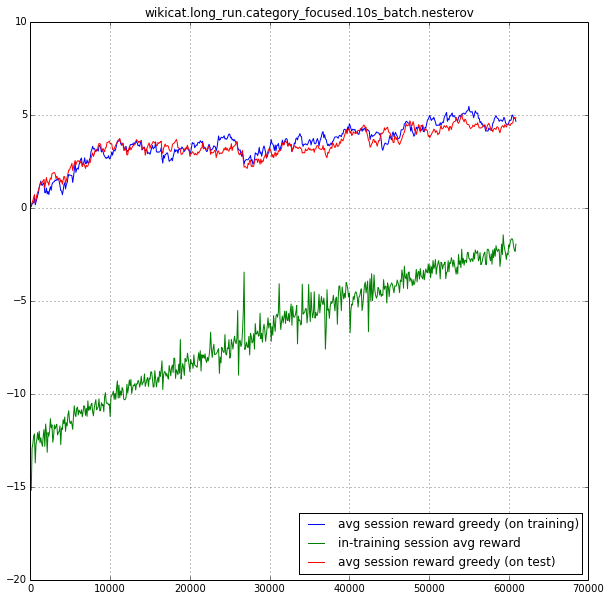

epoch 61000,loss 0.41155, greed 0.61098, rewards: ( train -2.12797, det_train 4.64886) 
rec 0.410 reg 0.001
epoch 61100,loss 0.60734, greed 0.61147, rewards: ( train -1.93540, det_train 4.69397) 
rec 0.606 reg 0.001
epoch 61200,loss 0.49445, greed 0.61196, rewards: ( train -1.55865, det_train 4.41457) 
rec 0.493 reg 0.001
epoch 61300,loss 0.46392, greed 0.61245, rewards: ( train -1.86995, det_train 4.46312) 
rec 0.463 reg 0.001
epoch 61400,loss 0.38301, greed 0.61294, rewards: ( train -1.53173, det_train 4.60681) 
rec 0.382 reg 0.001
epoch 61500,loss 0.42130, greed 0.61342, rewards: ( train -1.90682, det_train 4.72612) 
rec 0.420 reg 0.001
epoch 61600,loss 0.52608, greed 0.61391, rewards: ( train -2.03620, det_train 4.89351) 
rec 0.525 reg 0.001
epoch 61700,loss 0.35664, greed 0.61440, rewards: ( train -1.75267, det_train 4.85416) 
rec 0.355 reg 0.001
epoch 61800,loss 0.59253, greed 0.61488, rewards: ( train -2.07741, det_train 4.96874) 
rec 0.591 reg 0.001
epoch 61900,loss 0.32394, gr

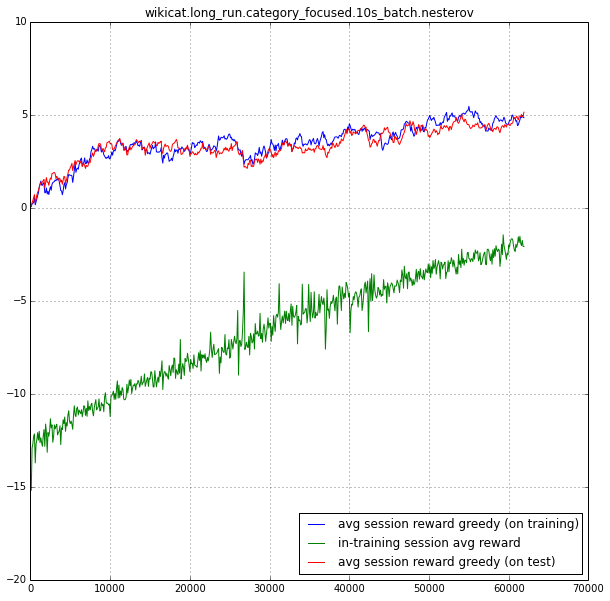

epoch 62000,loss 0.38998, greed 0.61585, rewards: ( train -1.87819, det_train 4.84568) 
rec 0.389 reg 0.001
epoch 62100,loss 0.70983, greed 0.61633, rewards: ( train -2.26720, det_train 5.06112) 
rec 0.709 reg 0.001
epoch 62200,loss 0.46938, greed 0.61682, rewards: ( train -2.32070, det_train 4.90500) 
rec 0.468 reg 0.001
epoch 62300,loss 0.50727, greed 0.61730, rewards: ( train -2.11127, det_train 4.93450) 
rec 0.506 reg 0.001
epoch 62400,loss 0.45841, greed 0.61778, rewards: ( train -2.02306, det_train 4.77105) 
rec 0.457 reg 0.001
epoch 62500,loss 0.61641, greed 0.61826, rewards: ( train -1.41237, det_train 4.93395) 
rec 0.615 reg 0.001
epoch 62600,loss 0.34383, greed 0.61875, rewards: ( train -1.86491, det_train 4.84055) 
rec 0.343 reg 0.001
epoch 62700,loss 0.48346, greed 0.61923, rewards: ( train -1.80926, det_train 4.91650) 
rec 0.482 reg 0.001
epoch 62800,loss 0.62933, greed 0.61971, rewards: ( train -1.95902, det_train 4.95485) 
rec 0.628 reg 0.001
epoch 62900,loss 0.57996, gr

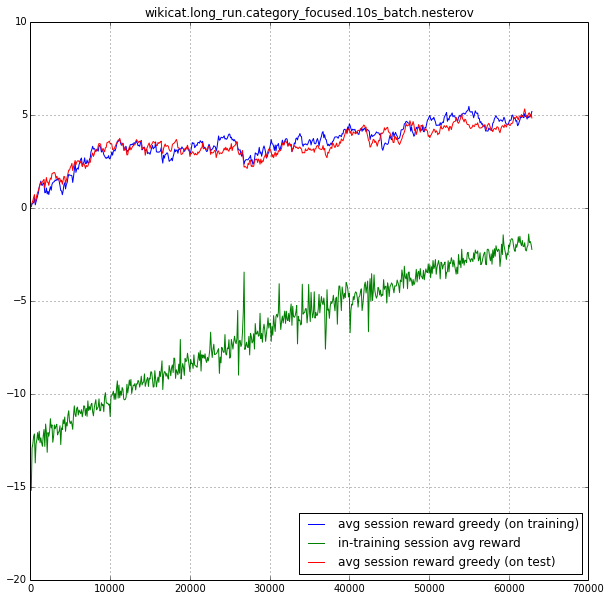

epoch 63000,loss 0.57432, greed 0.62067, rewards: ( train -2.31904, det_train 5.17843) 
rec 0.573 reg 0.001
epoch 63100,loss 0.51596, greed 0.62115, rewards: ( train -2.59083, det_train 5.18058) 
rec 0.515 reg 0.001
epoch 63200,loss 0.74351, greed 0.62163, rewards: ( train -2.12205, det_train 5.07253) 
rec 0.742 reg 0.001
epoch 63300,loss 0.55514, greed 0.62210, rewards: ( train -2.37208, det_train 5.13527) 
rec 0.554 reg 0.001
epoch 63400,loss 0.55284, greed 0.62258, rewards: ( train -2.07935, det_train 5.04175) 
rec 0.552 reg 0.001
epoch 63500,loss 0.56713, greed 0.62306, rewards: ( train -1.93795, det_train 5.07757) 
rec 0.566 reg 0.001
epoch 63600,loss 0.53740, greed 0.62353, rewards: ( train -1.86154, det_train 5.08981) 
rec 0.536 reg 0.001
epoch 63700,loss 0.44678, greed 0.62401, rewards: ( train -1.60342, det_train 5.07083) 
rec 0.445 reg 0.001
epoch 63800,loss 0.56264, greed 0.62449, rewards: ( train -2.28815, det_train 4.96375) 
rec 0.561 reg 0.001
epoch 63900,loss 0.39880, gr

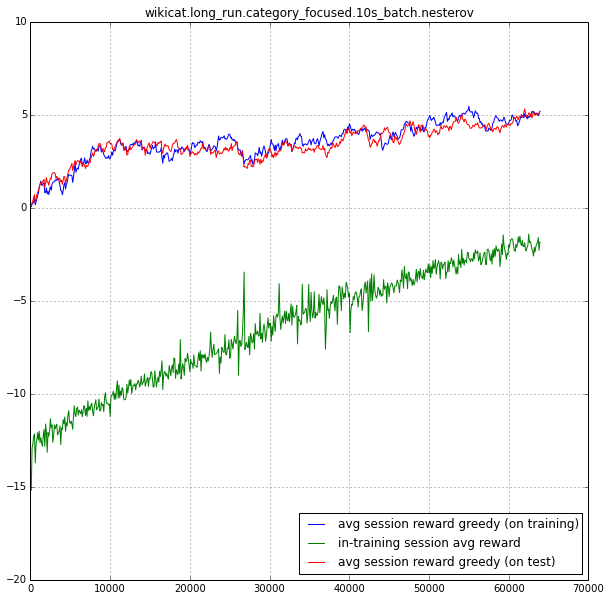

epoch 64000,loss 0.64239, greed 0.62544, rewards: ( train -1.76334, det_train 5.18364) 
rec 0.641 reg 0.001
epoch 64100,loss 0.39971, greed 0.62591, rewards: ( train -1.79282, det_train 5.11527) 
rec 0.398 reg 0.001
epoch 64200,loss 0.55230, greed 0.62638, rewards: ( train -1.91500, det_train 5.30375) 
rec 0.551 reg 0.001
epoch 64300,loss 0.44817, greed 0.62686, rewards: ( train -1.93432, det_train 5.10337) 
rec 0.447 reg 0.001
epoch 64400,loss 0.42737, greed 0.62733, rewards: ( train -1.34146, det_train 5.15303) 
rec 0.426 reg 0.001
epoch 64500,loss 0.59688, greed 0.62780, rewards: ( train -1.57438, det_train 5.14773) 
rec 0.596 reg 0.001
epoch 64600,loss 0.52006, greed 0.62828, rewards: ( train -2.02320, det_train 5.06296) 
rec 0.519 reg 0.001
epoch 64700,loss 0.47521, greed 0.62875, rewards: ( train -1.80736, det_train 5.04666) 
rec 0.474 reg 0.001
epoch 64800,loss 0.69671, greed 0.62922, rewards: ( train -1.65993, det_train 5.09200) 
rec 0.695 reg 0.001
epoch 64900,loss 0.36739, gr

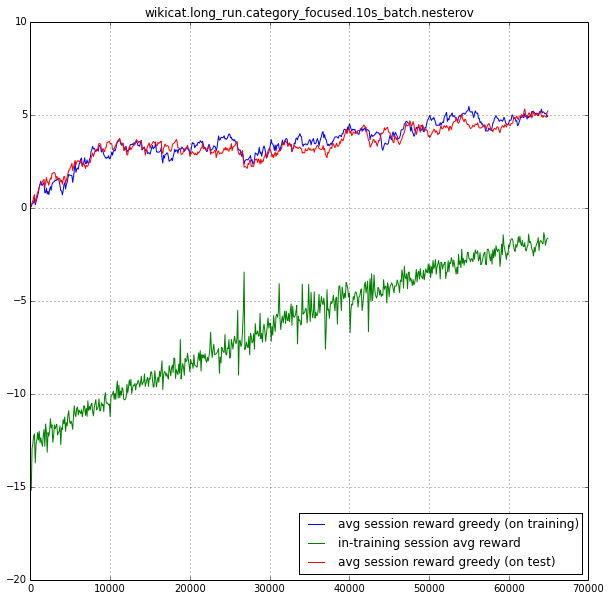

epoch 65000,loss 0.70263, greed 0.63016, rewards: ( train -1.21392, det_train 4.94452) 
rec 0.701 reg 0.001
epoch 65100,loss 0.52377, greed 0.63063, rewards: ( train -2.21151, det_train 4.90006) 
rec 0.522 reg 0.001
epoch 65200,loss 0.45016, greed 0.63110, rewards: ( train -1.29913, det_train 4.97006) 
rec 0.449 reg 0.001
epoch 65300,loss 0.60035, greed 0.63157, rewards: ( train -2.36398, det_train 4.99305) 
rec 0.599 reg 0.001
epoch 65400,loss 0.48295, greed 0.63203, rewards: ( train -2.20455, det_train 5.11375) 
rec 0.482 reg 0.001
epoch 65500,loss 0.59486, greed 0.63250, rewards: ( train -1.57477, det_train 5.08237) 
rec 0.594 reg 0.001
epoch 65600,loss 0.42351, greed 0.63297, rewards: ( train -1.48566, det_train 5.05414) 
rec 0.422 reg 0.001
epoch 65700,loss 0.38960, greed 0.63344, rewards: ( train -1.61514, det_train 5.17872) 
rec 0.388 reg 0.001
epoch 65800,loss 0.43728, greed 0.63390, rewards: ( train -2.00760, det_train 5.21085) 
rec 0.436 reg 0.001
epoch 65900,loss 0.58314, gr

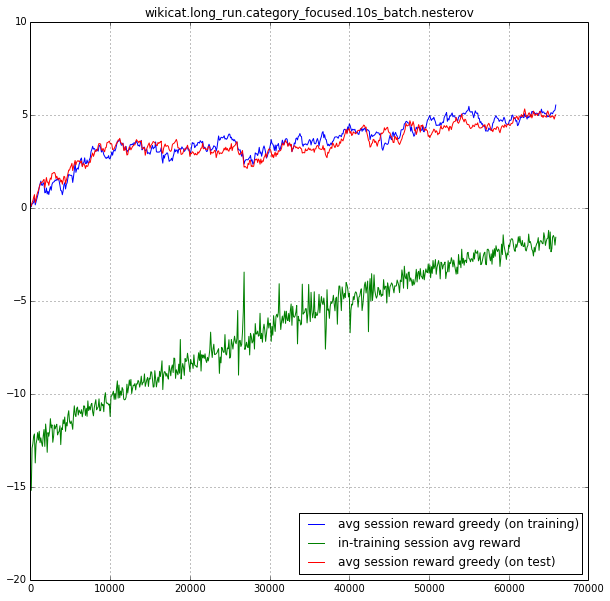

epoch 66000,loss 0.37212, greed 0.63483, rewards: ( train -1.43428, det_train 5.52379) 
rec 0.371 reg 0.001
epoch 66100,loss 0.42960, greed 0.63530, rewards: ( train -1.36172, det_train 5.53141) 
rec 0.428 reg 0.001
epoch 66200,loss 0.55422, greed 0.63576, rewards: ( train -1.26399, det_train 5.60827) 
rec 0.553 reg 0.001
epoch 66300,loss 0.68227, greed 0.63623, rewards: ( train -1.68711, det_train 5.56744) 
rec 0.681 reg 0.001
epoch 66400,loss 0.36952, greed 0.63669, rewards: ( train -1.19984, det_train 5.51070) 
rec 0.368 reg 0.001
epoch 66500,loss 0.37182, greed 0.63715, rewards: ( train -1.15920, det_train 5.60963) 
rec 0.371 reg 0.001
epoch 66600,loss 0.60724, greed 0.63762, rewards: ( train -1.35788, det_train 5.68866) 
rec 0.606 reg 0.001
epoch 66700,loss 0.42617, greed 0.63808, rewards: ( train -1.84835, det_train 5.60980) 
rec 0.425 reg 0.001
epoch 66800,loss 0.44971, greed 0.63854, rewards: ( train -1.26974, det_train 5.48882) 
rec 0.448 reg 0.001
epoch 66900,loss 0.52959, gr

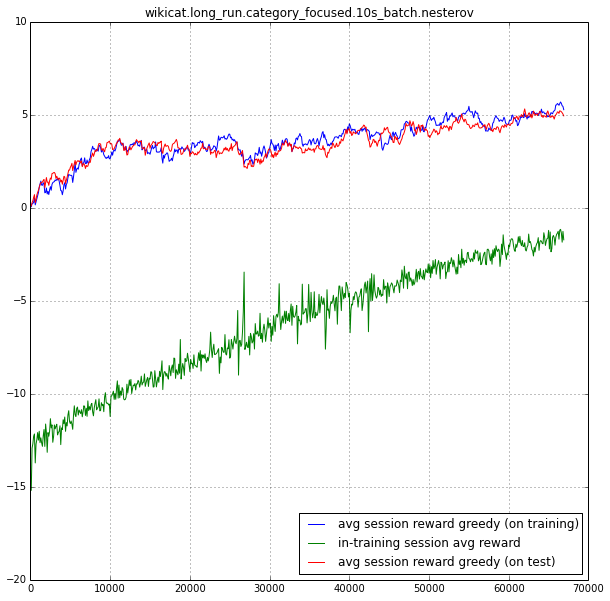

epoch 67000,loss 0.56755, greed 0.63946, rewards: ( train -1.32749, det_train 5.27494) 
rec 0.566 reg 0.001
epoch 67100,loss 0.45361, greed 0.63992, rewards: ( train -1.39389, det_train 5.40745) 
rec 0.452 reg 0.001
epoch 67200,loss 0.39136, greed 0.64038, rewards: ( train -1.42886, det_train 5.29670) 
rec 0.390 reg 0.001
epoch 67300,loss 0.37619, greed 0.64084, rewards: ( train -1.55288, det_train 5.38703) 
rec 0.375 reg 0.001
epoch 67400,loss 0.38555, greed 0.64130, rewards: ( train -1.87632, det_train 5.37833) 
rec 0.384 reg 0.001
epoch 67500,loss 0.39965, greed 0.64176, rewards: ( train -1.56481, det_train 5.40050) 
rec 0.398 reg 0.001
epoch 67600,loss 0.62769, greed 0.64222, rewards: ( train -1.91053, det_train 5.59045) 
rec 0.626 reg 0.001
epoch 67700,loss 0.58928, greed 0.64267, rewards: ( train -1.65620, det_train 5.21140) 
rec 0.588 reg 0.001
epoch 67800,loss 0.47575, greed 0.64313, rewards: ( train -1.26644, det_train 5.26026) 
rec 0.474 reg 0.001
epoch 67900,loss 0.46354, gr

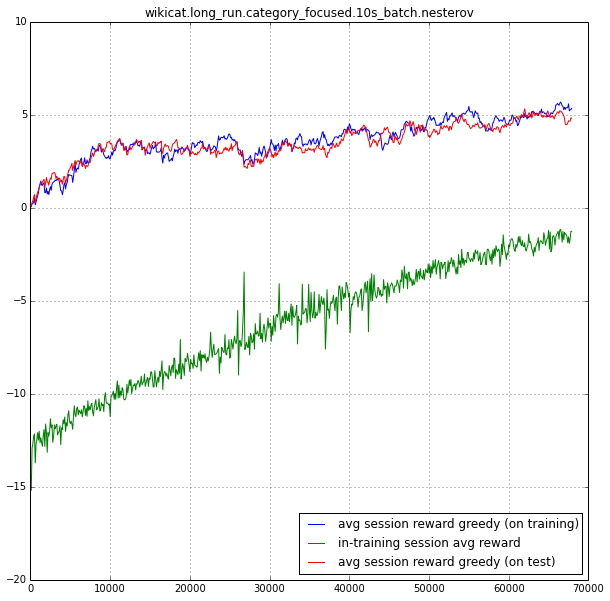

epoch 68000,loss 0.45901, greed 0.64404, rewards: ( train -1.84950, det_train 5.34581) 
rec 0.458 reg 0.001
epoch 68100,loss 0.48973, greed 0.64450, rewards: ( train -1.68361, det_train 5.41123) 
rec 0.488 reg 0.001
epoch 68200,loss 0.43115, greed 0.64496, rewards: ( train -1.71951, det_train 5.32011) 
rec 0.430 reg 0.001
epoch 68300,loss 0.47056, greed 0.64541, rewards: ( train -1.64934, det_train 5.27810) 
rec 0.469 reg 0.001
epoch 68400,loss 0.48746, greed 0.64586, rewards: ( train -1.41162, det_train 5.30029) 
rec 0.486 reg 0.001
epoch 68500,loss 0.49475, greed 0.64632, rewards: ( train -1.47543, det_train 5.26026) 
rec 0.493 reg 0.001
epoch 68600,loss 0.45130, greed 0.64677, rewards: ( train -1.47942, det_train 5.27423) 
rec 0.450 reg 0.001
epoch 68700,loss 0.37242, greed 0.64723, rewards: ( train -1.31314, det_train 5.29681) 
rec 0.371 reg 0.001
epoch 68800,loss 0.64321, greed 0.64768, rewards: ( train -1.45379, det_train 5.40713) 
rec 0.642 reg 0.001
epoch 68900,loss 0.47427, gr

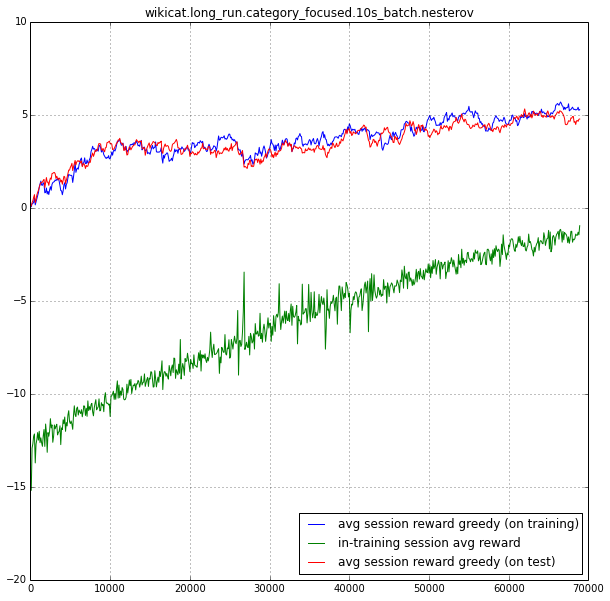

epoch 69000,loss 0.42070, greed 0.64858, rewards: ( train -1.15331, det_train 5.28277) 
rec 0.419 reg 0.001
epoch 69100,loss 0.46279, greed 0.64903, rewards: ( train -2.03344, det_train 5.31450) 
rec 0.461 reg 0.001
epoch 69200,loss 0.41431, greed 0.64948, rewards: ( train -0.97784, det_train 5.30305) 
rec 0.413 reg 0.001
epoch 69300,loss 0.47629, greed 0.64993, rewards: ( train -0.92463, det_train 5.30274) 
rec 0.475 reg 0.001
epoch 69400,loss 0.57430, greed 0.65038, rewards: ( train -1.58163, det_train 5.28247) 
rec 0.573 reg 0.001
epoch 69500,loss 0.43514, greed 0.65083, rewards: ( train -1.64970, det_train 5.27422) 
rec 0.434 reg 0.001
epoch 69600,loss 0.46602, greed 0.65128, rewards: ( train -1.34291, det_train 5.22680) 
rec 0.465 reg 0.001
epoch 69700,loss 0.44567, greed 0.65173, rewards: ( train -0.84475, det_train 5.10412) 
rec 0.444 reg 0.001
epoch 69800,loss 0.60402, greed 0.65218, rewards: ( train -1.15393, det_train 5.32371) 
rec 0.603 reg 0.001
epoch 69900,loss 0.50425, gr

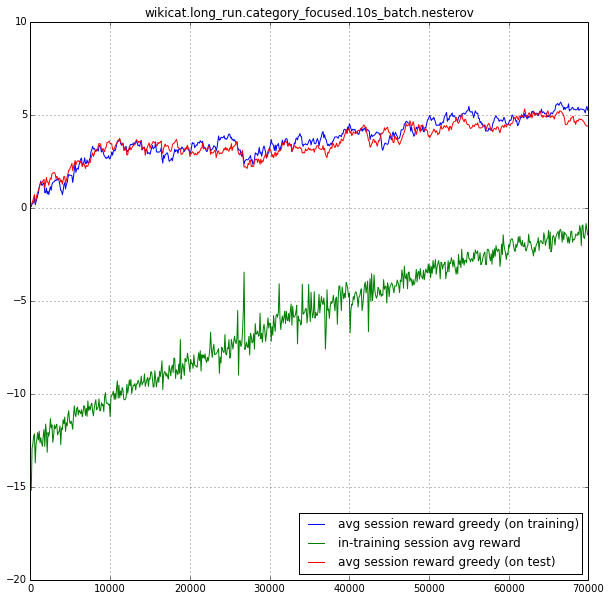

epoch 70000,loss 0.39800, greed 0.65307, rewards: ( train -0.91406, det_train 5.25620) 
rec 0.397 reg 0.001
epoch 70100,loss 0.45250, greed 0.65352, rewards: ( train -0.66820, det_train 5.43058) 
rec 0.451 reg 0.001
epoch 70200,loss 0.68217, greed 0.65397, rewards: ( train -1.09123, det_train 5.40752) 
rec 0.681 reg 0.001
epoch 70300,loss 0.47934, greed 0.65441, rewards: ( train -0.59711, det_train 5.40677) 
rec 0.478 reg 0.001
epoch 70400,loss 0.49725, greed 0.65486, rewards: ( train -0.83006, det_train 5.56609) 
rec 0.496 reg 0.001
epoch 70500,loss 0.43682, greed 0.65530, rewards: ( train -1.69274, det_train 5.65949) 
rec 0.436 reg 0.001
epoch 70600,loss 0.63035, greed 0.65575, rewards: ( train -1.44041, det_train 5.49354) 
rec 0.629 reg 0.001
epoch 70700,loss 0.42192, greed 0.65619, rewards: ( train -1.43818, det_train 5.53418) 
rec 0.421 reg 0.001
epoch 70800,loss 0.36742, greed 0.65663, rewards: ( train -0.61002, det_train 5.55076) 
rec 0.366 reg 0.001
epoch 70900,loss 0.46440, gr

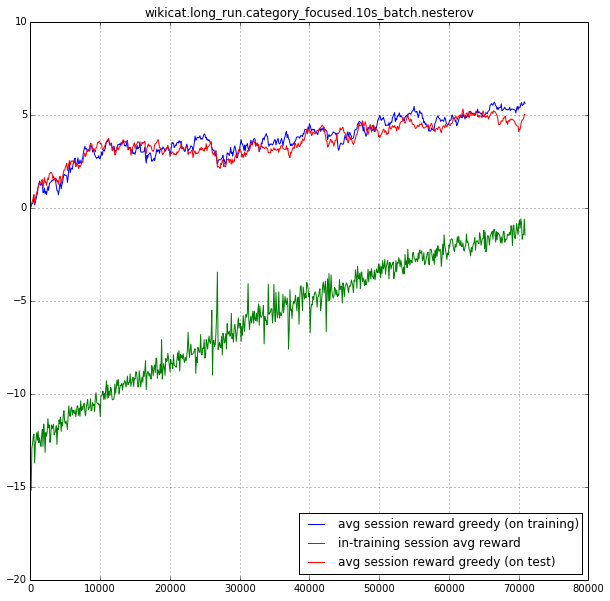

epoch 71000,loss 0.44434, greed 0.65752, rewards: ( train -0.82221, det_train 5.61512) 
rec 0.443 reg 0.001
epoch 71100,loss 0.53253, greed 0.65796, rewards: ( train -0.97867, det_train 5.50361) 
rec 0.531 reg 0.001
epoch 71200,loss 0.52076, greed 0.65840, rewards: ( train -0.64900, det_train 5.30325) 
rec 0.519 reg 0.001
epoch 71300,loss 0.31922, greed 0.65885, rewards: ( train -0.99650, det_train 5.44292) 
rec 0.318 reg 0.001
epoch 71400,loss 0.51624, greed 0.65929, rewards: ( train -0.98790, det_train 5.51863) 
rec 0.515 reg 0.001
epoch 71500,loss 0.32748, greed 0.65973, rewards: ( train -1.16093, det_train 5.33677) 
rec 0.326 reg 0.001
epoch 71600,loss 0.49949, greed 0.66017, rewards: ( train -0.63407, det_train 5.44309) 
rec 0.498 reg 0.001
epoch 71700,loss 0.38949, greed 0.66061, rewards: ( train -1.36537, det_train 5.46878) 
rec 0.388 reg 0.001
epoch 71800,loss 0.69692, greed 0.66105, rewards: ( train -1.22379, det_train 5.21190) 
rec 0.696 reg 0.001
epoch 71900,loss 0.61697, gr

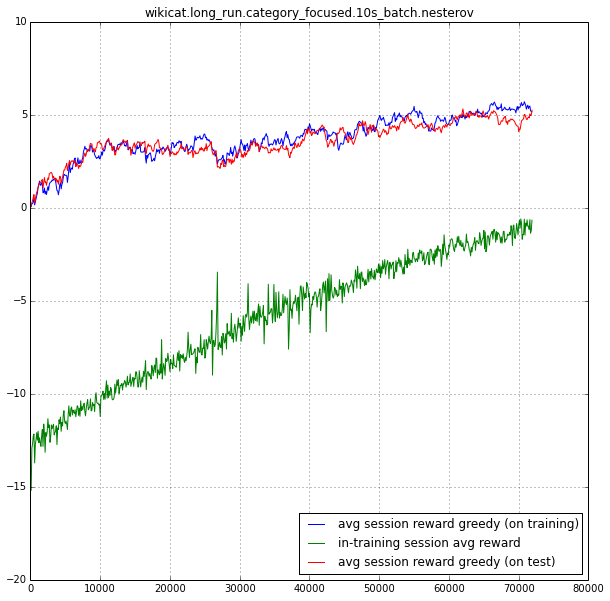

epoch 72000,loss 0.44290, greed 0.66192, rewards: ( train -0.91419, det_train 5.16264) 
rec 0.442 reg 0.001
epoch 72100,loss 0.74148, greed 0.66236, rewards: ( train -0.75462, det_train 5.09638) 
rec 0.740 reg 0.001
epoch 72200,loss 0.57267, greed 0.66280, rewards: ( train -1.32153, det_train 4.84674) 
rec 0.571 reg 0.001
epoch 72300,loss 0.50793, greed 0.66324, rewards: ( train -0.73745, det_train 4.77207) 
rec 0.507 reg 0.001
epoch 72400,loss 0.55678, greed 0.66367, rewards: ( train -1.47705, det_train 4.79486) 
rec 0.555 reg 0.001
epoch 72500,loss 0.58375, greed 0.66411, rewards: ( train -1.23685, det_train 4.61537) 
rec 0.582 reg 0.001
epoch 72600,loss 0.33092, greed 0.66454, rewards: ( train -0.91326, det_train 4.47384) 
rec 0.330 reg 0.001
epoch 72700,loss 0.57273, greed 0.66498, rewards: ( train -1.35013, det_train 4.77645) 
rec 0.571 reg 0.001
epoch 72800,loss 0.46293, greed 0.66541, rewards: ( train -0.96814, det_train 4.64881) 
rec 0.462 reg 0.001
epoch 72900,loss 0.57498, gr

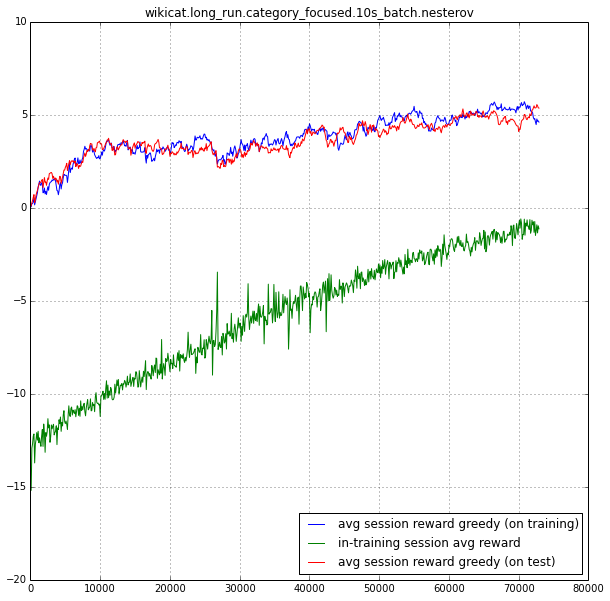

epoch 73000,loss 0.46544, greed 0.66628, rewards: ( train -0.95869, det_train 4.60653) 
rec 0.464 reg 0.001
epoch 73100,loss 0.43923, greed 0.66672, rewards: ( train -0.90953, det_train 4.57588) 
rec 0.438 reg 0.001
epoch 73200,loss 0.45218, greed 0.66715, rewards: ( train -1.22374, det_train 4.59829) 
rec 0.451 reg 0.001
epoch 73300,loss 0.38994, greed 0.66758, rewards: ( train -1.16773, det_train 4.69846) 
rec 0.389 reg 0.001
epoch 73400,loss 0.47322, greed 0.66801, rewards: ( train -0.96495, det_train 4.79862) 
rec 0.472 reg 0.001
epoch 73500,loss 0.63490, greed 0.66845, rewards: ( train -0.83360, det_train 4.77876) 
rec 0.634 reg 0.001
epoch 73600,loss 0.54897, greed 0.66888, rewards: ( train -1.04075, det_train 4.83088) 
rec 0.548 reg 0.001
epoch 73700,loss 0.67952, greed 0.66931, rewards: ( train -0.86550, det_train 4.89779) 
rec 0.678 reg 0.001
epoch 73800,loss 0.46293, greed 0.66974, rewards: ( train -0.55987, det_train 4.94801) 
rec 0.462 reg 0.001
epoch 73900,loss 0.48811, gr

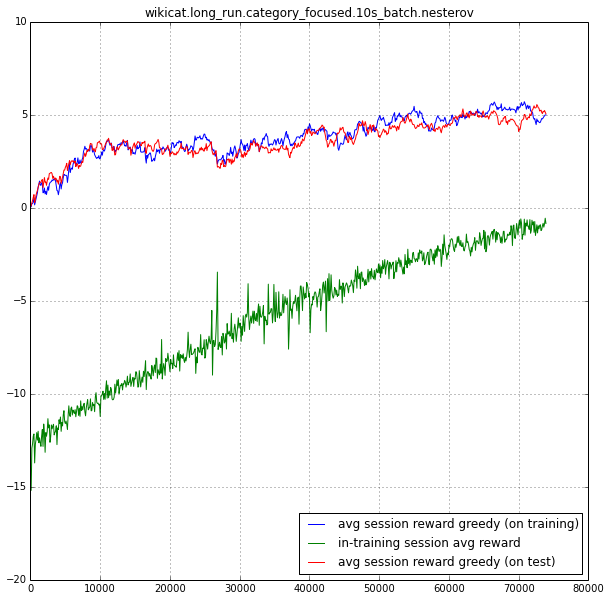

epoch 74000,loss 0.45178, greed 0.67060, rewards: ( train -0.28114, det_train 4.99389) 
rec 0.450 reg 0.001
epoch 74100,loss 0.44133, greed 0.67103, rewards: ( train -1.42265, det_train 4.97450) 
rec 0.440 reg 0.001
epoch 74200,loss 0.64130, greed 0.67146, rewards: ( train -0.57541, det_train 4.88705) 
rec 0.640 reg 0.001
epoch 74300,loss 0.37744, greed 0.67188, rewards: ( train -0.96205, det_train 4.91835) 
rec 0.376 reg 0.001
epoch 74400,loss 0.52035, greed 0.67231, rewards: ( train -0.74146, det_train 5.02651) 
rec 0.519 reg 0.001
epoch 74500,loss 0.45039, greed 0.67274, rewards: ( train -1.10029, det_train 4.99386) 
rec 0.449 reg 0.001
epoch 74600,loss 0.43333, greed 0.67317, rewards: ( train -0.88820, det_train 5.05447) 
rec 0.432 reg 0.001
epoch 74700,loss 0.59985, greed 0.67359, rewards: ( train -0.70992, det_train 5.15903) 
rec 0.599 reg 0.001
epoch 74800,loss 0.33656, greed 0.67402, rewards: ( train -0.96082, det_train 5.07312) 
rec 0.335 reg 0.001
epoch 74900,loss 0.55180, gr

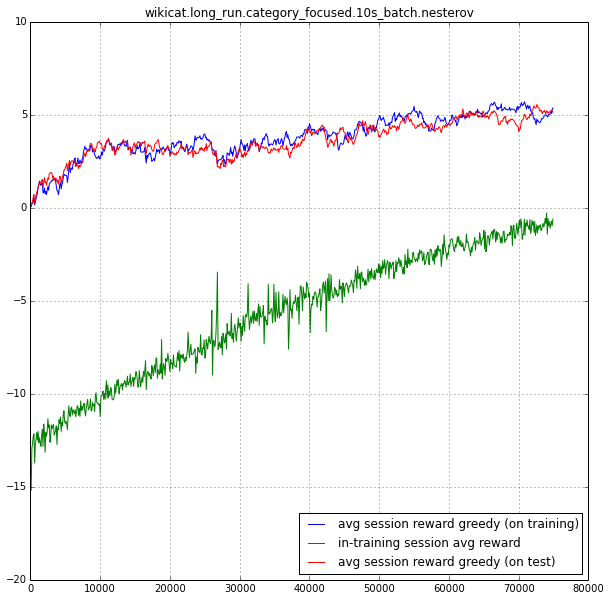

snapshot saved
epoch 75000,loss 0.47619, greed 0.67487, rewards: ( train -1.07568, det_train 5.36923) 
rec 0.475 reg 0.001
epoch 75100,loss 0.58023, greed 0.67530, rewards: ( train -0.59516, det_train 5.34231) 
rec 0.579 reg 0.001
epoch 75200,loss 0.60126, greed 0.67572, rewards: ( train -0.77768, det_train 5.31808) 
rec 0.600 reg 0.001
epoch 75300,loss 0.64236, greed 0.67614, rewards: ( train -0.81483, det_train 5.14627) 
rec 0.641 reg 0.001
epoch 75400,loss 0.53564, greed 0.67657, rewards: ( train -0.91190, det_train 5.03164) 
rec 0.534 reg 0.001
epoch 75500,loss 0.45674, greed 0.67699, rewards: ( train -0.87411, det_train 5.04848) 
rec 0.455 reg 0.001
epoch 75600,loss 0.55971, greed 0.67741, rewards: ( train -0.59245, det_train 5.04363) 
rec 0.558 reg 0.001
epoch 75700,loss 0.59066, greed 0.67784, rewards: ( train -0.30642, det_train 5.14927) 
rec 0.589 reg 0.001
epoch 75800,loss 0.40128, greed 0.67826, rewards: ( train -0.39485, det_train 5.12434) 
rec 0.400 reg 0.001
epoch 75900,l

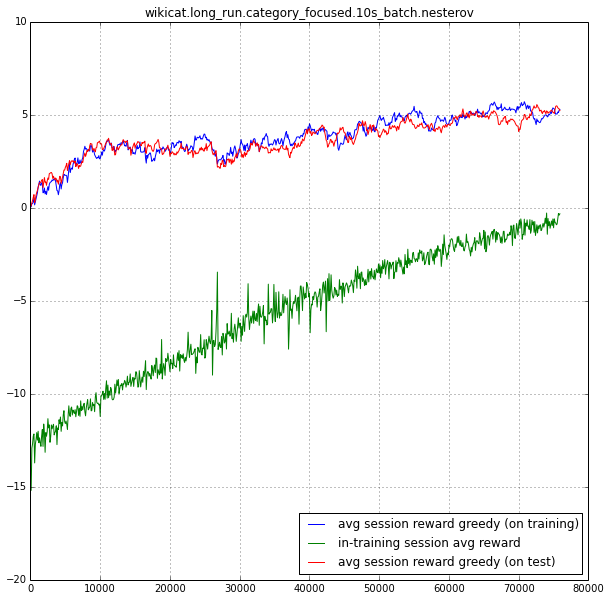

epoch 76000,loss 0.38101, greed 0.67910, rewards: ( train -0.67428, det_train 5.28672) 
rec 0.380 reg 0.001
epoch 76100,loss 0.45035, greed 0.67952, rewards: ( train -0.74881, det_train 5.50804) 
rec 0.449 reg 0.001
epoch 76200,loss 0.52070, greed 0.67994, rewards: ( train -1.22391, det_train 5.68724) 
rec 0.519 reg 0.001
epoch 76300,loss 0.49238, greed 0.68036, rewards: ( train -0.87739, det_train 5.53852) 
rec 0.491 reg 0.001
epoch 76400,loss 0.45542, greed 0.68078, rewards: ( train -0.15455, det_train 5.57466) 
rec 0.454 reg 0.001
epoch 76500,loss 0.54954, greed 0.68120, rewards: ( train -0.64645, det_train 5.65720) 
rec 0.548 reg 0.001
epoch 76600,loss 0.64012, greed 0.68162, rewards: ( train -0.34674, det_train 5.48148) 
rec 0.639 reg 0.001
epoch 76700,loss 0.54175, greed 0.68204, rewards: ( train -0.43336, det_train 5.37333) 
rec 0.540 reg 0.001
epoch 76800,loss 0.46618, greed 0.68245, rewards: ( train -1.32471, det_train 5.28600) 
rec 0.465 reg 0.001
epoch 76900,loss 0.50829, gr

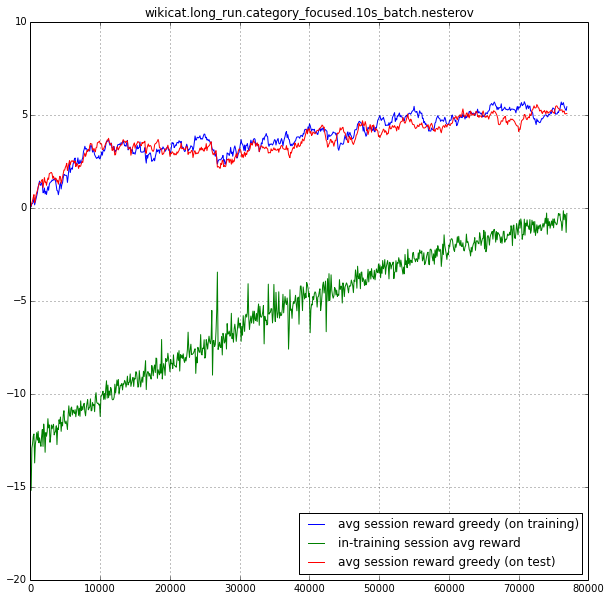

epoch 77000,loss 0.65545, greed 0.68329, rewards: ( train -0.21238, det_train 5.43366) 
rec 0.654 reg 0.001
epoch 77100,loss 0.31530, greed 0.68370, rewards: ( train -0.63280, det_train 5.28029) 
rec 0.314 reg 0.001
epoch 77200,loss 0.50236, greed 0.68412, rewards: ( train -0.35840, det_train 5.35226) 
rec 0.501 reg 0.001
epoch 77300,loss 0.51471, greed 0.68454, rewards: ( train -0.42073, det_train 5.25704) 
rec 0.513 reg 0.001
epoch 77400,loss 0.61583, greed 0.68495, rewards: ( train -0.58013, det_train 5.31133) 
rec 0.615 reg 0.001
epoch 77500,loss 0.45076, greed 0.68537, rewards: ( train -0.24301, det_train 5.13020) 
rec 0.449 reg 0.001
epoch 77600,loss 0.47681, greed 0.68578, rewards: ( train -0.71720, det_train 5.21718) 
rec 0.475 reg 0.001
epoch 77700,loss 0.48734, greed 0.68620, rewards: ( train -0.57314, det_train 5.28546) 
rec 0.486 reg 0.001
epoch 77800,loss 0.54672, greed 0.68661, rewards: ( train -1.07476, det_train 5.39692) 
rec 0.545 reg 0.001
epoch 77900,loss 0.43387, gr

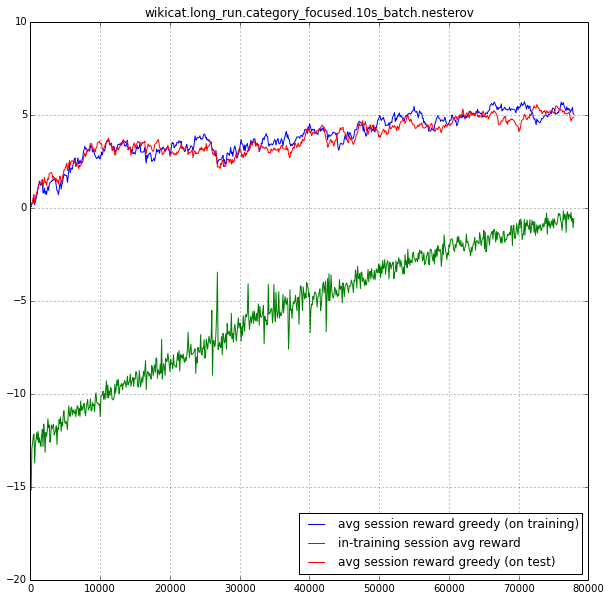

epoch 78000,loss 0.46691, greed 0.68743, rewards: ( train -0.89813, det_train 5.01950) 
rec 0.466 reg 0.001
epoch 78100,loss 0.52716, greed 0.68785, rewards: ( train 0.18540, det_train 5.17755) 
rec 0.526 reg 0.001
epoch 78200,loss 0.61751, greed 0.68826, rewards: ( train -0.59991, det_train 5.12980) 
rec 0.616 reg 0.001
epoch 78300,loss 0.41224, greed 0.68867, rewards: ( train -0.75105, det_train 5.10682) 
rec 0.411 reg 0.001
epoch 78400,loss 0.60246, greed 0.68908, rewards: ( train -0.48029, det_train 5.11613) 
rec 0.601 reg 0.001
epoch 78500,loss 0.58427, greed 0.68949, rewards: ( train -0.30025, det_train 4.99452) 
rec 0.583 reg 0.001
epoch 78600,loss 0.60256, greed 0.68990, rewards: ( train -0.20254, det_train 5.05507) 
rec 0.601 reg 0.001
epoch 78700,loss 0.62489, greed 0.69031, rewards: ( train -0.54499, det_train 5.20956) 
rec 0.624 reg 0.001
epoch 78800,loss 0.42029, greed 0.69072, rewards: ( train -0.40319, det_train 5.22861) 
rec 0.419 reg 0.001
epoch 78900,loss 0.48710, gre

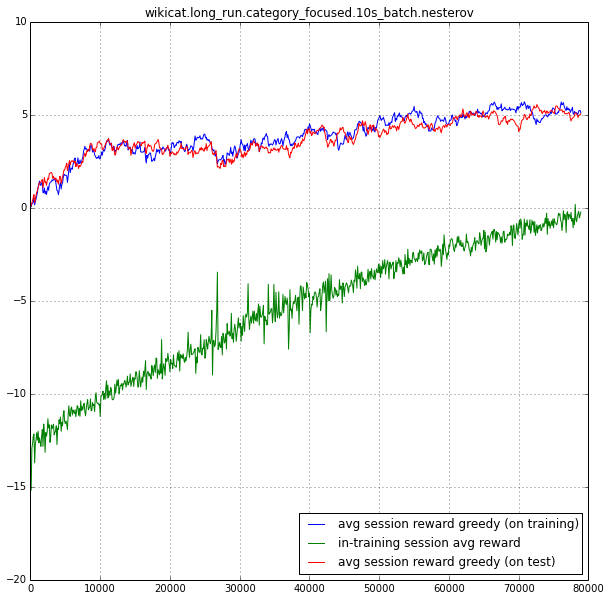

epoch 79000,loss 0.50667, greed 0.69154, rewards: ( train -0.40135, det_train 5.12217) 
rec 0.505 reg 0.001
epoch 79100,loss 0.66000, greed 0.69195, rewards: ( train -0.08885, det_train 5.15995) 
rec 0.659 reg 0.001
epoch 79200,loss 0.39776, greed 0.69236, rewards: ( train -0.48380, det_train 5.08396) 
rec 0.396 reg 0.001
epoch 79300,loss 0.54524, greed 0.69276, rewards: ( train -0.86380, det_train 5.08556) 
rec 0.544 reg 0.001
epoch 79400,loss 0.53145, greed 0.69317, rewards: ( train -0.25183, det_train 4.96701) 
rec 0.530 reg 0.001
epoch 79500,loss 0.46496, greed 0.69358, rewards: ( train -0.22874, det_train 5.01031) 
rec 0.464 reg 0.001
epoch 79600,loss 0.46154, greed 0.69398, rewards: ( train -0.31844, det_train 5.08928) 
rec 0.460 reg 0.001
epoch 79700,loss 0.59413, greed 0.69439, rewards: ( train -0.87187, det_train 5.02035) 
rec 0.593 reg 0.001
epoch 79800,loss 0.46148, greed 0.69479, rewards: ( train -0.22568, det_train 4.83831) 
rec 0.460 reg 0.001
epoch 79900,loss 0.44369, gr

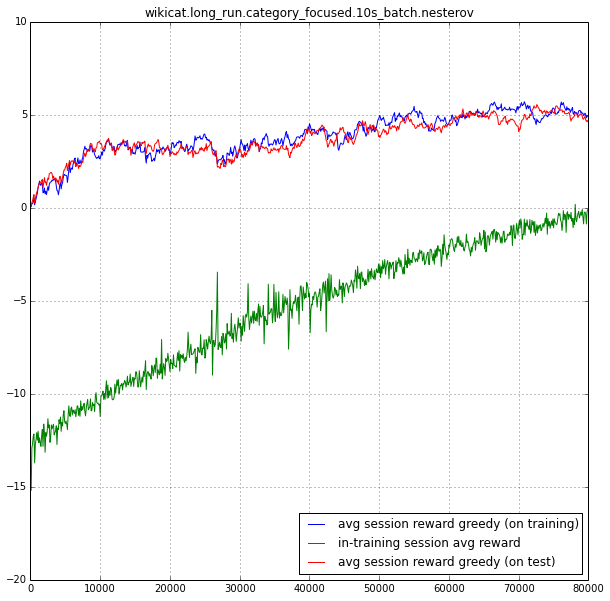

epoch 80000,loss 0.54769, greed 0.69560, rewards: ( train 0.16461, det_train 4.94303) 
rec 0.546 reg 0.001
epoch 80100,loss 0.52163, greed 0.69601, rewards: ( train -0.43058, det_train 5.15873) 
rec 0.520 reg 0.001
epoch 80200,loss 0.54798, greed 0.69641, rewards: ( train -0.54676, det_train 5.28286) 
rec 0.547 reg 0.001
epoch 80300,loss 0.49286, greed 0.69682, rewards: ( train -0.41431, det_train 5.26457) 
rec 0.492 reg 0.001
epoch 80400,loss 0.46139, greed 0.69722, rewards: ( train -0.41173, det_train 5.19811) 
rec 0.460 reg 0.001
epoch 80500,loss 0.53391, greed 0.69762, rewards: ( train -0.48885, det_train 5.34830) 
rec 0.533 reg 0.001
epoch 80600,loss 0.54237, greed 0.69802, rewards: ( train -0.49994, det_train 5.28347) 
rec 0.541 reg 0.001
epoch 80700,loss 0.47951, greed 0.69842, rewards: ( train 0.02441, det_train 5.29513) 
rec 0.478 reg 0.001
epoch 80800,loss 0.58907, greed 0.69883, rewards: ( train -0.35561, det_train 5.37561) 
rec 0.588 reg 0.001
epoch 80900,loss 0.49722, gree

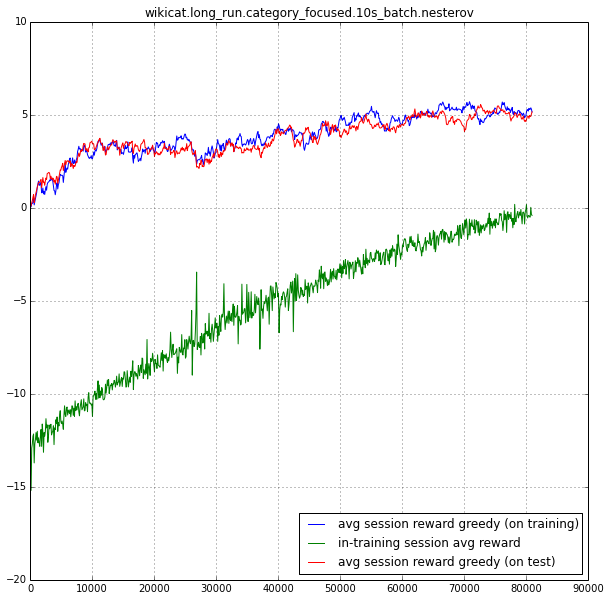

epoch 81000,loss 0.63150, greed 0.69963, rewards: ( train -0.38440, det_train 5.14825) 
rec 0.630 reg 0.001
epoch 81100,loss 0.52737, greed 0.70003, rewards: ( train 0.11382, det_train 5.18342) 
rec 0.526 reg 0.001
epoch 81200,loss 0.62342, greed 0.70043, rewards: ( train -0.50729, det_train 5.31508) 
rec 0.622 reg 0.001
epoch 81300,loss 0.43608, greed 0.70083, rewards: ( train -0.23568, det_train 5.29357) 
rec 0.435 reg 0.001
epoch 81400,loss 0.66568, greed 0.70123, rewards: ( train -0.27620, det_train 5.29421) 
rec 0.664 reg 0.001
epoch 81500,loss 0.43583, greed 0.70162, rewards: ( train -0.10927, det_train 5.18479) 
rec 0.435 reg 0.001
epoch 81600,loss 0.50651, greed 0.70202, rewards: ( train -0.34782, det_train 5.26631) 
rec 0.505 reg 0.001
epoch 81700,loss 0.57334, greed 0.70242, rewards: ( train -0.54999, det_train 5.14968) 
rec 0.572 reg 0.001
epoch 81800,loss 0.55935, greed 0.70282, rewards: ( train 0.28951, det_train 5.22471) 
rec 0.558 reg 0.001
epoch 81900,loss 0.60774, gree

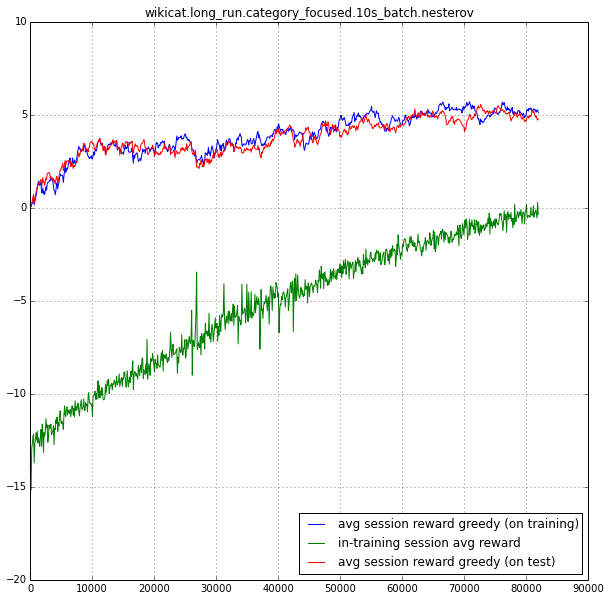

epoch 82000,loss 0.32965, greed 0.70361, rewards: ( train -0.30687, det_train 5.10602) 
rec 0.328 reg 0.001
epoch 82100,loss 0.55391, greed 0.70401, rewards: ( train -0.90973, det_train 5.22542) 
rec 0.553 reg 0.001
epoch 82200,loss 0.59583, greed 0.70440, rewards: ( train -0.25125, det_train 5.18287) 
rec 0.595 reg 0.001
epoch 82300,loss 0.47424, greed 0.70480, rewards: ( train -0.20881, det_train 5.13459) 
rec 0.473 reg 0.001
epoch 82400,loss 0.64382, greed 0.70519, rewards: ( train -0.09140, det_train 5.22113) 
rec 0.642 reg 0.001
epoch 82500,loss 0.50889, greed 0.70559, rewards: ( train 0.19423, det_train 5.17902) 

In [ ]:
n_epochs = 10**6
batch_size=10
for i in range(n_epochs):
    
    resolver.rng.seed(epoch_counter)
    
    creeping_greed = min(0.1 + (1.-np.exp(-epoch_counter/100000.)*0.9),0.95)
    creeping_epsilon = 1.-creeping_greed
    
    
    #train
    load_random_batch(env,train_attrs,train_cats,batch_size=batch_size)
    
    loss,q_loss,reg_loss,avg_reward = train_fun()
    
    
    
    #reward loss moving average
    ma_reward = alpha*avg_reward+ (1-alpha)*ma_reward
    
    
    
    
    if epoch_counter%1000==0:
        print "Evaluation:"
        print '\ndeterministic'
        set_shared(resolver.epsilon,0)
        print_session(1)
        
        
        
        print '\ncurrent_greediness (%f)'%creeping_greed
        set_shared(resolver.epsilon,creeping_epsilon)
        print_session(1)
        
        plot_scores(experiment_setup_name)

    if epoch_counter% 25000 ==0:
        save(resolver,"/root/agentnet_snapshots/{}.epoch{}.pcl".format(experiment_setup_name,epoch_counter))
        print "snapshot saved"
        
        


    if epoch_counter%100 ==0:
        print "epoch %i,loss %.5f, greed %.5f, rewards: ( train %.5f, det_train %.5f) "%(
            epoch_counter,loss,creeping_greed,ma_reward,ma_reward_greedy)
        print "rec %.3f reg %.3f"%(q_loss,reg_loss)
        
        score_log["in-training session avg reward"][epoch_counter] = ma_reward
        
        
        
        #greedy train
        set_shared(resolver.epsilon,0)
        avg_reward_greedy = loss_fun()[-1]
        ma_reward_greedy = (1-alpha)*ma_reward_greedy + alpha*avg_reward_greedy
        score_log["avg session reward greedy (on training)"][epoch_counter] = ma_reward_greedy

        #greedy test
        set_shared(resolver.epsilon,0)
        load_random_batch(env,test_attrs,test_cats,batch_size=batch_size)

        avg_reward_test = loss_fun()[-1]
        ma_reward_test = (1-alpha)*ma_reward_test + alpha*avg_reward_test
        score_log["avg session reward greedy (on test)"][epoch_counter] = ma_reward_test
        

        
        #back to epsilon-greedy
        set_shared(resolver.epsilon,creeping_epsilon)


        
        
    epoch_counter  +=1


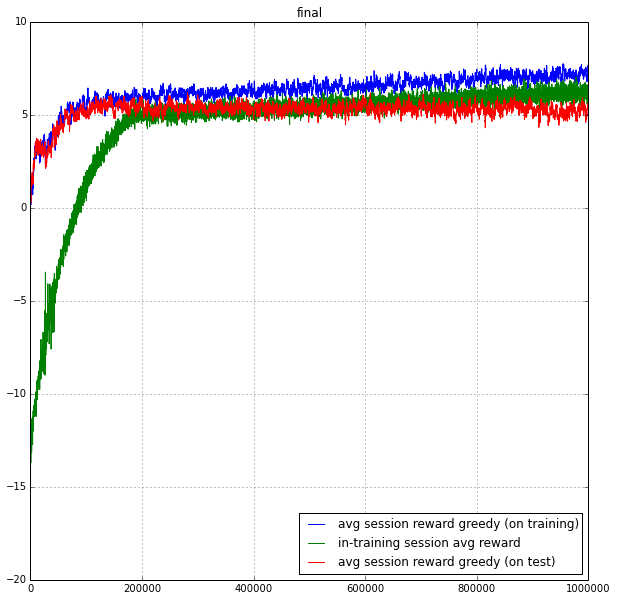

In [31]:
plot_scores("final")

In [32]:
load_random_batch(env,train_attrs,train_cats,10)
print_session(10)

#149: Labels:is_known (5.472) -> 1.0 | #26: decades_active:2010 (5.250) -> 1.0 | #25: last_activity:still_active (4.664) -> -1.0 | #166: decades_active:2000 (7.273) -> 1.0 | #260: decades_active:1990 (6.697) -> 1.0 | #25: last_activity:still_active (6.005) -> 0.0 | #1: Birth name:is_known (6.237) -> 1.0 | #91: decades_active:1980 (5.939) -> 1.0 | #221: decades_active:1970 (5.383) -> 1.0 | #43: decades_active:1960 (4.070) -> 1.0 | #45: decades_active:1950 (2.983) -> 1.0 | #239: Died:is_known (3.224) -> 1.0 | #25: last_activity:still_active (2.310) -> 0.0 | #239: Died:is_known (2.335) -> 0.0 | #354: category:List_of_deaths_in_rock_and_roll (2.519) -> -1.0 | #289: decades_active:1940 (0.987) -> 1.0 | #291: first_activity:1995 (-1.353) -> -1.0 | #289: decades_active:1940 (0.025) -> 0.0 | #149: Labels:is_known (0.017) -> 0.0 | #149: Labels:is_known (0.010) -> 0.0 | <end>
true: category:List_of_child_music_prodigies category:List_of_banjo_players

#149: Labels:is_known (5.472) -> -1.0 | #166

#149: Labels:is_known (5.472) -> 1.0 | #94: Origin:atlanta (4.012) -> -1.0 | #256: Genres:score (3.927) -> -1.0 | #26: decades_active:2010 (5.095) -> 1.0 | #25: last_activity:still_active (4.606) -> -1.0 | #166: decades_active:2000 (7.227) -> 1.0 | #260: decades_active:1990 (6.676) -> 1.0 | #25: last_activity:still_active (5.945) -> 0.0 | #1: Birth name:is_known (6.262) -> 1.0 | #91: decades_active:1980 (5.984) -> 1.0 | #221: decades_active:1970 (5.310) -> 1.0 | #43: decades_active:1960 (4.037) -> 1.0 | #45: decades_active:1950 (2.972) -> 1.0 | #239: Died:is_known (3.266) -> 1.0 | #25: last_activity:still_active (2.287) -> 0.0 | #239: Died:is_known (2.278) -> 0.0 | #354: category:List_of_deaths_in_rock_and_roll (2.487) -> -1.0 | #289: decades_active:1940 (0.963) -> 1.0 | #149: Labels:is_known (0.054) -> 0.0 | #149: Labels:is_known (0.049) -> 0.0 | <end>
true: category:List_of_child_music_prodigies category:List_of_banjo_players


/usr/lib/pymodules/python2.7/matplotlib/collections.py:548: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == 'face':


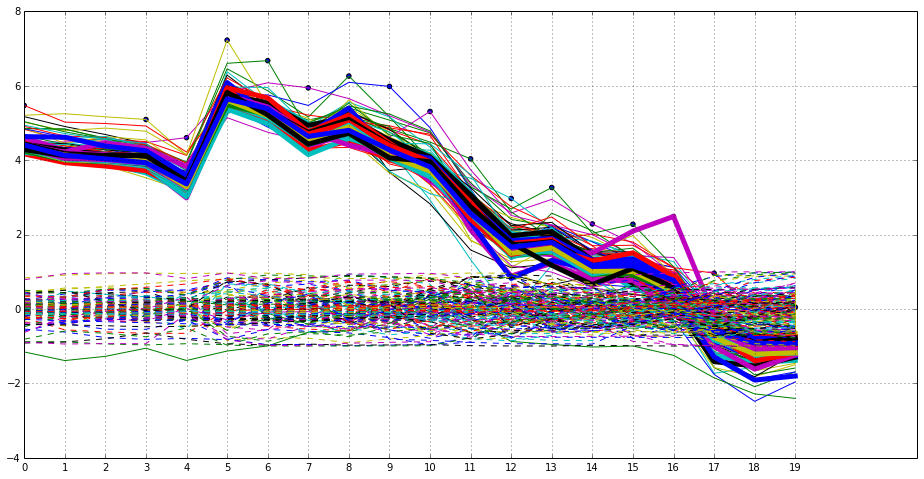


#149: Labels:is_known (5.472) -> -1.0 | #166: decades_active:2000 (5.080) -> 1.0 | #260: decades_active:1990 (4.586) -> 1.0 | #26: decades_active:2010 (3.866) -> 1.0 | #25: last_activity:still_active (3.052) -> -1.0 | #239: Died:is_known (5.619) -> 1.0 | #91: decades_active:1980 (5.127) -> 1.0 | #221: decades_active:1970 (4.188) -> 1.0 | #43: decades_active:1960 (3.035) -> -1.0 | #3: Instruments:guitar (4.361) -> 1.0 | #1: Birth name:is_known (4.755) -> 1.0 | #167: Genres:rock (4.099) -> 1.0 | #262: Occupation:musician (4.898) -> 1.0 | #380: category:List_of_bass_guitarists (4.113) -> 2.0 | #354: category:List_of_deaths_in_rock_and_roll (4.931) -> 2.0 | #233: Genres:blues (3.194) -> 1.0 | #247: Website:is_known (2.462) -> 1.0 | #68: Genres:pop (1.682) -> 1.0 | #286: Occupation:composer (1.030) -> 1.0 | #286: Occupation:composer (0.140) -> 0.0 | <end>
true: category:List_of_jazz_fusion_musicians category:List_of_deaths_in_rock_and_roll category:List_of_singer-songwriters category:List_

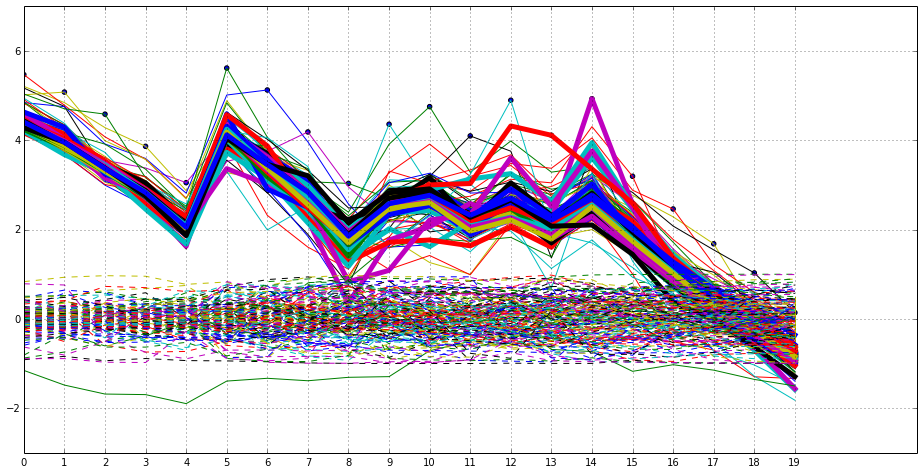


#149: Labels:is_known (5.472) -> 1.0 | #26: decades_active:2010 (5.250) -> 1.0 | #25: last_activity:still_active (4.664) -> 1.0 | #166: decades_active:2000 (3.699) -> 1.0 | #247: Website:is_known (3.010) -> -1.0 | #260: decades_active:1990 (3.497) -> 1.0 | #306: category:List_of_jazz_drummers (1.766) -> -1.0 | #1: Birth name:is_known (2.843) -> 1.0 | #91: decades_active:1980 (2.642) -> 1.0 | #221: decades_active:1970 (2.351) -> -1.0 | #170: Genres:hip (2.540) -> 1.0 | #297: Genres:hop (2.540) -> 1.0 | #143: Occupation:rapper (1.685) -> 1.0 | #290: Also known as:is_known (1.076) -> -1.0 | #3: Instruments:guitar (1.448) -> -1.0 | #149: Labels:is_known (-0.031) -> 0.0 | #149: Labels:is_known (0.003) -> 0.0 | #149: Labels:is_known (0.008) -> 0.0 | #149: Labels:is_known (0.012) -> 0.0 | #149: Labels:is_known (0.013) -> 0.0 | <end>
true: category:List_of_West_Coast_hip_hop_artists category:List_of_hip_hop_musicians


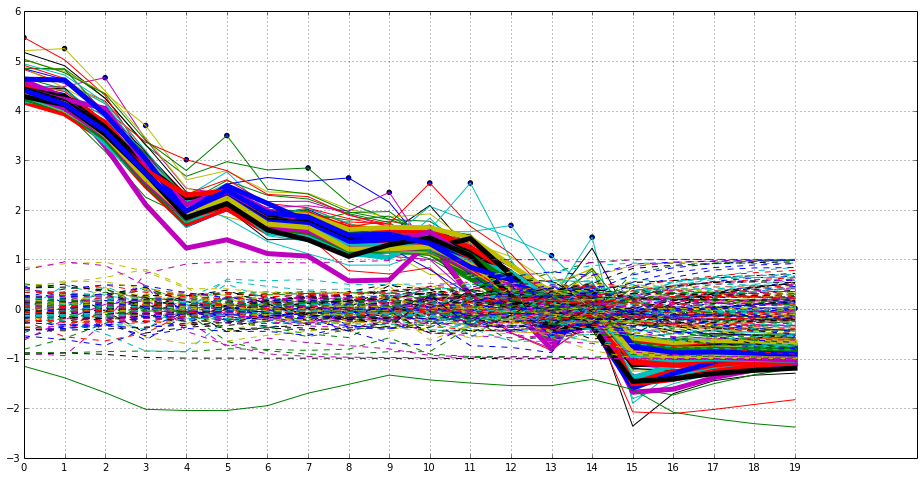

In [33]:
print_session(display=True,legend=False)

In [ ]:
load_random_batch(env,test_attrs,test_cats,10)
print_session(10)

In [ ]:
print_session(display=True,legend=False)